In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Dropout
import xgboost
import pickle

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [2]:
alpha_key = 'RNZPXZ6Q9FEFMEHM'
ticker = 'META'
periods = 20
csvPath = './DATA/'+ ticker +'.csv'
from alpha_vantage.timeseries import TimeSeries

ts = TimeSeries(key=alpha_key, output_format='pandas')

In [3]:
data = ts.get_intraday(symbol=ticker,interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

open    high     low    close   volume
date                                                         
2023-06-27 19:45:00  286.48  286.65  286.22  286.310   4858.0
2023-06-27 19:30:00  286.15  286.60  286.10  286.380   8294.0
2023-06-27 19:15:00  286.34  286.40  286.00  286.150  12152.0
2023-06-27 19:00:00  286.31  286.50  286.21  286.305   5073.0
2023-06-27 18:45:00  286.35  286.70  286.21  286.310   5625.0
...                     ...     ...     ...      ...      ...
2023-05-30 05:00:00  266.76  267.35  266.71  267.340   5655.0
2023-05-30 04:45:00  266.46  266.93  266.32  266.800   8062.0
2023-05-30 04:30:00  265.76  266.59  265.58  266.500  10067.0
2023-05-30 04:15:00  265.94  266.26  265.57  265.760   9314.0
2023-05-30 04:00:00  263.75  266.47  263.52  265.660  14170.0

[1280 rows x 5 columns]

# INDICATORS CALCULATION

In [4]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key=alpha_key, output_format='pandas')

## 1. Rate of Change (ROC)

In [5]:
indicator_roc = ti.get_roc(symbol=ticker, interval='15min', time_period=periods)
indicator_roc = indicator_roc[0]
indicator_roc

ROC
date                       
2023-05-30 09:00:00  0.6154
2023-05-30 09:15:00 -0.2446
2023-05-30 09:30:00 -0.2627
2023-05-30 09:45:00 -0.6439
2023-05-30 10:00:00 -0.4691
...                     ...
2023-06-27 18:45:00 -0.5730
2023-06-27 19:00:00 -0.5385
2023-06-27 19:15:00 -0.9227
2023-06-27 19:30:00 -0.6143
2023-06-27 19:45:00 -0.3515

[1260 rows x 1 columns]

## 2. Simple Moving Average (SMA)

In [6]:
indicator_sma = ti.get_sma(symbol=ticker, interval='15min', time_period=periods)
indicator_sma = indicator_sma[0]
indicator_sma


SMA
date                         
2023-05-30 08:45:00  267.3880
2023-05-30 09:00:00  267.4698
2023-05-30 09:15:00  267.4372
2023-05-30 09:30:00  267.4022
2023-05-30 09:45:00  267.3164
...                       ...
2023-06-27 18:45:00  287.1522
2023-06-27 19:00:00  287.0747
2023-06-27 19:15:00  286.9415
2023-06-27 19:30:00  286.8530
2023-06-27 19:45:00  286.8025

[1261 rows x 1 columns]

## 3. Relative Strength Index (RSI)

In [7]:
indicator_rsi = ti.get_rsi(symbol=ticker, interval='15min', time_period=periods)
indicator_rsi = indicator_rsi[0]
indicator_rsi

RSI
date                        
2023-05-30 09:00:00  60.3678
2023-05-30 09:15:00  46.7354
2023-05-30 09:30:00  50.4546
2023-05-30 09:45:00  46.8699
2023-05-30 10:00:00  51.9000
...                      ...
2023-06-27 18:45:00  52.6030
2023-06-27 19:00:00  52.5646
2023-06-27 19:15:00  51.3413
2023-06-27 19:30:00  53.0480
2023-06-27 19:45:00  52.4586

[1260 rows x 1 columns]

## 4. Bolling Bands (BBANDS)

In [8]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

In [9]:
indicator_bb = ti.get_bbands(symbol=ticker, interval='15min', time_period=periods)
indicator_bb = indicator_bb[0]
indicator_bb

Real Upper Band  Real Middle Band  Real Lower Band
date                                                                   
2023-06-27 19:45:00         287.6992          286.8025         285.9058
2023-06-27 19:30:00         287.7468          286.8530         285.9592
2023-06-27 19:15:00         287.9707          286.9415         285.9123
2023-06-27 19:00:00         288.3257          287.0747         285.8238
2023-06-27 18:45:00         288.3949          287.1522         285.9096
...                              ...               ...              ...
2023-05-30 09:45:00         269.2418          267.3164         265.3909
2023-05-30 09:30:00         269.0554          267.4022         265.7491
2023-05-30 09:15:00         268.9791          267.4372         265.8954
2023-05-30 09:00:00         268.8308          267.4698         266.1087
2023-05-30 08:45:00         268.9611          267.3880         265.8149

[1261 rows x 3 columns]

**Merge indicators to data**

In [10]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv(csvPath)
original_df

open     high     low    close     volume     ROC  \
date                                                                        
2023-05-30 09:00:00  267.500  268.000  267.01  267.295    35192.0  0.6154   
2023-05-30 09:15:00  267.295  267.550  264.12  265.110   114877.0 -0.2446   
2023-05-30 09:30:00  265.250  268.650  262.75  265.800  3589455.0 -0.2627   
2023-05-30 09:45:00  265.710  266.750  262.92  265.082  1633205.0 -0.6439   
2023-05-30 10:00:00  265.130  266.860  264.32  266.086  1298151.0 -0.4691   
...                      ...      ...     ...      ...        ...     ...   
2023-06-27 14:00:00  287.970  288.023  287.31  287.855   472842.0  1.8595   
2023-06-27 14:15:00  287.855  288.815  287.58  288.815   622885.0  2.4530   
2023-06-27 14:30:00  288.820  289.345  287.95  288.150   849237.0  2.3514   
2023-06-27 14:45:00  288.158  288.350  287.22  287.320   628433.0  1.1192   
2023-06-27 15:00:00  287.320  288.320  287.32  287.990   576612.0  2.0481   

                          SMA      RSI  Real Upper Band  Real Middle Band  \
date                                                                        
2023-05-30 09:00:00  267.4698  60.3678       269.552763          267.4698   
2023-05-30 09:15:00  267.4372  46.7354       269.784126          267.4372   
2023-05-30 09:30:00  267.4022  50.4546       269.926989          267.4022   
2023-05-30 09:45:00  267.3164  46.8699       269.824371          267.3164   
2023-05-30 10:00:00  267.2536  51.9000       269.781087          267.2536   
...                       ...      ...              ...               ...   
2023-06-27 14:00:00  285.3151  67.2909       286.770329          285.3151   
2023-06-27 14:15:00  285.6609  70.0643       287.115607          285.6609   
2023-06-27 14:30:00  285.9919  65.9847       287.328613          285.9919   
2023-06-27 14:45:00  286.1509  61.2956       287.273913          286.1509   
2023-06-27 15:00:00  286.4399  63.4996       287.500140          286.4399   

                     Real Lower Band  
date                                  
2023-05-30 09:00:00       265.386837  
2023-05-30 09:15:00       265.090274  
2023-05-30 09:30:00       264.877411  
2023-05-30 09:45:00       264.808429  
2023-05-30 10:00:00       264.726113  
...                              ...  
2023-06-27 14:00:00       283.859871  
2023-06-27 14:15:00       284.206193  
2023-06-27 14:30:00       284.655187  
2023-06-27 14:45:00       285.027887  
2023-06-27 15:00:00       285.379660  

[1241 rows x 11 columns]

# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [11]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[267.295],
       [265.11 ],
       [265.8  ],
       ...,
       [288.15 ],
       [287.32 ],
       [287.99 ]])

In [12]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.24042339],
       [0.16700269],
       [0.19018817],
       ...,
       [0.94119624],
       [0.91330645],
       [0.93581989]])

In [13]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1181
1181


In [14]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (945, 60, 1)
Size validate:  (118, 60, 1)
Size test:  (118, 60, 1)


### b. Train Model

In [15]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
30/30 [==============================] - 10s 88ms/step - loss: 0.0407 - val_loss: 0.0040
Epoch 2/20
30/30 [==============================] - 2s 53ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 3/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 4/20
30/30 [==============================] - 2s 52ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 5/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 6/20
30/30 [==============================] - 2s 54ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 7/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 8/20
30/30 [==============================] - 2s 53ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 9/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 10/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 11

### c. Test Model

In [16]:
model_lstm = load_model('./MODEL/LSTM.h5')
model_lstm

In [17]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

4/4 [==============================] - 1s 19ms/step


In [18]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date     open     high     low    close    volume  \
1123  2023-06-23 17:45:00  288.750  288.840  288.65  288.730  248026.0   
1124  2023-06-23 18:00:00  288.755  288.800  288.72  288.730   63534.0   
1125  2023-06-23 18:15:00  288.740  288.980  288.72  288.770    3219.0   
1126  2023-06-23 18:30:00  288.875  288.970  288.77  288.820    8326.0   
1127  2023-06-23 18:45:00  288.860  288.880  288.59  288.610    5577.0   
...                   ...      ...      ...     ...      ...       ...   
1236  2023-06-27 14:00:00  287.970  288.023  287.31  287.855  472842.0   
1237  2023-06-27 14:15:00  287.855  288.815  287.58  288.815  622885.0   
1238  2023-06-27 14:30:00  288.820  289.345  287.95  288.150  849237.0   
1239  2023-06-27 14:45:00  288.158  288.350  287.22  287.320  628433.0   
1240  2023-06-27 15:00:00  287.320  288.320  287.32  287.990  576612.0   

         ROC       SMA      RSI  Real Upper Band  Real Middle Band  \
1123  0.5240  287.8459  63.9237       288.532378          287.8459   
1124  0.1283  287.8644  63.9237       288.634680          287.8644   
1125  0.1283  287.8829  64.0992       288.700388          287.8829   
1126  0.1595  287.9059  64.3275       288.794127          287.9059   
1127  0.2396  287.9404  62.5682       288.913513          287.9404   
...      ...       ...      ...              ...               ...   
1236  1.8595  285.3151  67.2909       286.770329          285.3151   
1237  2.4530  285.6609  70.0643       287.115607          285.6609   
1238  2.3514  285.9919  65.9847       287.328613          285.9919   
1239  1.1192  286.1509  61.2956       287.273913          286.1509   
1240  2.0481  286.4399  63.4996       287.500140          286.4399   

      Real Lower Band  predictions  
1123       287.159422   288.632019  
1124       287.094120   288.727386  
1125       287.065412   288.778046  
1126       287.017673   288.800476  
1127       286.967287   288.808502  
...               ...          ...  
1236       283.859871   287.541229  
1237       284.206193   287.712952  
1238       284.655187   287.989868  
1239       285.027887   288.173767  
1240       285.379660   288.161011  

[118 rows x 13 columns]

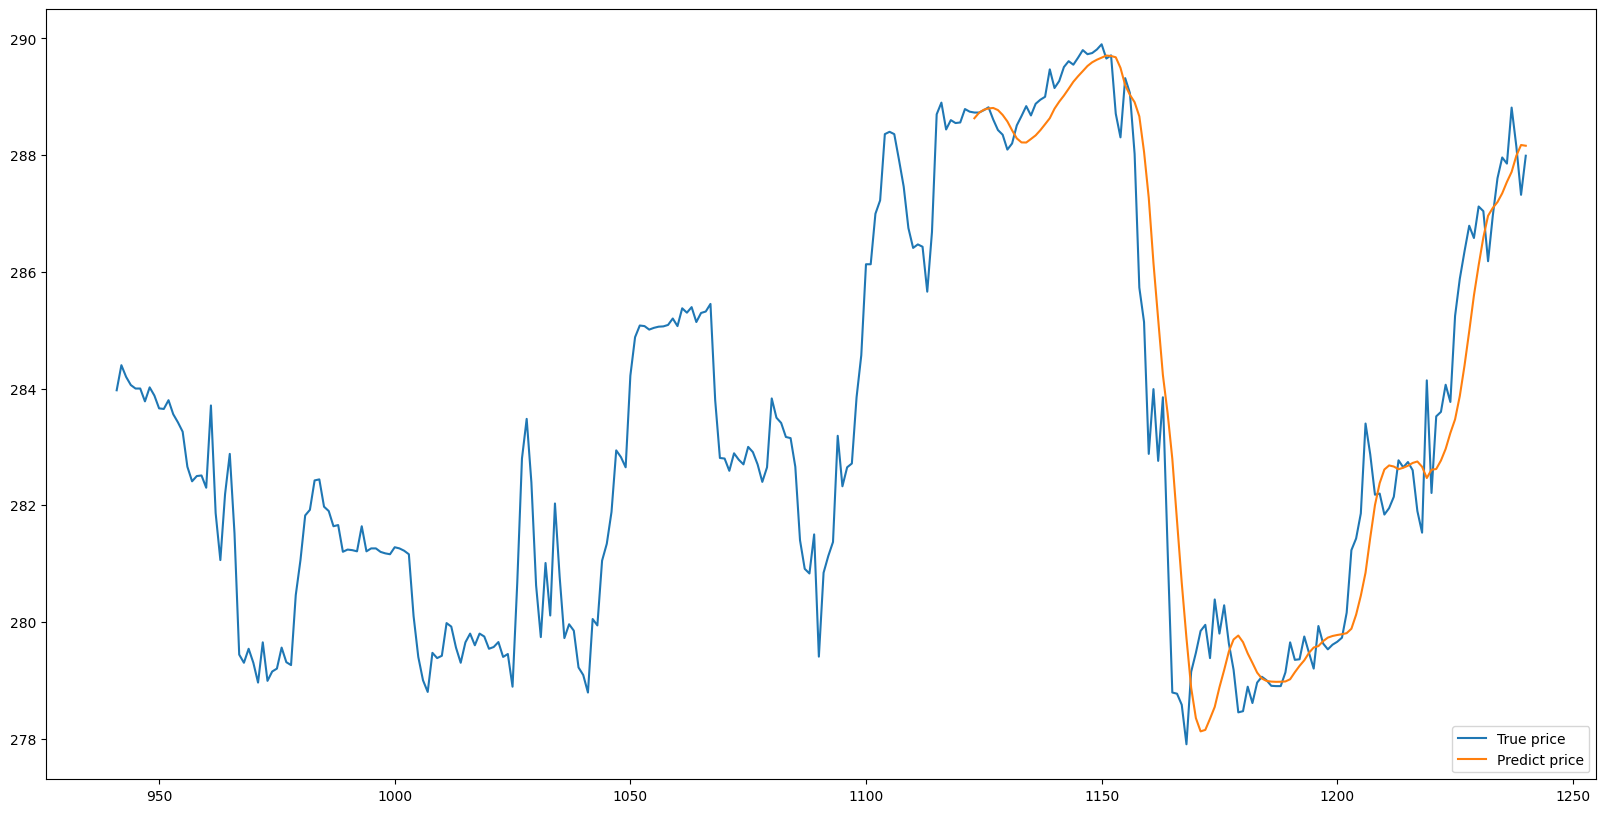

In [19]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [20]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.67295e+02,  6.15400e-01],
       [ 2.65110e+02, -2.44600e-01],
       [ 2.65800e+02, -2.62700e-01],
       ...,
       [ 2.88150e+02,  2.35140e+00],
       [ 2.87320e+02,  1.11920e+00],
       [ 2.87990e+02,  2.04810e+00]])

In [21]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.24042339, 0.60840943],
       [0.16700269, 0.49718048],
       [0.19018817, 0.49483949],
       ...,
       [0.94119624, 0.8329367 ],
       [0.91330645, 0.6735689 ],
       [0.93581989, 0.7937091 ]])

In [22]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1181
1181


In [23]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (945, 60, 2)
Size validate:  (118, 60, 2)
Size test:  (118, 60, 2)


In [24]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
30/30 [==============================] - 8s 95ms/step - loss: 0.0246 - val_loss: 0.0054
Epoch 2/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0033 - val_loss: 0.0039
Epoch 3/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 4/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 5/20
30/30 [==============================] - 2s 52ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 6/20
30/30 [==============================] - 2s 55ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 7/20
30/30 [==============================] - 2s 52ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 8/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 9/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 10/20
30/30 [==============================] - 2s 51ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 11/

In [25]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [26]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

4/4 [==============================] - 1s 18ms/step


array([287.39407, 287.41986, 287.39703, 287.40112, 287.44446, 287.49835,
       287.5483 , 287.6136 , 287.63525, 287.6416 , 287.68857, 287.8062 ,
       287.88278, 287.79782, 287.72855, 287.72583, 287.75058, 287.87778,
       287.96896, 288.05142, 288.1675 , 288.29645, 288.40118, 288.5011 ,
       288.60233, 288.6871 , 288.76273, 288.83173, 288.9117 , 288.9241 ,
       288.90045, 288.6809 , 288.35202, 288.22067, 288.11124, 287.85477,
       287.19736, 286.38324, 285.26657, 284.3982 , 283.5197 , 282.97086,
       282.21054, 281.1168 , 280.06317, 279.145  , 278.312  , 277.82803,
       277.60367, 277.60492, 277.7282 , 277.86078, 278.15045, 278.32266,
       278.52362, 278.65152, 278.75848, 278.72052, 278.71152, 278.6748 ,
       278.6322 , 278.566  , 278.6351 , 278.819  , 278.9591 , 279.04352,
       279.1002 , 279.0804 , 279.09708, 279.05154, 278.9907 , 279.02634,
       278.98798, 278.93088, 278.9654 , 279.01926, 279.07962, 279.1788 ,
       279.27097, 279.33035, 279.45505, 279.73734, 

In [27]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date     open     high     low    close    volume  \
1123  2023-06-23 17:45:00  288.750  288.840  288.65  288.730  248026.0   
1124  2023-06-23 18:00:00  288.755  288.800  288.72  288.730   63534.0   
1125  2023-06-23 18:15:00  288.740  288.980  288.72  288.770    3219.0   
1126  2023-06-23 18:30:00  288.875  288.970  288.77  288.820    8326.0   
1127  2023-06-23 18:45:00  288.860  288.880  288.59  288.610    5577.0   
...                   ...      ...      ...     ...      ...       ...   
1236  2023-06-27 14:00:00  287.970  288.023  287.31  287.855  472842.0   
1237  2023-06-27 14:15:00  287.855  288.815  287.58  288.815  622885.0   
1238  2023-06-27 14:30:00  288.820  289.345  287.95  288.150  849237.0   
1239  2023-06-27 14:45:00  288.158  288.350  287.22  287.320  628433.0   
1240  2023-06-27 15:00:00  287.320  288.320  287.32  287.990  576612.0   

         ROC       SMA      RSI  Real Upper Band  Real Middle Band  \
1123  0.5240  287.8459  63.9237       288.532378          287.8459   
1124  0.1283  287.8644  63.9237       288.634680          287.8644   
1125  0.1283  287.8829  64.0992       288.700388          287.8829   
1126  0.1595  287.9059  64.3275       288.794127          287.9059   
1127  0.2396  287.9404  62.5682       288.913513          287.9404   
...      ...       ...      ...              ...               ...   
1236  1.8595  285.3151  67.2909       286.770329          285.3151   
1237  2.4530  285.6609  70.0643       287.115607          285.6609   
1238  2.3514  285.9919  65.9847       287.328613          285.9919   
1239  1.1192  286.1509  61.2956       287.273913          286.1509   
1240  2.0481  286.4399  63.4996       287.500140          286.4399   

      Real Lower Band  predictions  
1123       287.159422   287.394073  
1124       287.094120   287.419861  
1125       287.065412   287.397034  
1126       287.017673   287.401123  
1127       286.967287   287.444458  
...               ...          ...  
1236       283.859871   286.734528  
1237       284.206193   286.939911  
1238       284.655187   287.314087  
1239       285.027887   287.568024  
1240       285.379660   287.429688  

[118 rows x 13 columns]

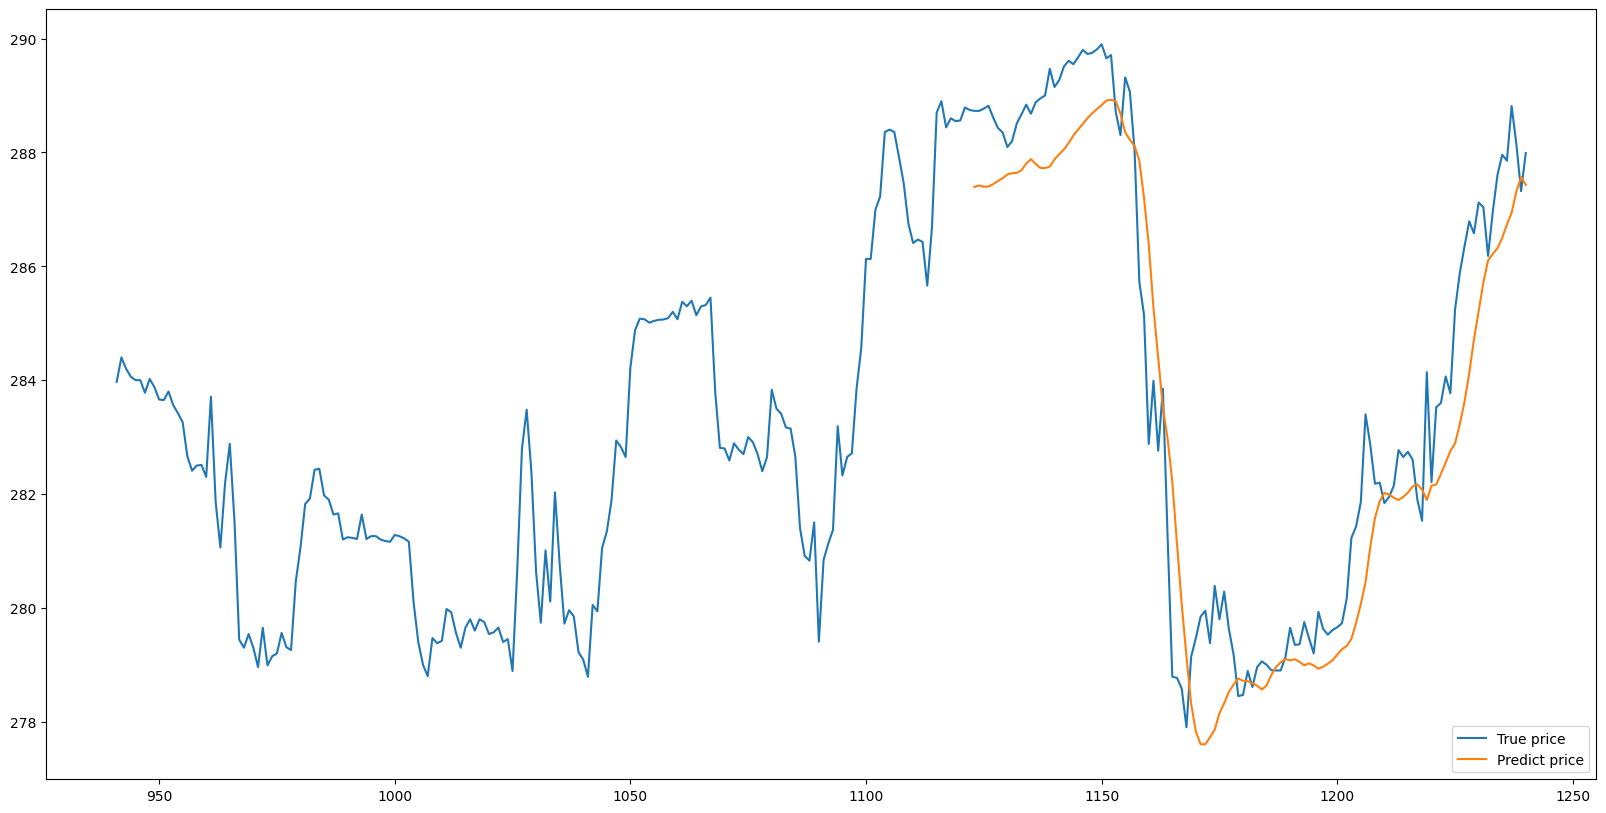

In [28]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20
30/30 [==============================] - 7s 99ms/step - loss: 0.0231 - val_loss: 0.0048
Epoch 2/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0037 - val_loss: 0.0058
Epoch 3/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0028 - val_loss: 0.0045
Epoch 4/20
30/30 [==============================] - 2s 74ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 5/20
30/30 [==============================] - 2s 74ms/step - loss: 0.0021 - val_loss: 0.0047
Epoch 6/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 7/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 8/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0017 - val_loss: 0.0042
Epoch 9/20
30/30 [==============================] - 2s 68ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 10/20
30/30 [==============================] - 2s 67ms/step - loss: 0.0015 - val_loss: 0.0028
Epoch 11/

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\2478985766.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


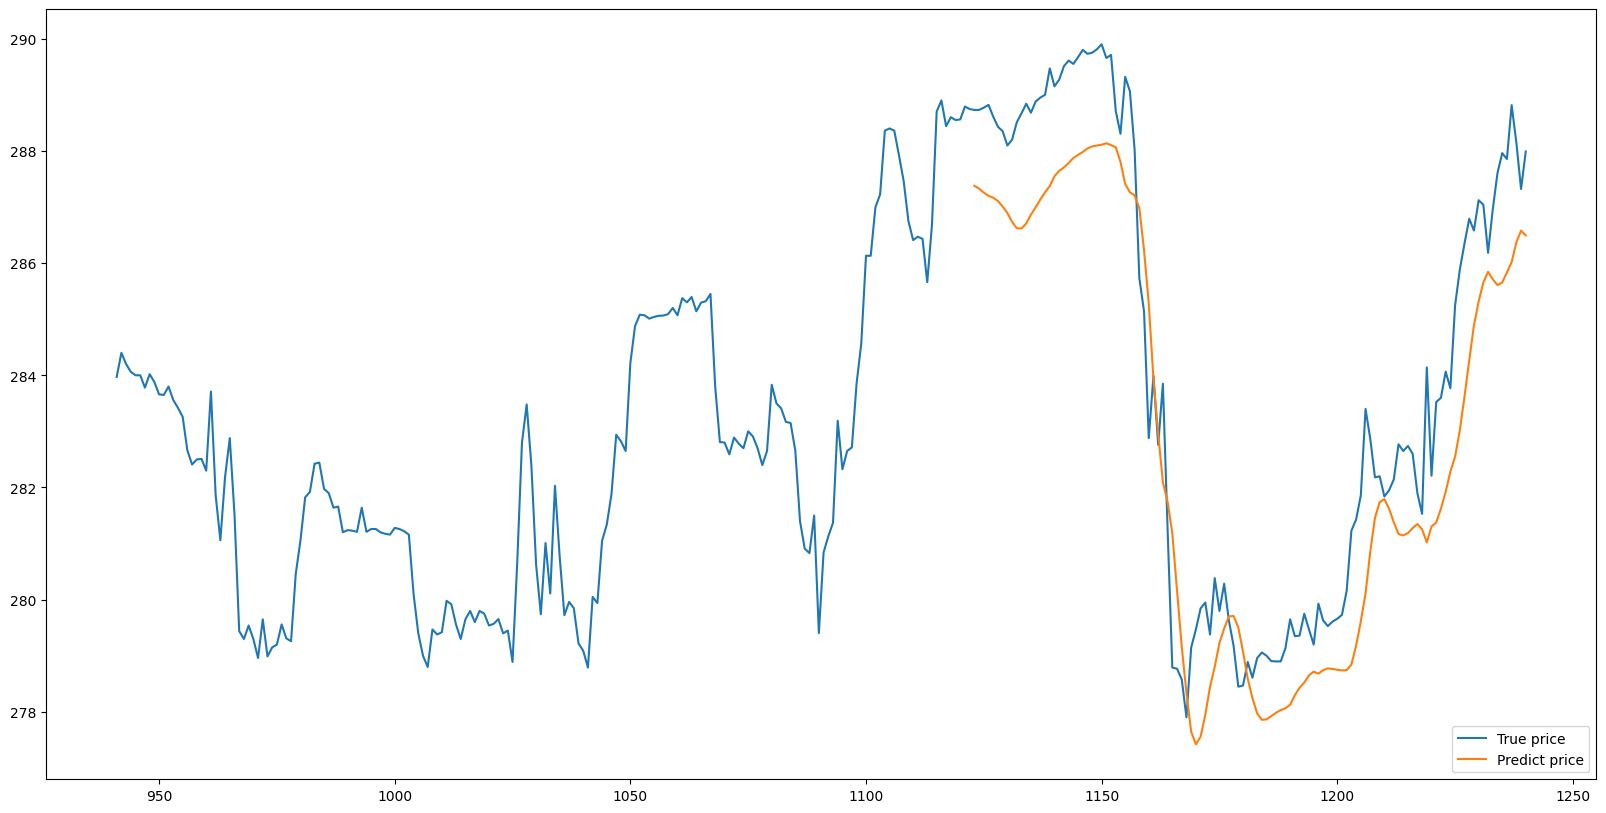

In [29]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/20
30/30 [==============================] - 7s 85ms/step - loss: 0.0444 - val_loss: 0.0035
Epoch 2/20
30/30 [==============================] - 2s 58ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 3/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 4/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 5/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 6/20
30/30 [==============================] - 2s 58ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 7/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 8/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 9/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 10/20
30/30 [==============================] - 2s 56ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 11/

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\2854864207.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


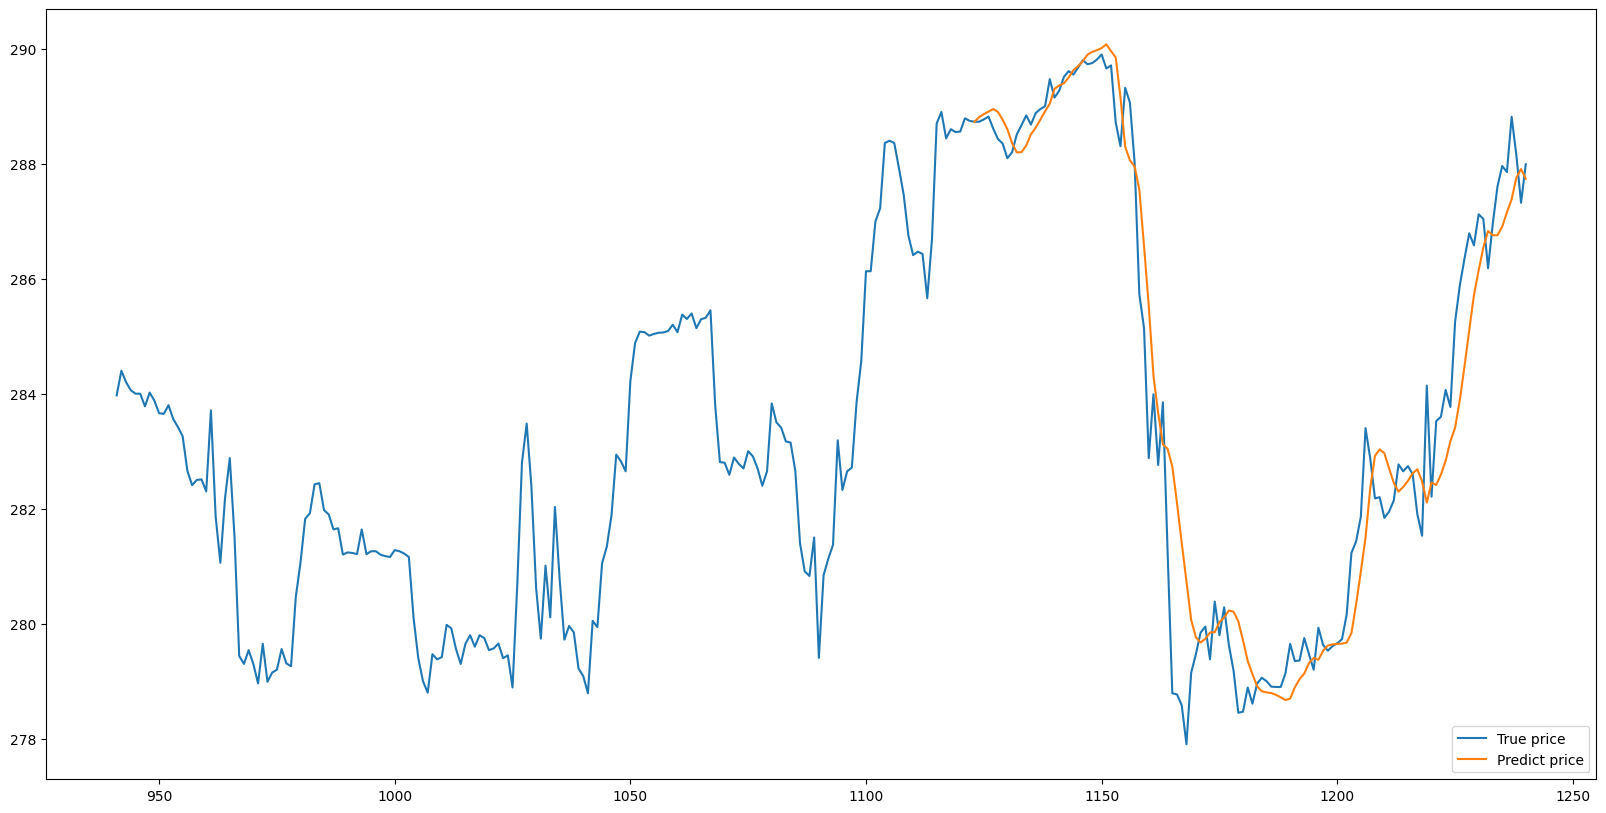

In [30]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/20
30/30 [==============================] - 8s 103ms/step - loss: 0.0325 - val_loss: 0.0066
Epoch 2/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0052 - val_loss: 0.0063
Epoch 3/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0037 - val_loss: 0.0064
Epoch 4/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 5/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0024 - val_loss: 0.0037
Epoch 6/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0022 - val_loss: 0.0055
Epoch 7/20
30/30 [==============================] - 2s 70ms/step - loss: 0.0019 - val_loss: 0.0046
Epoch 8/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0017 - val_loss: 0.0041
Epoch 9/20
30/30 [==============================] - 2s 70ms/step - loss: 0.0017 - val_loss: 0.0027
Epoch 10/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\976809281.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


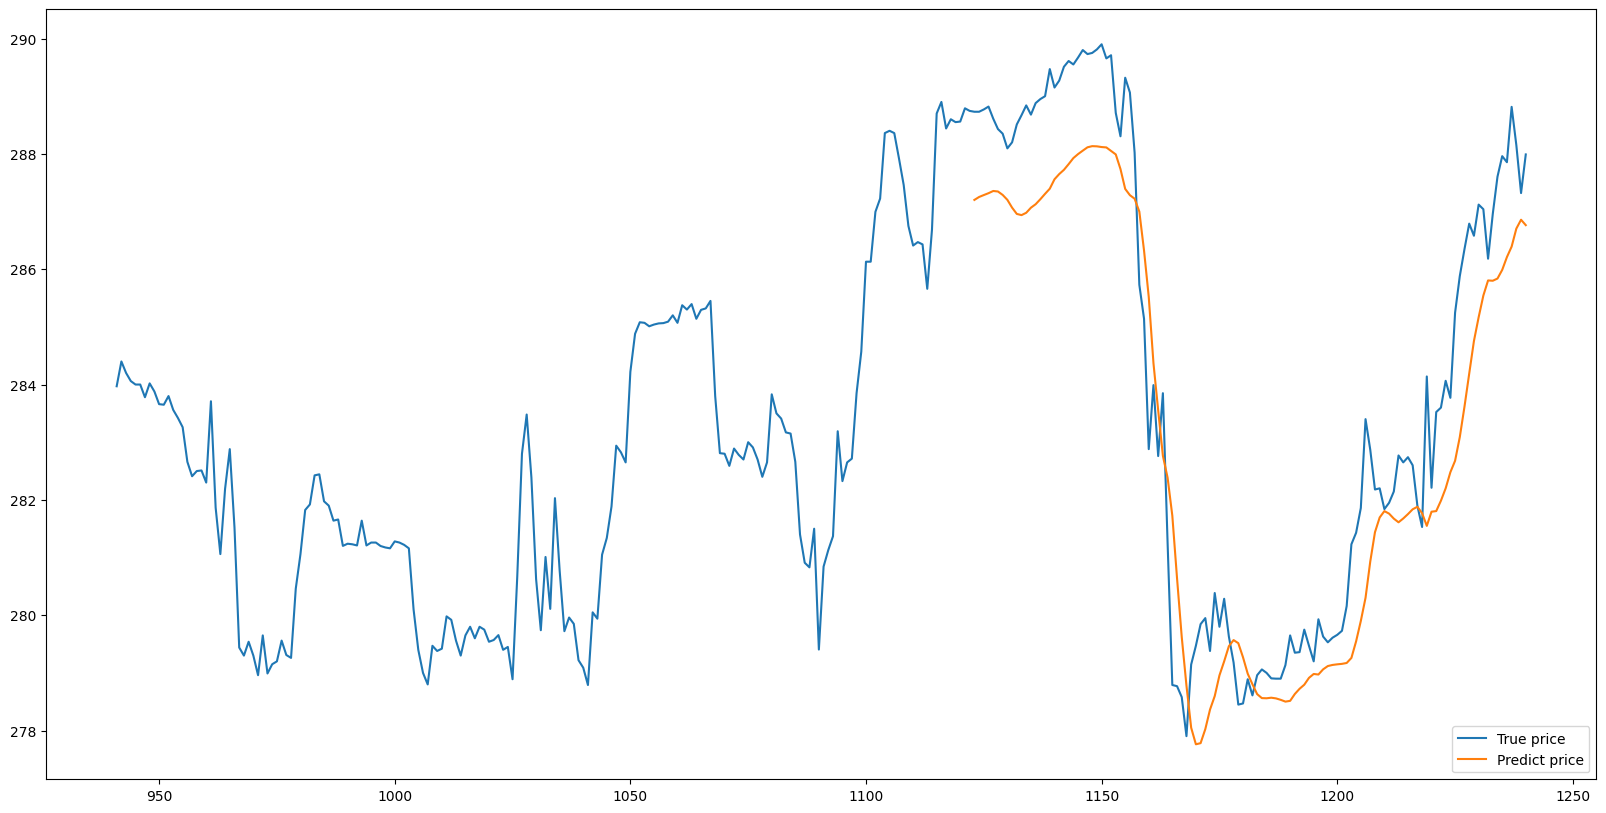

In [31]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20
30/30 [==============================] - 7s 100ms/step - loss: 0.0195 - val_loss: 0.0171
Epoch 2/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 3/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 4/20
30/30 [==============================] - 2s 67ms/step - loss: 0.0023 - val_loss: 0.0051
Epoch 5/20
30/30 [==============================] - 2s 68ms/step - loss: 0.0020 - val_loss: 0.0053
Epoch 6/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 7/20
30/30 [==============================] - 2s 70ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 8/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 9/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 10/20
30/30 [==============================] - 2s 70ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\610689180.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


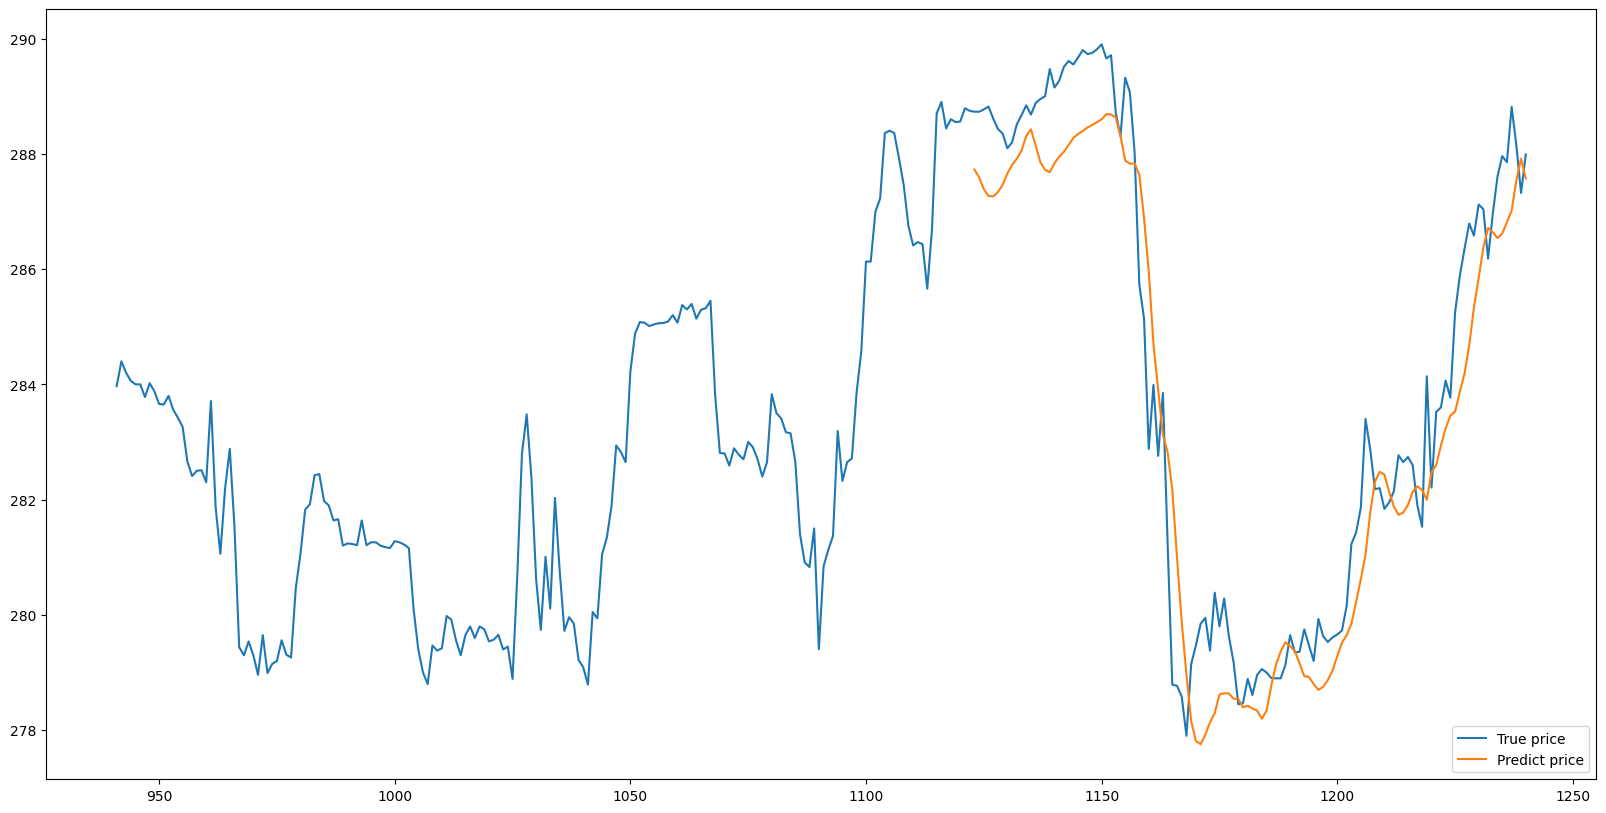

In [32]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
30/30 [==============================] - 7s 103ms/step - loss: 0.0297 - val_loss: 0.0065
Epoch 2/20
30/30 [==============================] - 2s 74ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 3/20
30/30 [==============================] - 2s 74ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 4/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 5/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 6/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 7/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 8/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 9/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 10/20
30/30 [==============================] - 2s 75ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\3727467000.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


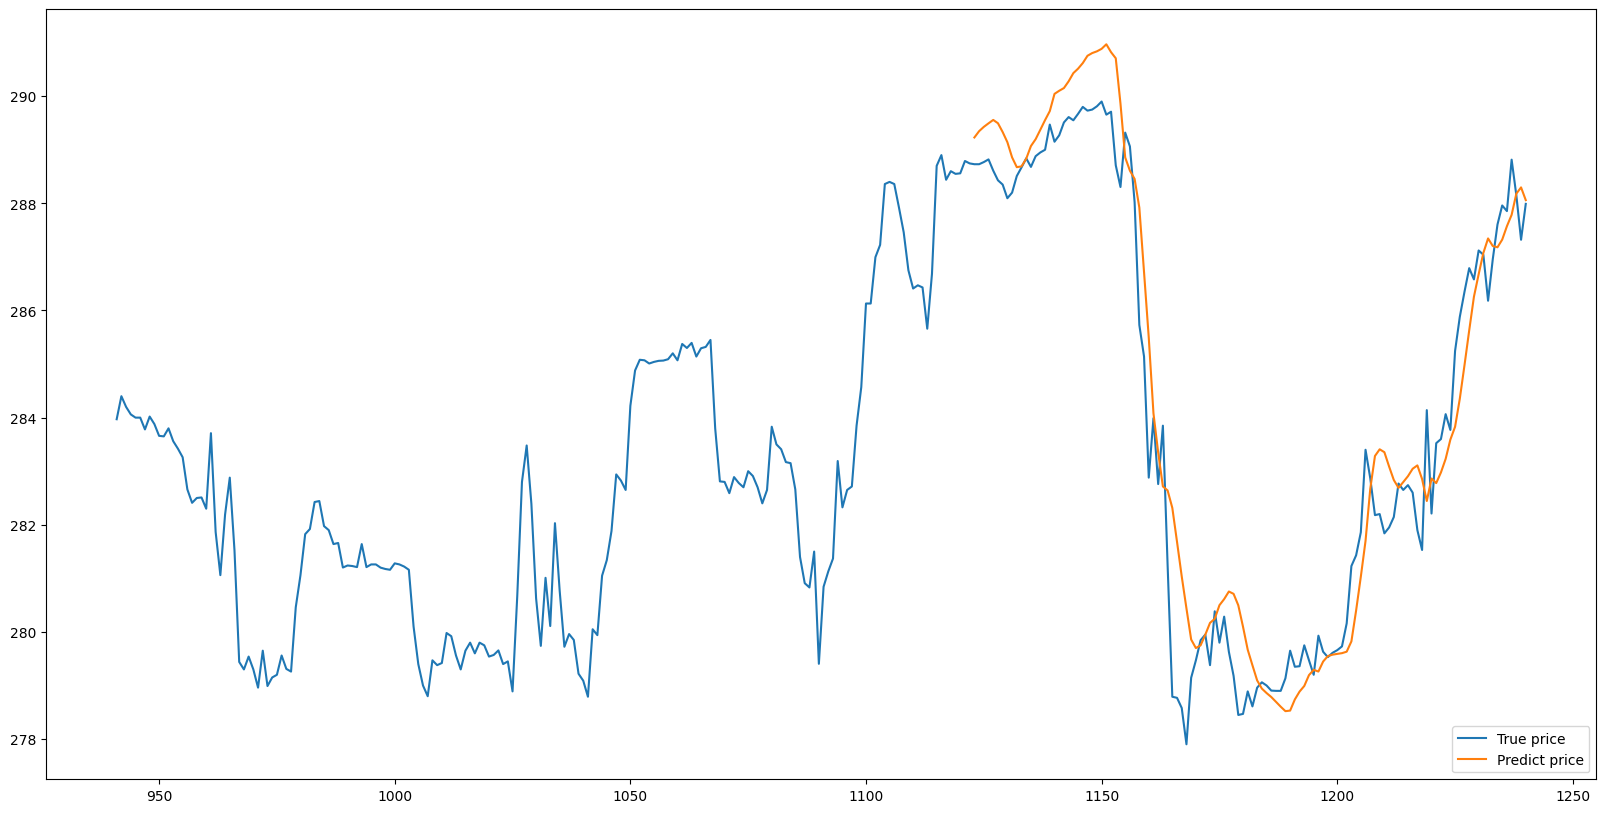

In [33]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
30/30 [==============================] - 9s 129ms/step - loss: 0.0273 - val_loss: 0.0072
Epoch 2/20
30/30 [==============================] - 3s 101ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 3/20
30/30 [==============================] - 3s 106ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 4/20
30/30 [==============================] - 3s 100ms/step - loss: 0.0035 - val_loss: 0.0069
Epoch 5/20
30/30 [==============================] - 3s 102ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 6/20
30/30 [==============================] - 3s 98ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 7/20
30/30 [==============================] - 3s 98ms/step - loss: 0.0025 - val_loss: 0.0059
Epoch 8/20
30/30 [==============================] - 3s 98ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 9/20
30/30 [==============================] - 3s 99ms/step - loss: 0.0019 - val_loss: 0.0036
Epoch 10/20
30/30 [==============================] - 3s 98ms/step - loss: 0.0017 - val_loss: 0.0031
Epoc

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\794696673.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


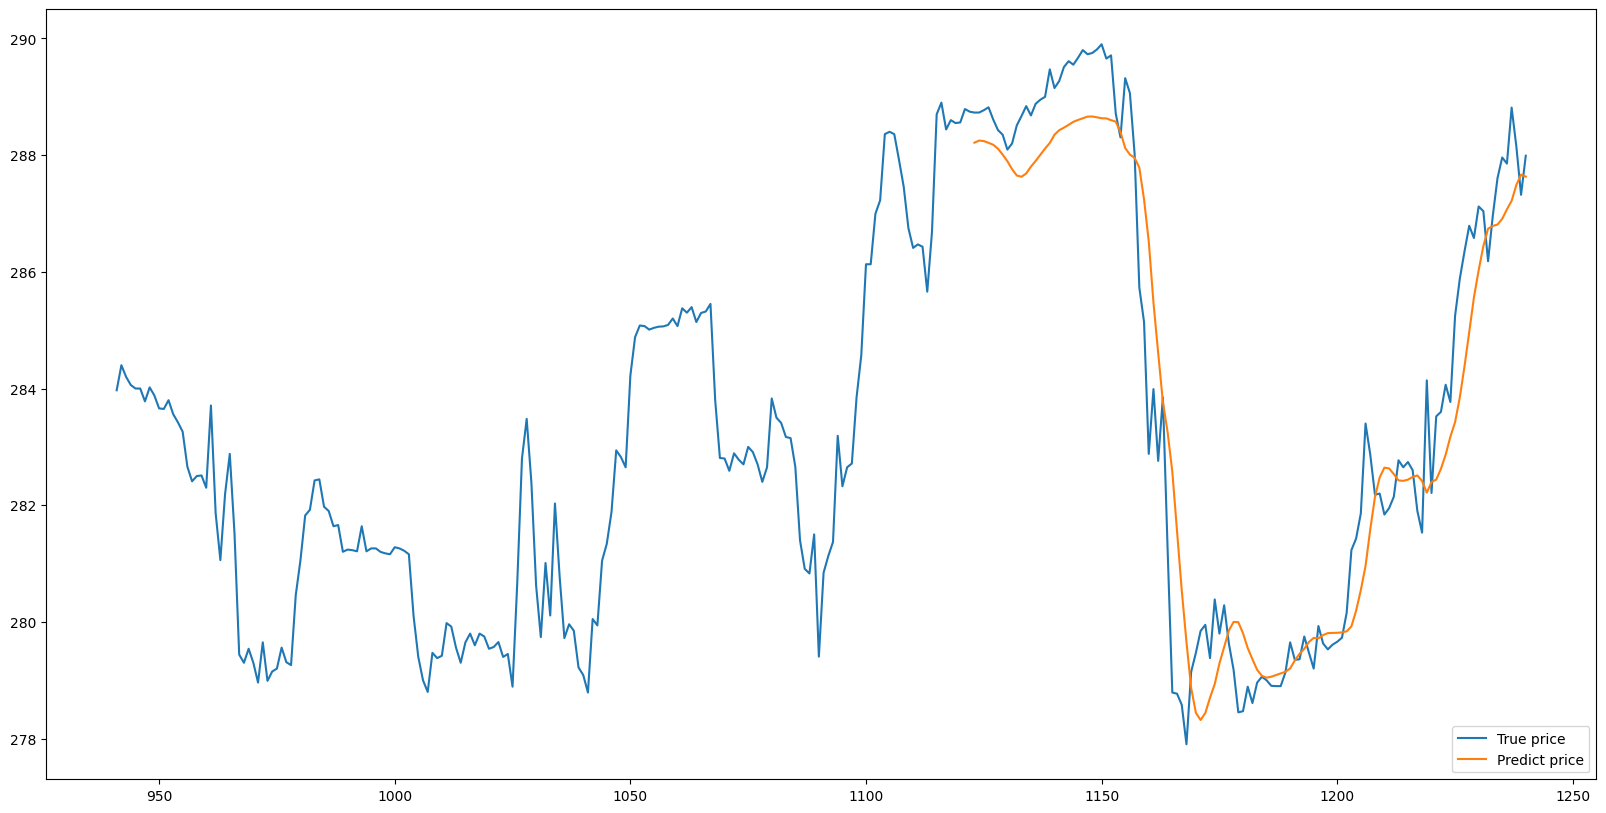

In [34]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
30/30 [==============================] - 8s 114ms/step - loss: 0.0249 - val_loss: 0.0048
Epoch 2/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 3/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 4/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 5/20
30/30 [==============================] - 2s 83ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 6/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 7/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 8/20
30/30 [==============================] - 2s 83ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 9/20
30/30 [==============================] - 2s 82ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 10/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\3631243799.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


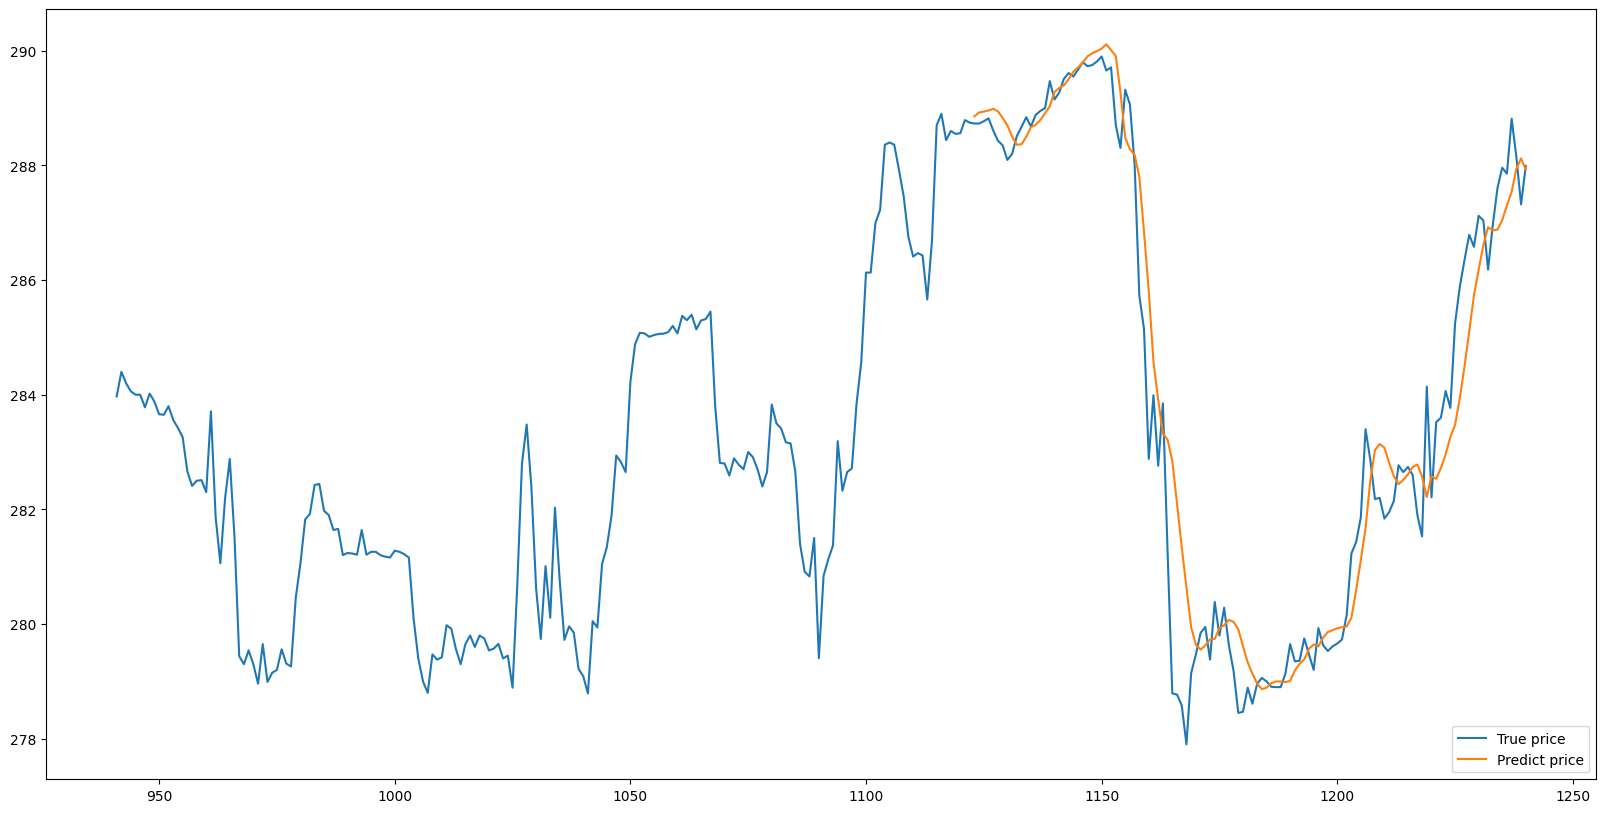

In [35]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20
30/30 [==============================] - 8s 118ms/step - loss: 0.0391 - val_loss: 0.0057
Epoch 2/20
30/30 [==============================] - 3s 90ms/step - loss: 0.0043 - val_loss: 0.0062
Epoch 3/20
30/30 [==============================] - 3s 89ms/step - loss: 0.0030 - val_loss: 0.0053
Epoch 4/20
30/30 [==============================] - 3s 88ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 5/20
30/30 [==============================] - 3s 88ms/step - loss: 0.0022 - val_loss: 0.0037
Epoch 6/20
30/30 [==============================] - 3s 89ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 7/20
30/30 [==============================] - 3s 88ms/step - loss: 0.0020 - val_loss: 0.0034
Epoch 8/20
30/30 [==============================] - 3s 88ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 9/20
30/30 [==============================] - 3s 91ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 10/20
30/30 [==============================] - 3s 90ms/step - loss: 0.0021 - val_loss: 0.0048
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\918472296.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


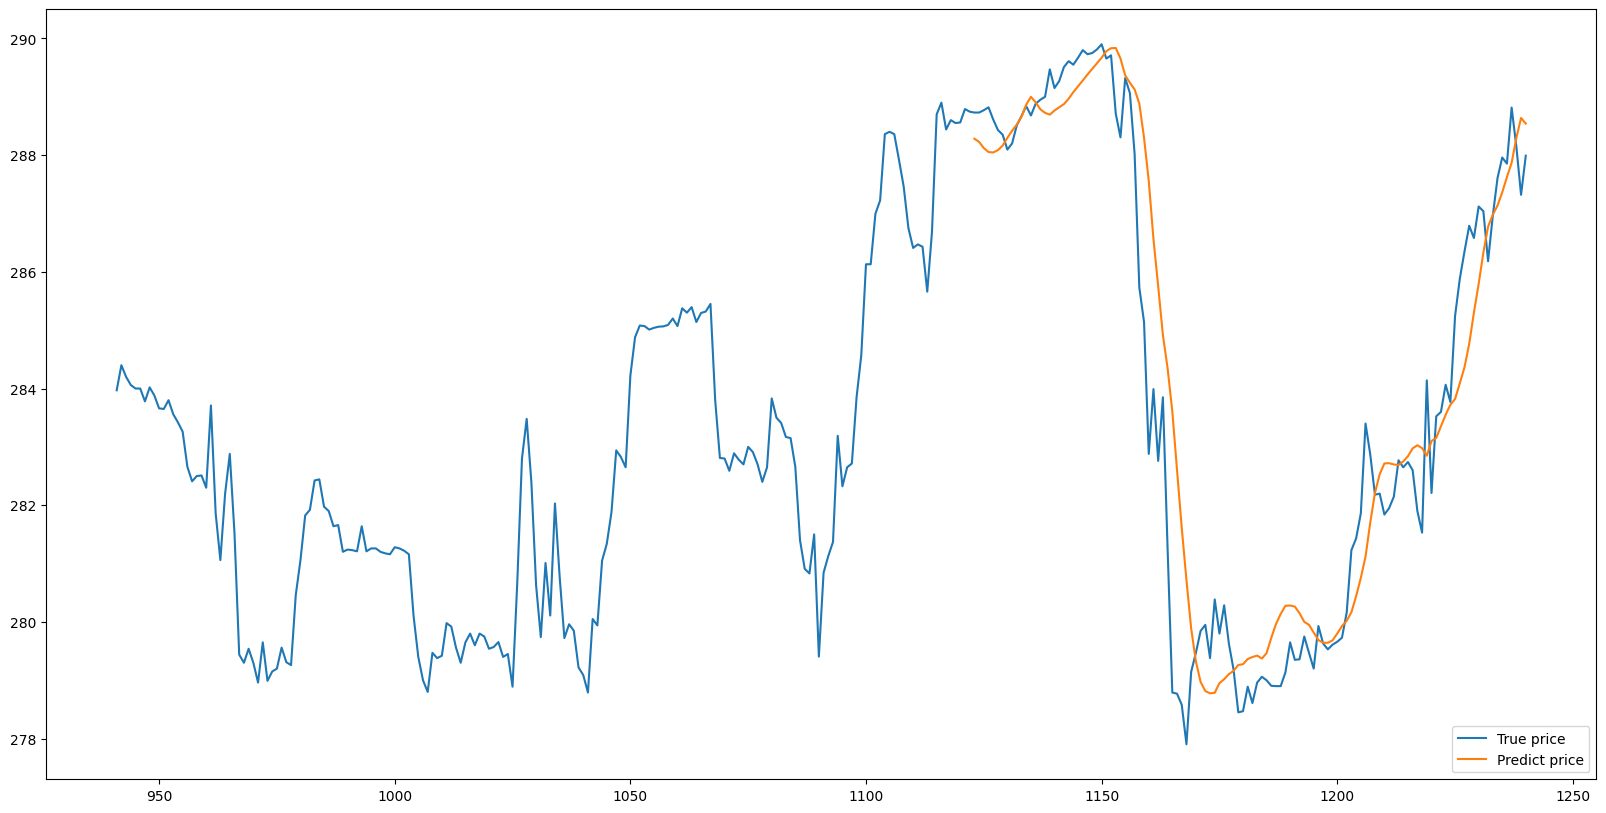

In [36]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
30/30 [==============================] - 7s 103ms/step - loss: 0.0239 - val_loss: 0.0067
Epoch 2/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 3/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 4/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 5/20
30/30 [==============================] - 2s 75ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 6/20
30/30 [==============================] - 2s 79ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 7/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 8/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 9/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 10/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\2086726756.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


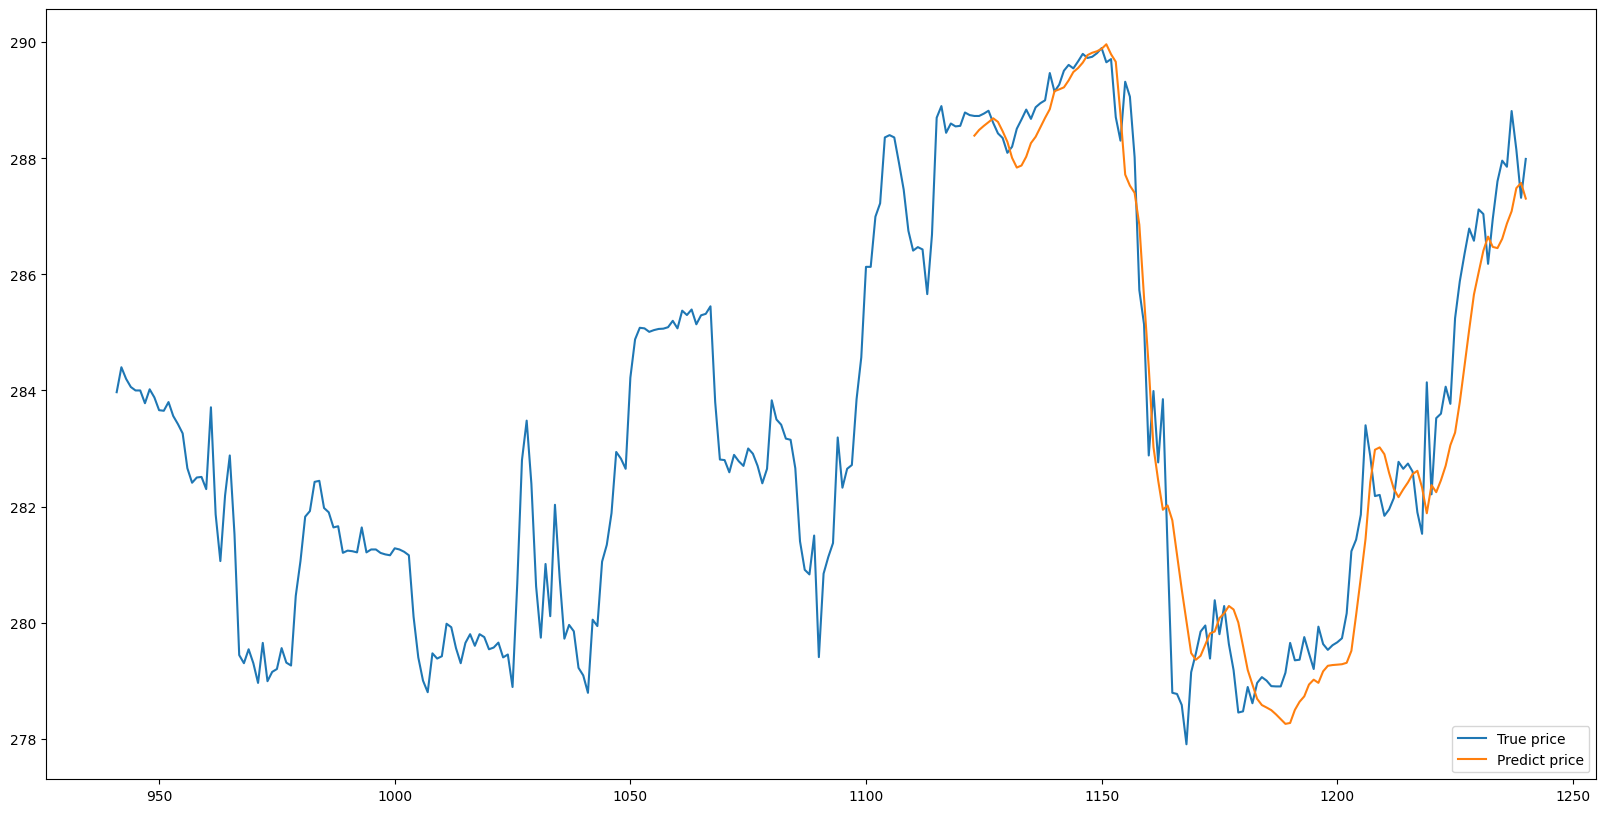

In [37]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
30/30 [==============================] - 8s 110ms/step - loss: 0.0249 - val_loss: 0.0146
Epoch 2/20
30/30 [==============================] - 2s 78ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 3/20
30/30 [==============================] - 2s 78ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 4/20
30/30 [==============================] - 2s 79ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 5/20
30/30 [==============================] - 2s 78ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 6/20
30/30 [==============================] - 2s 79ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 7/20
30/30 [==============================] - 2s 79ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 8/20
30/30 [==============================] - 2s 78ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 9/20
30/30 [==============================] - 2s 78ms/step - loss: 0.0014 - val_loss: 0.0029
Epoch 10/20
30/30 [==============================] - 2s 78ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\3900059495.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


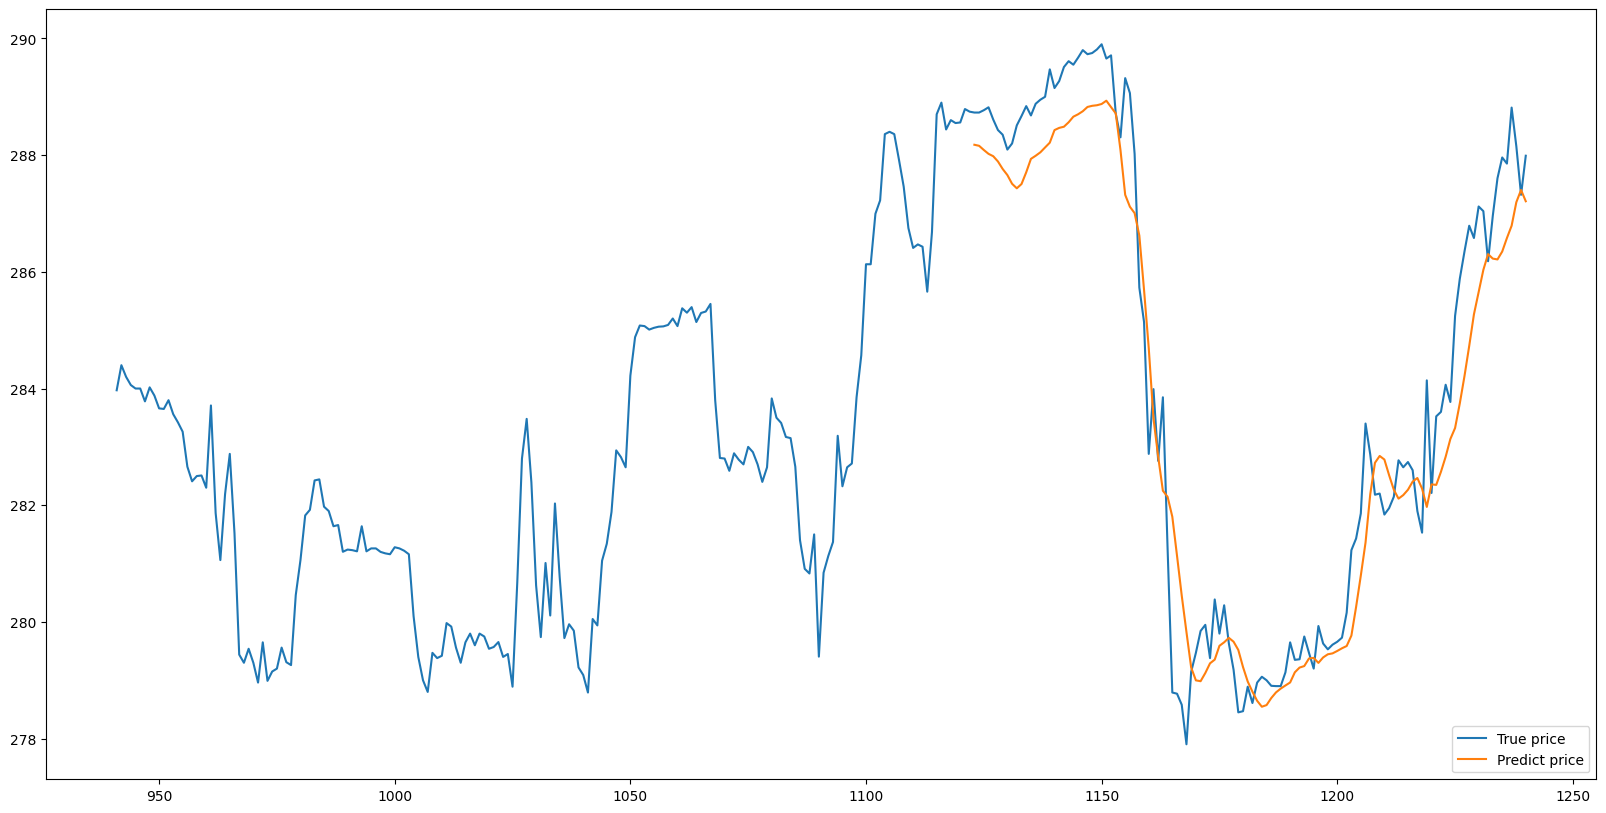

In [38]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
30/30 [==============================] - 8s 113ms/step - loss: 0.0349 - val_loss: 0.0056
Epoch 2/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0055 - val_loss: 0.0089
Epoch 3/20
30/30 [==============================] - 2s 82ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 4/20
30/30 [==============================] - 2s 82ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 5/20
30/30 [==============================] - 2s 83ms/step - loss: 0.0020 - val_loss: 0.0030
Epoch 6/20
30/30 [==============================] - 3s 90ms/step - loss: 0.0018 - val_loss: 0.0039
Epoch 7/20
30/30 [==============================] - 3s 90ms/step - loss: 0.0018 - val_loss: 0.0066
Epoch 8/20
30/30 [==============================] - 3s 91ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 9/20
30/30 [==============================] - 3s 87ms/step - loss: 0.0015 - val_loss: 0.0024
Epoch 10/20
30/30 [==============================] - 3s 84ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\1789390124.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


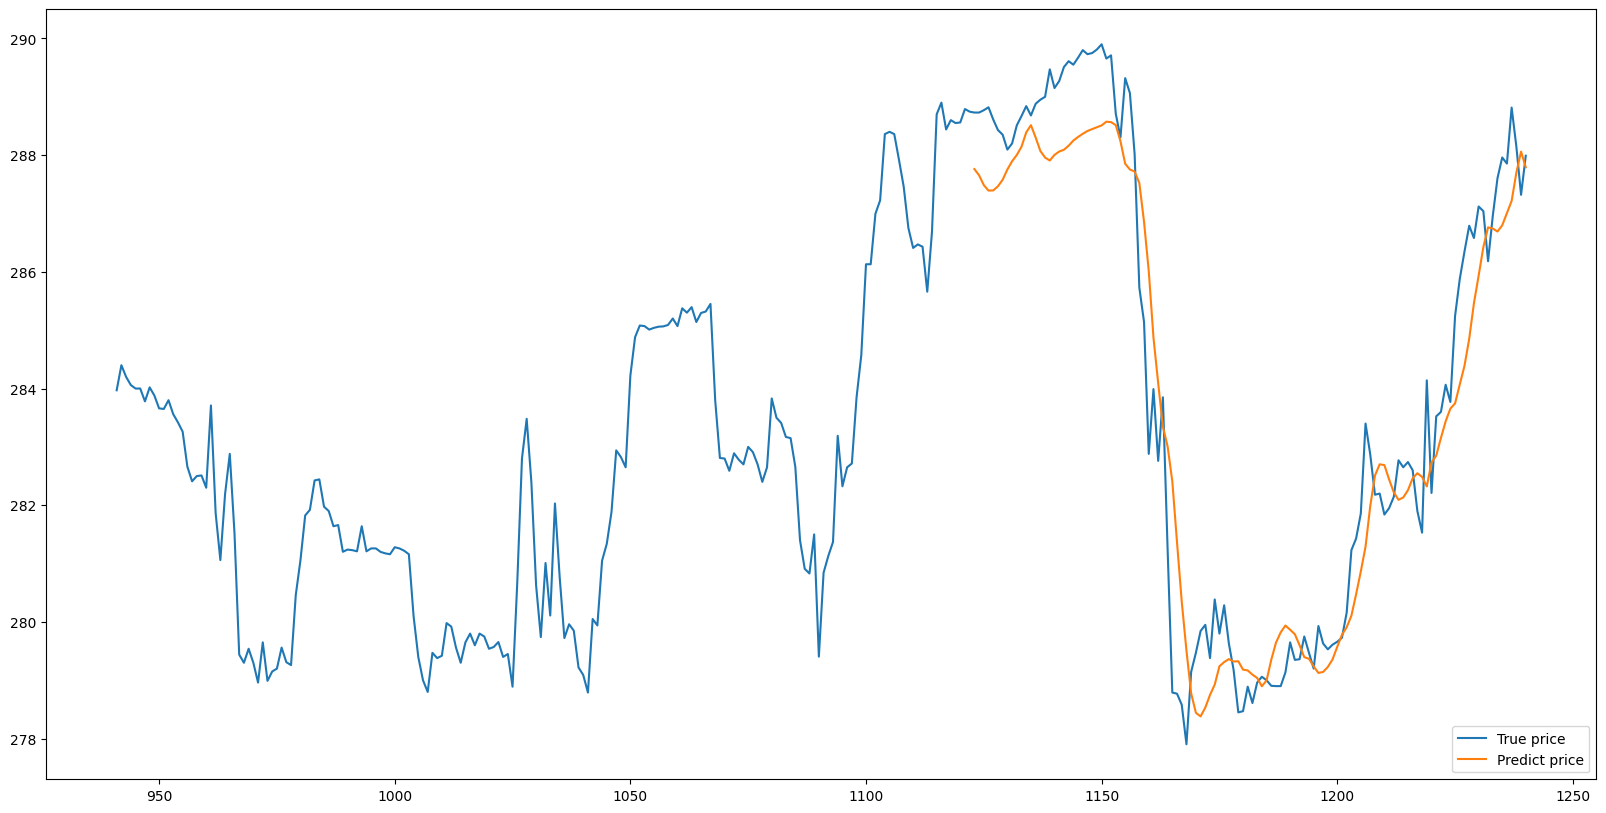

In [39]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
30/30 [==============================] - 7s 97ms/step - loss: 0.0131 - val_loss: 0.0052
Epoch 2/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 3/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 4/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 5/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 6/20
30/30 [==============================] - 2s 70ms/step - loss: 0.0012 - val_loss: 0.0023
Epoch 7/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0012 - val_loss: 0.0044
Epoch 8/20
30/30 [==============================] - 2s 73ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 10/20
30/30 [==============================] - 2s 69ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 11/

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\3095690293.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


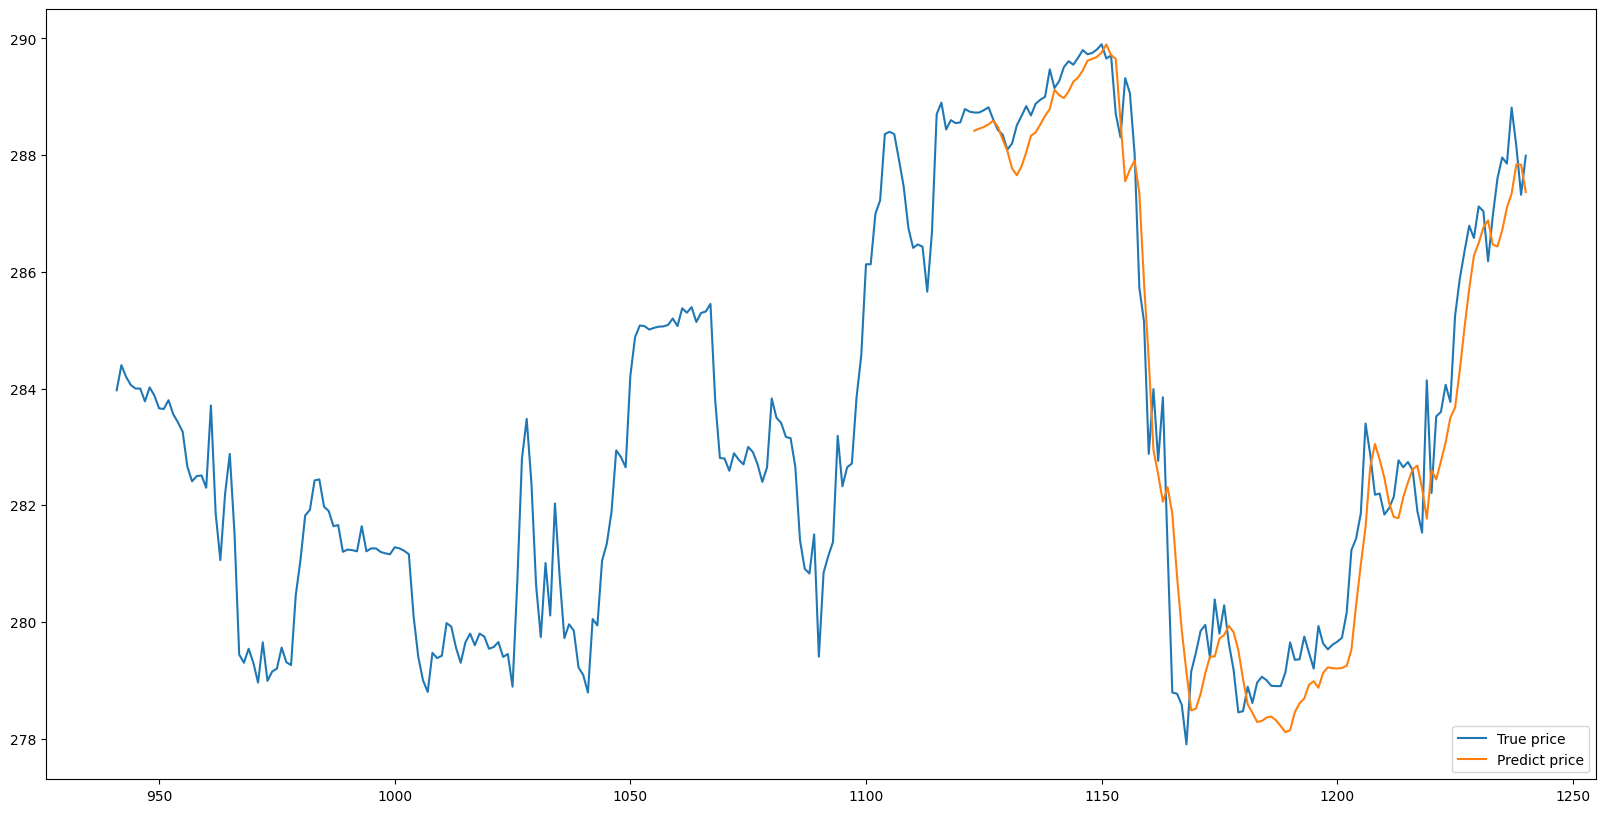

In [40]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
30/30 [==============================] - 8s 120ms/step - loss: 0.0210 - val_loss: 0.0175
Epoch 2/20
30/30 [==============================] - 3s 91ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 3/20
30/30 [==============================] - 3s 86ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 4/20
30/30 [==============================] - 3s 86ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 5/20
30/30 [==============================] - 3s 86ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 6/20
30/30 [==============================] - 3s 90ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 7/20
30/30 [==============================] - 3s 86ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 8/20
30/30 [==============================] - 3s 86ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 9/20
30/30 [==============================] - 3s 87ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 10/20
30/30 [==============================] - 3s 87ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\3871568780.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


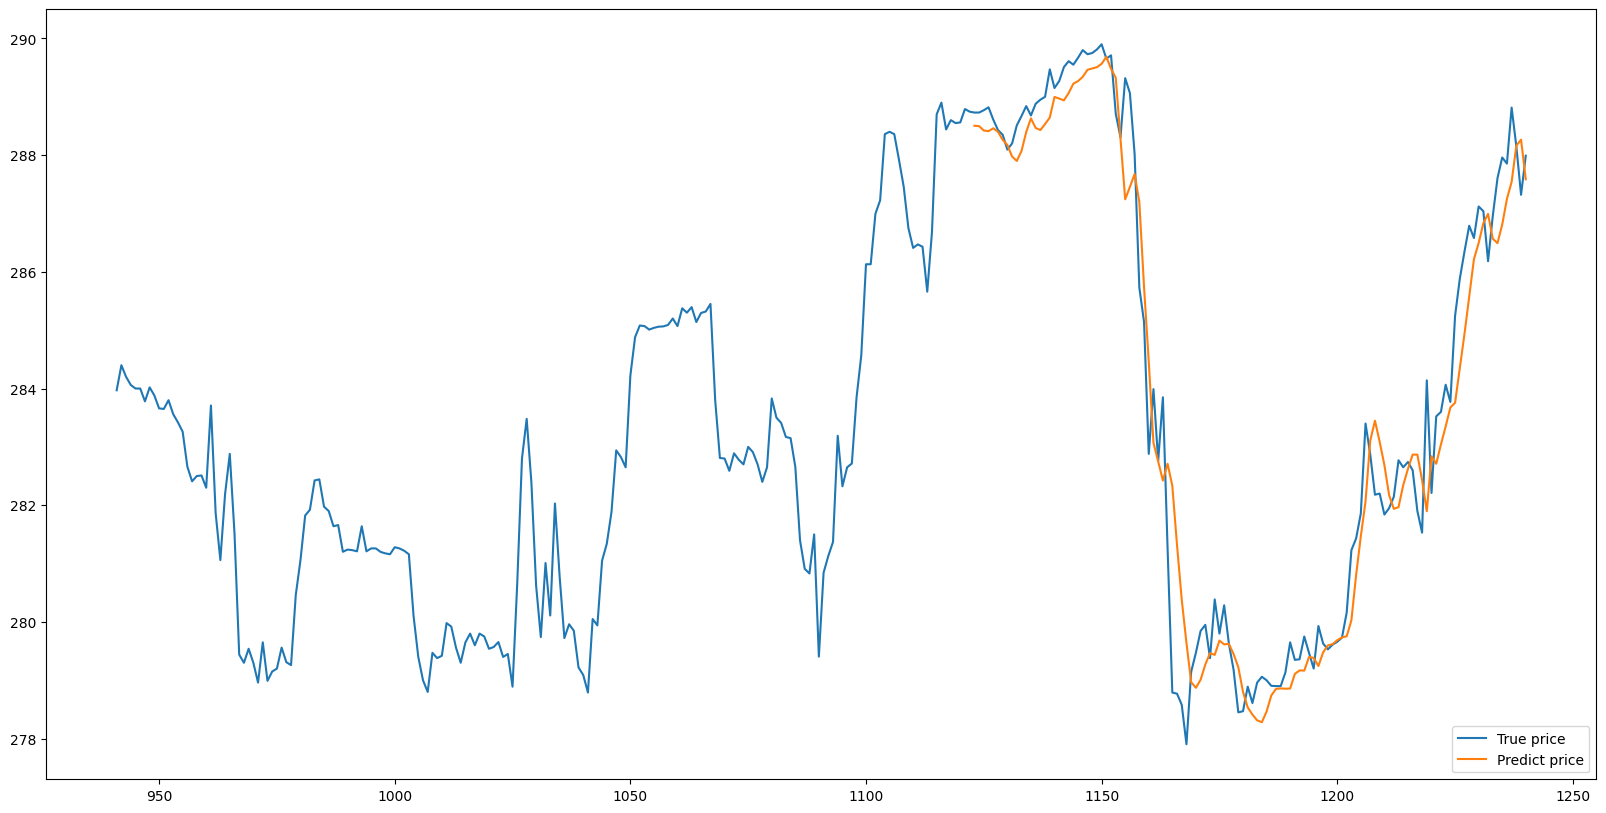

In [41]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
30/30 [==============================] - 8s 120ms/step - loss: 0.0391 - val_loss: 0.0062
Epoch 2/20
30/30 [==============================] - 3s 91ms/step - loss: 0.0060 - val_loss: 0.0097
Epoch 3/20
30/30 [==============================] - 3s 92ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 4/20
30/30 [==============================] - 3s 92ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 5/20
30/30 [==============================] - 3s 91ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 6/20
30/30 [==============================] - 3s 92ms/step - loss: 0.0018 - val_loss: 0.0040
Epoch 7/20
30/30 [==============================] - 3s 92ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 8/20
30/30 [==============================] - 3s 92ms/step - loss: 0.0015 - val_loss: 0.0022
Epoch 9/20
30/30 [==============================] - 3s 90ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 10/20
30/30 [==============================] - 3s 93ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 11

C:\Users\DELL\AppData\Local\Temp\ipykernel_1776\2282918751.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


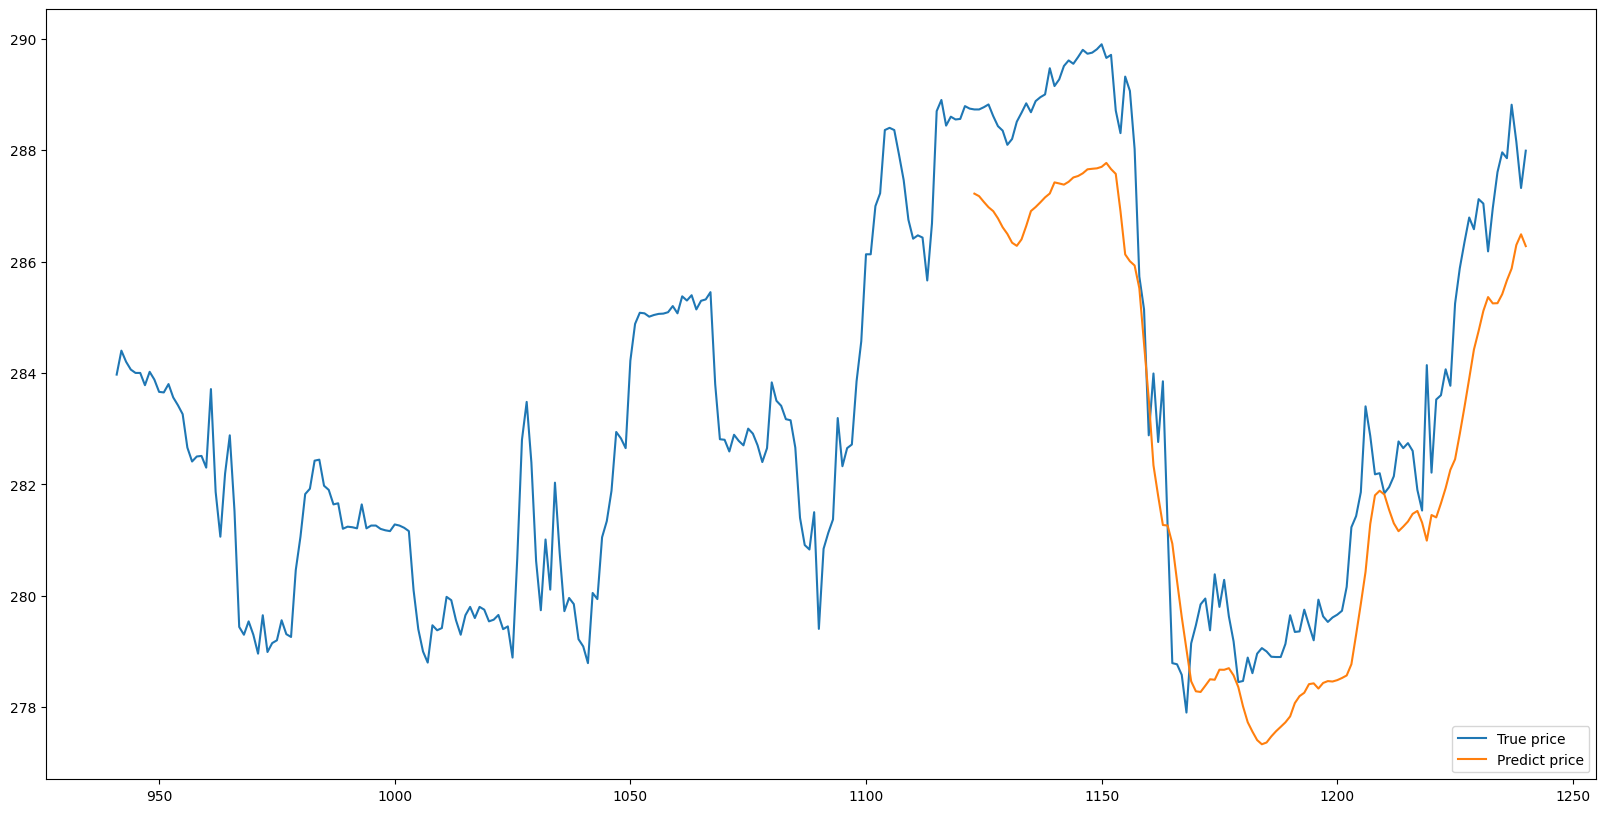

In [42]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [43]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [44]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[267.295],
       [265.11 ],
       [265.8  ],
       ...,
       [288.15 ],
       [287.32 ],
       [287.99 ]])

In [45]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.24042339],
       [0.16700269],
       [0.19018817],
       ...,
       [0.94119624],
       [0.91330645],
       [0.93581989]])

In [46]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1181
1181


In [47]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (945, 60, 1)
Size validate:  (118, 60, 1)
Size test:  (118, 60, 1)


### b. Train Model

In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
30/30 [==============================] - 17s 255ms/step - loss: 0.0442 - val_loss: 0.0324
Epoch 2/25
30/30 [==============================] - 6s 191ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 3/25


30/30 [==============================] - 7s 227ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 4/25
30/30 [==============================] - 6s 203ms/step - loss: 0.0067 - val_loss: 0.0084
Epoch 5/25
30/30 [==============================] - 6s 203ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 6/25
30/30 [==============================] - 6s 210ms/step - loss: 0.0058 - val_loss: 0.0078
Epoch 7/25
30/30 [==============================] - 6s 206ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 8/25
30/30 [==============================] - 6s 204ms/step - loss: 0.0052 - val_loss: 0.0064
Epoch 9/25
30/30 [==============================] - 6s 206ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 10/25
30/30 [==============================] - 6s 207ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 11/25
30/30 [==============================] - 6s 203ms/step - loss: 0.0062 - val_loss: 0.0171
Epoch 12/25
30/30 [==============================] - 6s 205ms/step - loss: 0.0059 - val_loss: 0.0085
Epoch 13

### c. Test Model

In [ ]:
model_rnn = load_model('./MODEL/RNN.h5')

In [ ]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

4/4 [==============================] - 2s 32ms/step


In [ ]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date     open    high     low    close    volume     ROC  \
1066  2023-06-22 19:30:00  285.250  285.58  285.07  285.320    3810.0  1.2186   
1067  2023-06-22 19:45:00  285.350  285.75  285.15  285.450    8218.0  0.8871   
1068  2023-06-23 04:00:00  284.500  284.78  283.52  283.800    2557.0  0.3447   
1069  2023-06-23 04:15:00  283.770  283.88  282.66  282.810    4916.0  0.0566   
1070  2023-06-23 04:30:00  282.830  283.16  282.53  282.800    3051.0 -0.4996   
...                   ...      ...     ...     ...      ...       ...     ...   
1172  2023-06-26 14:00:00  279.780  280.29  279.50  279.950  404915.0 -3.3689   
1173  2023-06-26 14:15:00  279.955  280.32  279.00  279.380  505468.0 -3.2316   
1174  2023-06-26 14:30:00  279.380  280.74  279.38  280.385  533132.0 -2.7471   
1175  2023-06-26 14:45:00  280.450  280.54  279.78  279.800  375024.0 -3.2905   
1176  2023-06-26 15:00:00  279.830  280.38  279.79  280.285  370860.0 -3.0367   

           SMA      RSI  Real Upper Band  Real Middle Band  Real Lower Band  \
1066  284.7512  64.8560       286.426915          284.7512       283.075485   
1067  284.8767  65.5176       286.374972          284.8767       283.378428   
1068  284.9255  52.3509       286.263611          284.9255       283.587389   
1069  284.9335  46.4546       286.419503          284.9335       283.447497   
1070  284.8625  46.3990       286.387521          284.8625       283.337479   
...        ...      ...              ...               ...              ...   
1172  283.0736  32.8736       285.327285          283.0736       280.819915   
1173  282.6071  31.4967       284.845445          282.6071       280.368755   
1174  282.2111  36.4378       284.452321          282.2111       279.969879   
1175  281.7351  34.8956       283.940167          281.7351       279.530033   
1176  281.2962  37.2146       283.470819          281.2962       279.121581   

      predictions  
1066   285.537323  
1067   285.504852  
1068   285.488800  
1069   285.449860  
1070   285.336273  
...           ...  
1172   279.478027  
1173   279.171936  
1174   279.061340  
1175   279.125488  
1176   279.316132  

[111 rows x 13 columns]

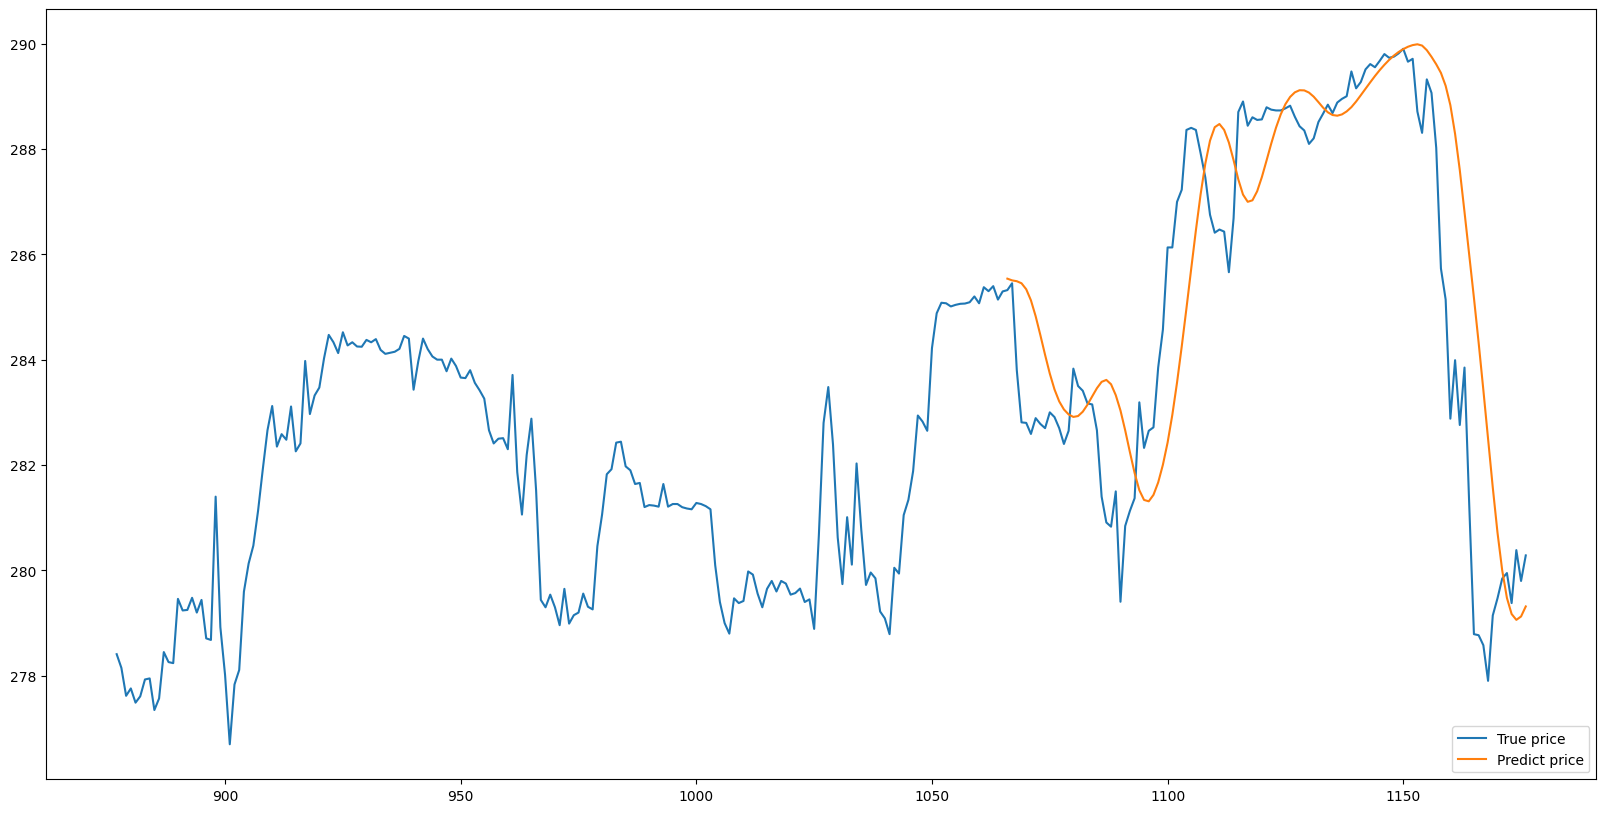

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.67295e+02,  6.15400e-01],
       [ 2.65110e+02, -2.44600e-01],
       [ 2.65800e+02, -2.62700e-01],
       ...,
       [ 2.80385e+02, -2.74710e+00],
       [ 2.79800e+02, -3.29050e+00],
       [ 2.80285e+02, -3.03670e+00]])

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.24042339, 0.60839423],
       [0.16700269, 0.49716096],
       [0.19018817, 0.49481989],
       ...,
       [0.68027554, 0.17348509],
       [0.66061828, 0.10320119],
       [0.67691532, 0.13602794]])

In [ ]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1117
1117


In [ ]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (894, 60, 2)
Size validate:  (112, 60, 2)
Size test:  (111, 60, 2)


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
28/28 [==============================] - 15s 198ms/step - loss: 0.0329 - val_loss: 0.0109
Epoch 2/25
28/28 [==============================] - 3s 113ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 3/25
28/28 [==============================] - 3s 119ms/step - loss: 0.0060 - val_loss: 0.0040
Epoch 4/25
28/28 [==============================] - 3s 112ms/step - loss: 0.0058 - val_loss: 0.0041
Epoch 5/25
28/28 [==============================] - 3s 117ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/25
28/28 [==============================] - 3s 110ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 7/25
28/28 [==============================] - 3s 119ms/step - loss: 0.0053 - val_loss: 0.0050
Epoch 8/25
28/28 [==============================] - 3s 112ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 9/25
28/28 [==============================] - 3s 116ms/step - loss: 0.0053 - val_loss: 0.0085
Epoch 10/25
28/28 [==============================] - 3s 112ms/step - loss: 0.0053 - val_loss: 0.003

In [ ]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [ ]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

4/4 [==============================] - 2s 31ms/step


In [ ]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2018918845.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


date     open    high     low    close    volume     ROC  \
1066  2023-06-22 19:30:00  285.250  285.58  285.07  285.320    3810.0  1.2186   
1067  2023-06-22 19:45:00  285.350  285.75  285.15  285.450    8218.0  0.8871   
1068  2023-06-23 04:00:00  284.500  284.78  283.52  283.800    2557.0  0.3447   
1069  2023-06-23 04:15:00  283.770  283.88  282.66  282.810    4916.0  0.0566   
1070  2023-06-23 04:30:00  282.830  283.16  282.53  282.800    3051.0 -0.4996   
...                   ...      ...     ...     ...      ...       ...     ...   
1172  2023-06-26 14:00:00  279.780  280.29  279.50  279.950  404915.0 -3.3689   
1173  2023-06-26 14:15:00  279.955  280.32  279.00  279.380  505468.0 -3.2316   
1174  2023-06-26 14:30:00  279.380  280.74  279.38  280.385  533132.0 -2.7471   
1175  2023-06-26 14:45:00  280.450  280.54  279.78  279.800  375024.0 -3.2905   
1176  2023-06-26 15:00:00  279.830  280.38  279.79  280.285  370860.0 -3.0367   

           SMA      RSI  Real Upper Band  Real Middle Band  Real Lower Band  \
1066  284.7512  64.8560       286.426915          284.7512       283.075485   
1067  284.8767  65.5176       286.374972          284.8767       283.378428   
1068  284.9255  52.3509       286.263611          284.9255       283.587389   
1069  284.9335  46.4546       286.419503          284.9335       283.447497   
1070  284.8625  46.3990       286.387521          284.8625       283.337479   
...        ...      ...              ...               ...              ...   
1172  283.0736  32.8736       285.327285          283.0736       280.819915   
1173  282.6071  31.4967       284.845445          282.6071       280.368755   
1174  282.2111  36.4378       284.452321          282.2111       279.969879   
1175  281.7351  34.8956       283.940167          281.7351       279.530033   
1176  281.2962  37.2146       283.470819          281.2962       279.121581   

      predictions  
1066   287.173584  
1067   287.074463  
1068   286.953735  
1069   286.782959  
1070   286.534790  
...           ...  
1172   280.679688  
1173   280.296021  
1174   280.077637  
1175   280.018433  
1176   280.067596  

[111 rows x 13 columns]

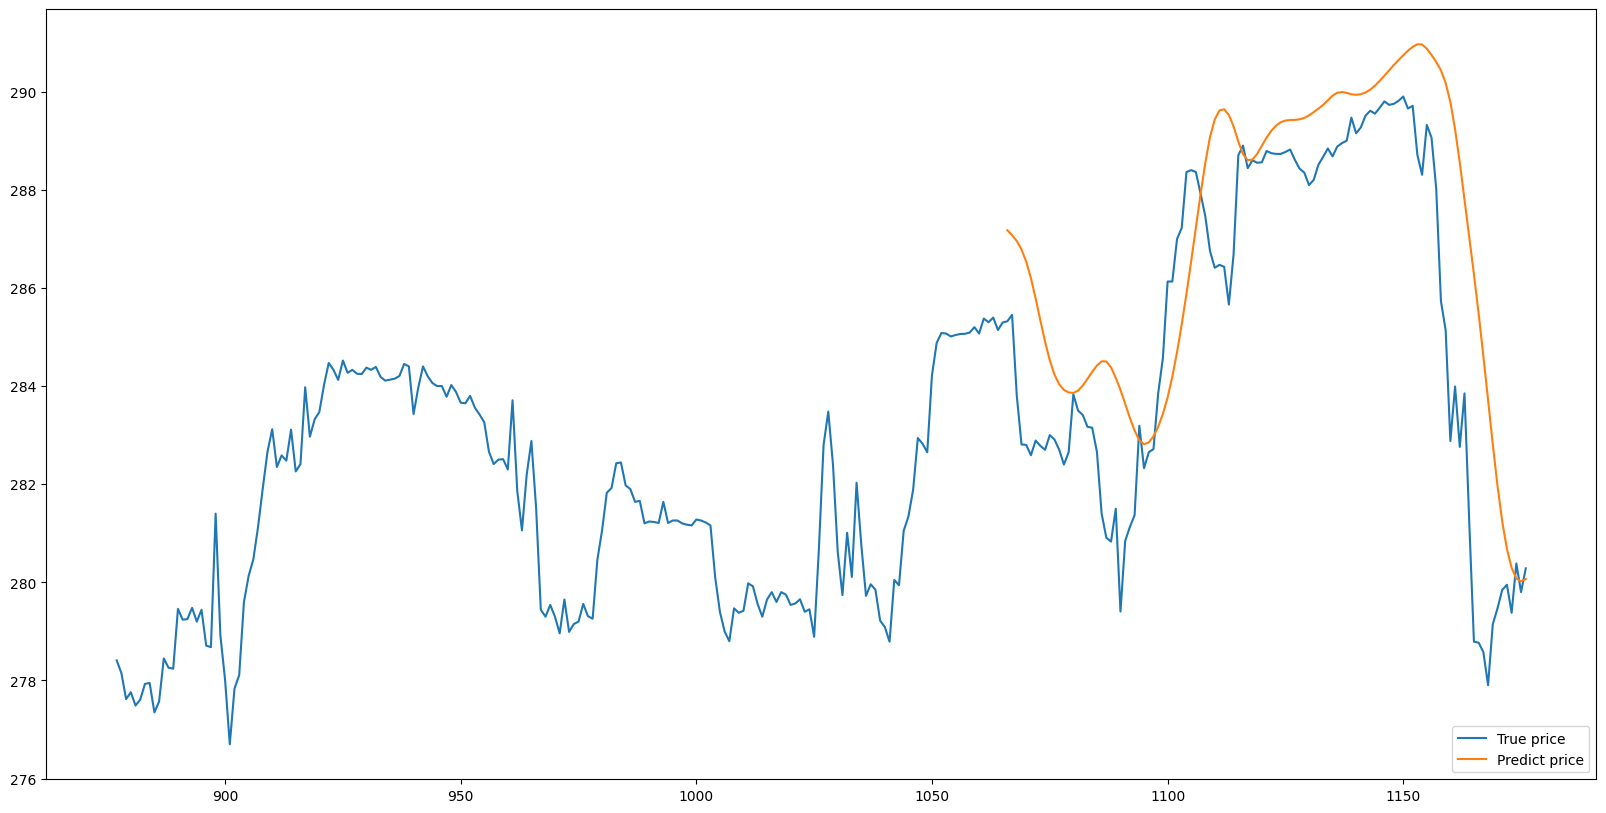

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/25
28/28 [==============================] - 16s 194ms/step - loss: 0.0365 - val_loss: 0.0113
Epoch 2/25
28/28 [==============================] - 3s 113ms/step - loss: 0.0092 - val_loss: 0.0057
Epoch 3/25
28/28 [==============================] - 3s 117ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 4/25
28/28 [==============================] - 3s 111ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 5/25
28/28 [==============================] - 3s 115ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 6/25
28/28 [==============================] - 4s 127ms/step - loss: 0.0058 - val_loss: 0.0075
Epoch 7/25
28/28 [==============================] - 4s 126ms/step - loss: 0.0054 - val_loss: 0.0039
Epoch 8/25
28/28 [==============================] - 3s 113ms/step - loss: 0.0056 - val_loss: 0.0037
Epoch 9/25
28/28 [==============================] - 3s 116ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 10/25
28/28 [==============================] - 3s 111ms/step - loss: 0.0047 - val_loss: 0.003

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\4003201351.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


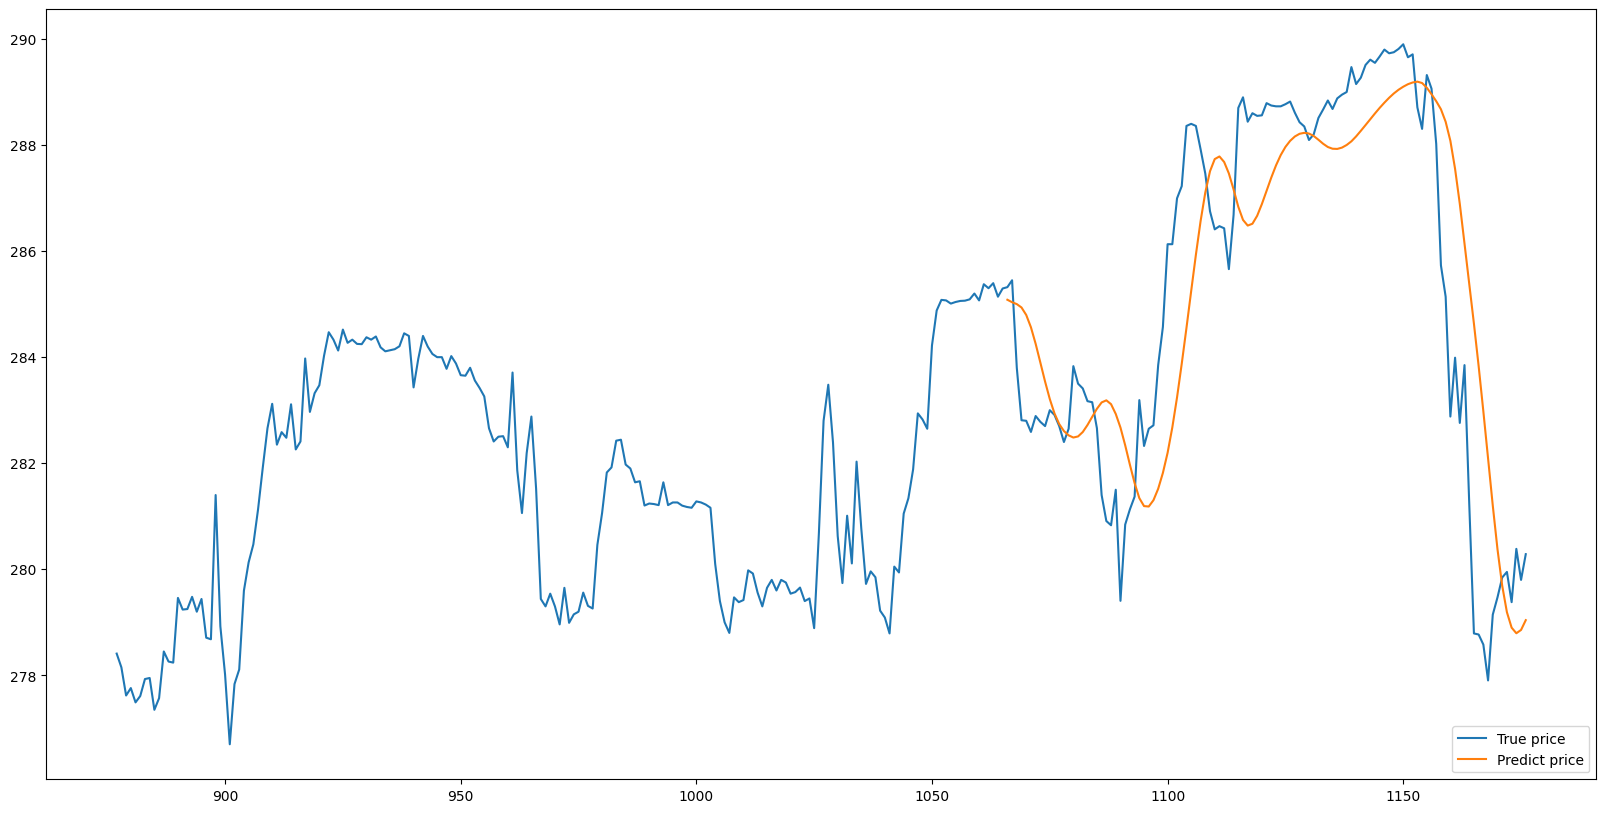

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/25
28/28 [==============================] - 15s 197ms/step - loss: 0.0437 - val_loss: 0.0130
Epoch 2/25
28/28 [==============================] - 3s 112ms/step - loss: 0.0095 - val_loss: 0.0042
Epoch 3/25
28/28 [==============================] - 3s 116ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 4/25
28/28 [==============================] - 3s 111ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 5/25
28/28 [==============================] - 3s 116ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 6/25
28/28 [==============================] - 3s 112ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 7/25
28/28 [==============================] - 3s 117ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/25
28/28 [==============================] - 3s 113ms/step - loss: 0.0061 - val_loss: 0.0057
Epoch 9/25
28/28 [==============================] - 3s 115ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 10/25
28/28 [==============================] - 3s 117ms/step - loss: 0.0043 - val_loss: 0.003

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\38367729.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


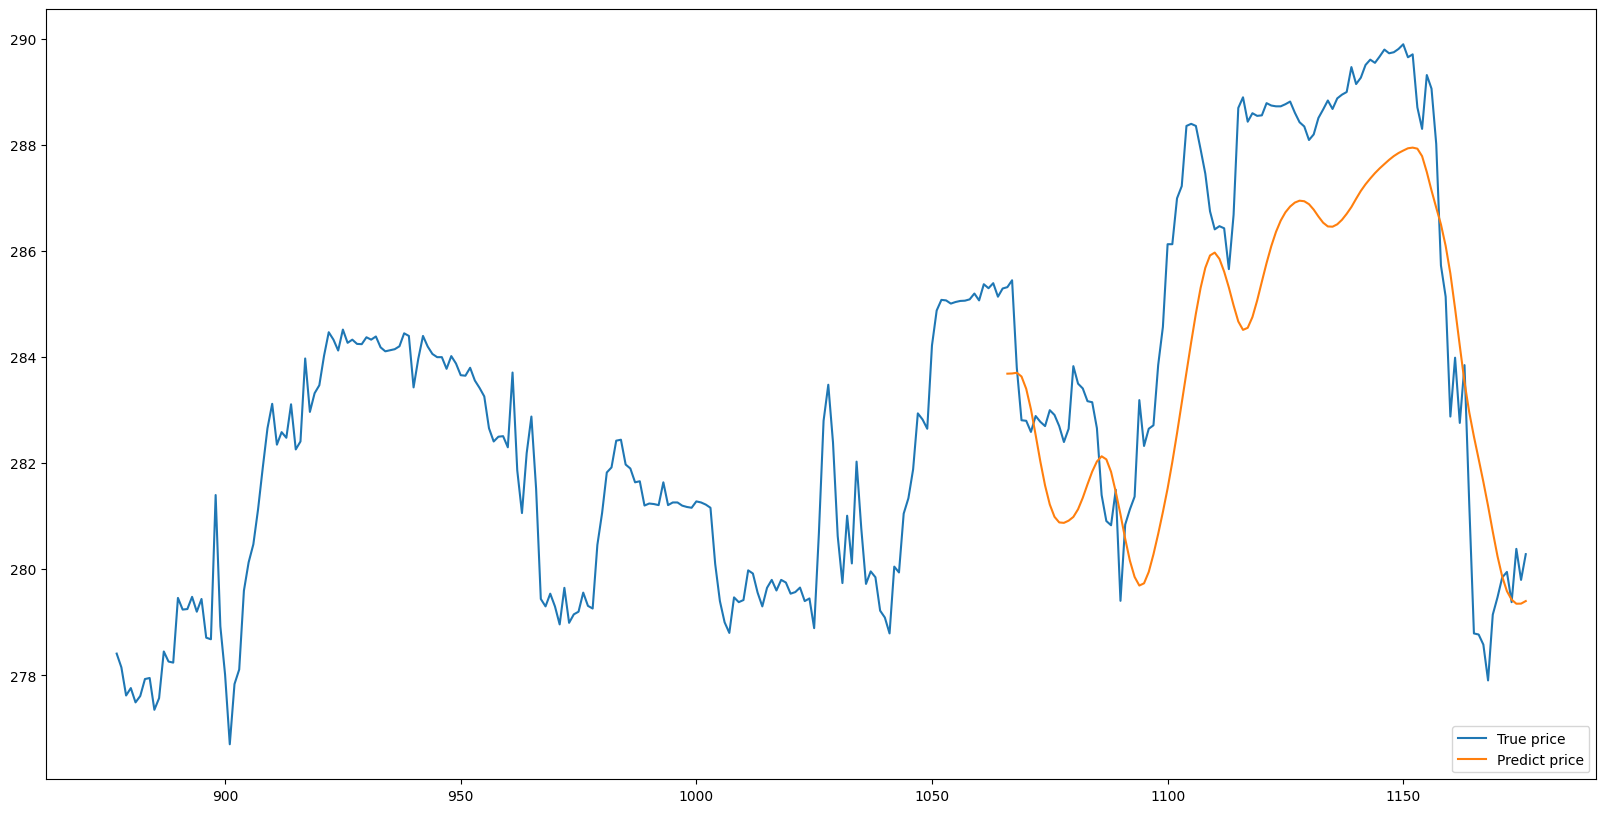

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/25
28/28 [==============================] - 17s 229ms/step - loss: 0.0388 - val_loss: 0.0237
Epoch 2/25
28/28 [==============================] - 3s 124ms/step - loss: 0.0104 - val_loss: 0.0059
Epoch 3/25
28/28 [==============================] - 3s 119ms/step - loss: 0.0081 - val_loss: 0.0058
Epoch 4/25
28/28 [==============================] - 3s 124ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 5/25
28/28 [==============================] - 3s 119ms/step - loss: 0.0062 - val_loss: 0.0051
Epoch 6/25
28/28 [==============================] - 3s 122ms/step - loss: 0.0060 - val_loss: 0.0044
Epoch 7/25
28/28 [==============================] - 3s 121ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 8/25
28/28 [==============================] - 3s 126ms/step - loss: 0.0056 - val_loss: 0.0044
Epoch 9/25
28/28 [==============================] - 3s 121ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 10/25
28/28 [==============================] - 4s 128ms/step - loss: 0.0046 - val_loss: 0.003

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3316815588.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


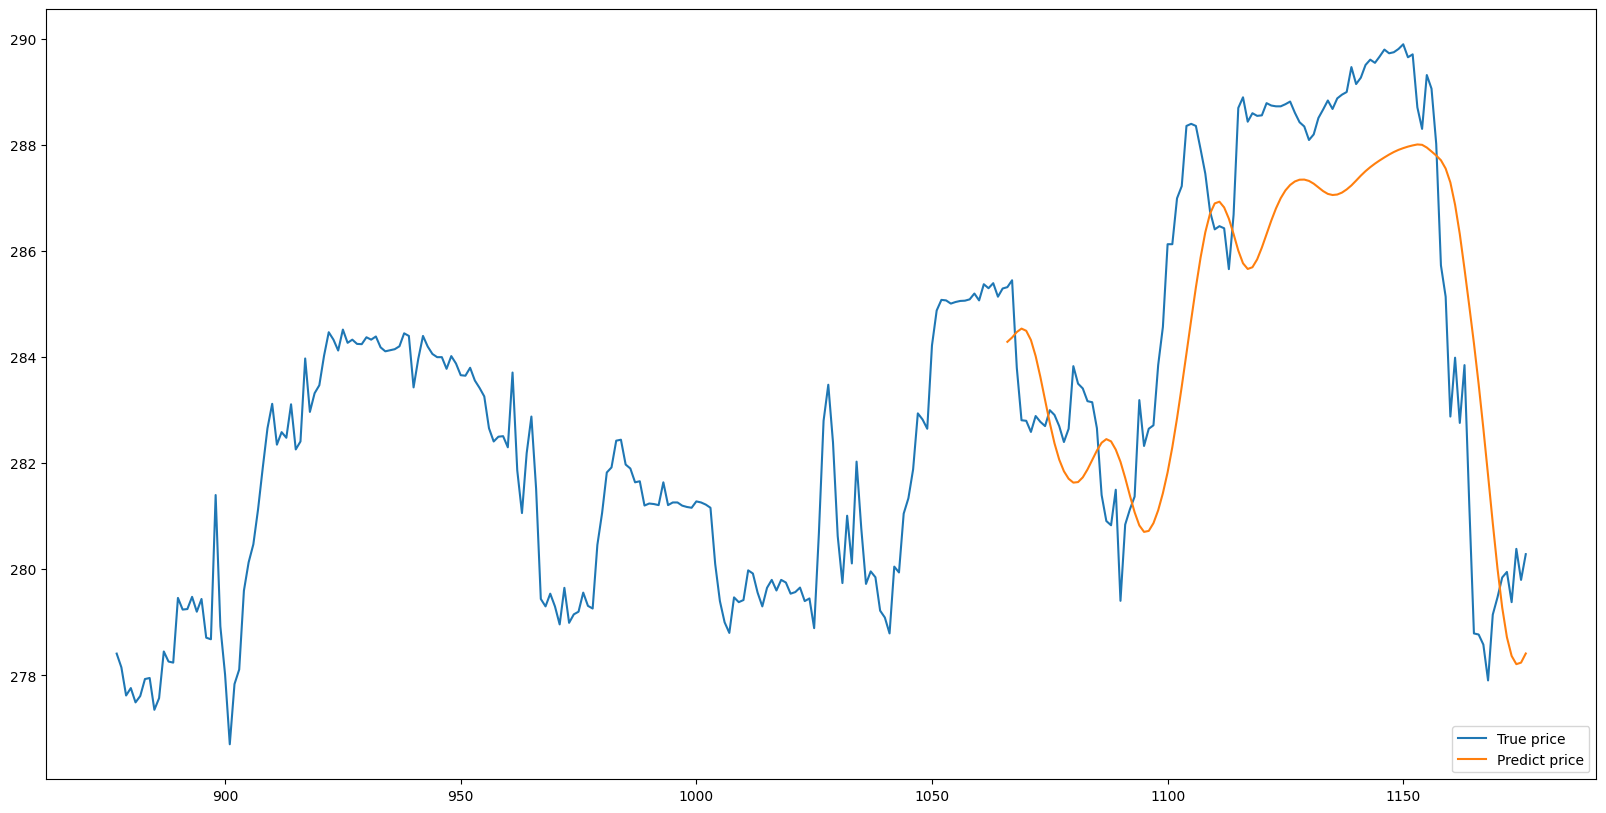

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/25
28/28 [==============================] - 19s 242ms/step - loss: 0.0316 - val_loss: 0.0067
Epoch 2/25
28/28 [==============================] - 4s 127ms/step - loss: 0.0108 - val_loss: 0.0047
Epoch 3/25
28/28 [==============================] - 4s 136ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 4/25
28/28 [==============================] - 4s 141ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 5/25
28/28 [==============================] - 4s 126ms/step - loss: 0.0064 - val_loss: 0.0042
Epoch 6/25
28/28 [==============================] - 3s 122ms/step - loss: 0.0057 - val_loss: 0.0046
Epoch 7/25
28/28 [==============================] - 4s 130ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 8/25
28/28 [==============================] - 4s 126ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 9/25
28/28 [==============================] - 4s 133ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 10/25
28/28 [==============================] - 4s 148ms/step - loss: 0.0047 - val_loss: 0.004

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1497373739.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


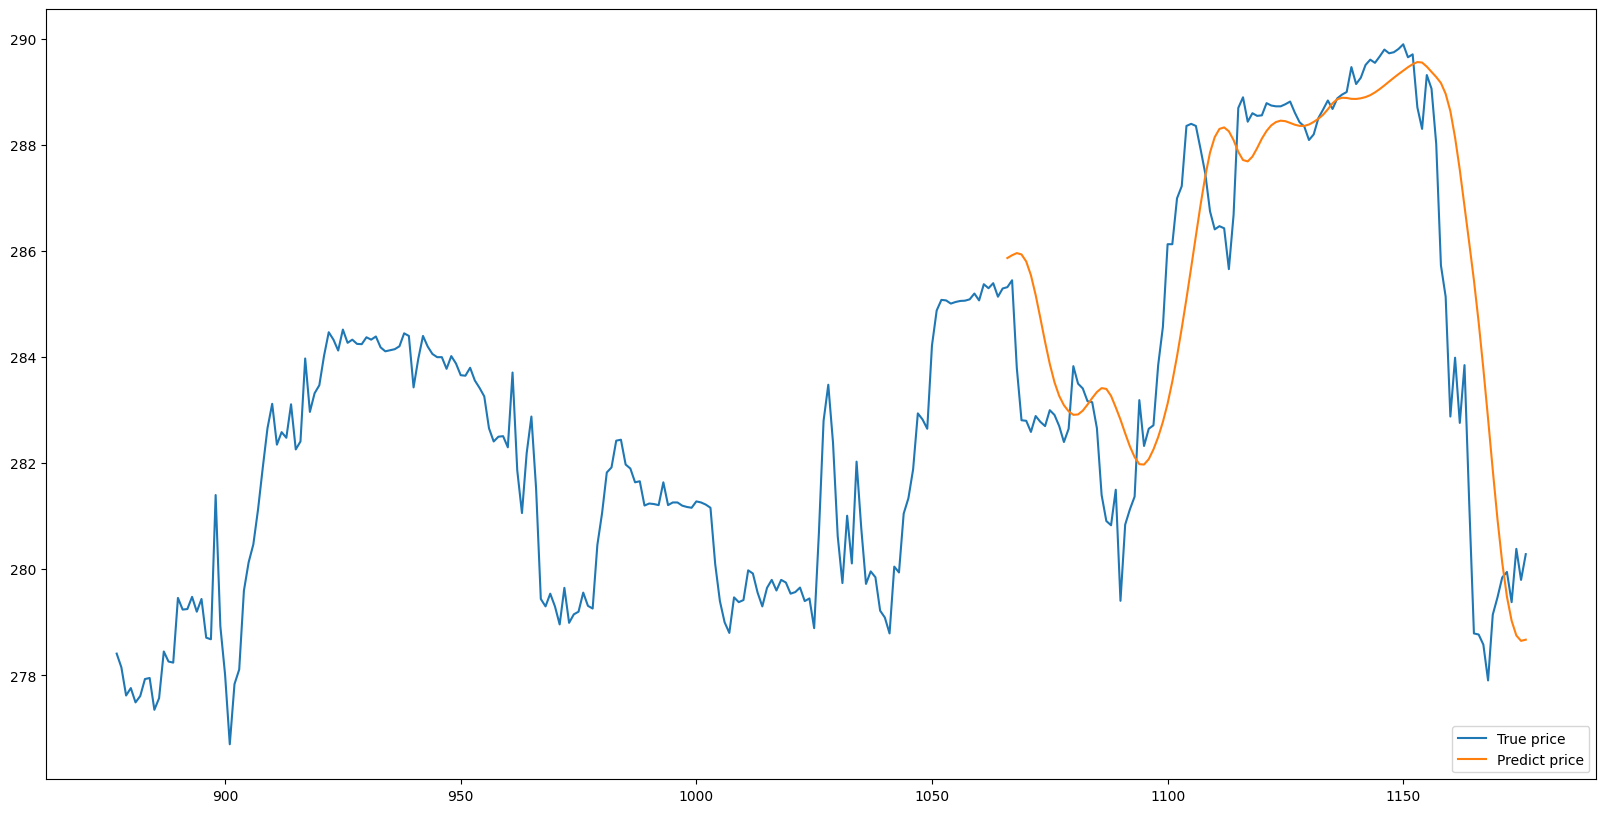

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/25
28/28 [==============================] - 28s 354ms/step - loss: 0.0313 - val_loss: 0.0050
Epoch 2/25
28/28 [==============================] - 4s 155ms/step - loss: 0.0093 - val_loss: 0.0043
Epoch 3/25
28/28 [==============================] - 4s 142ms/step - loss: 0.0071 - val_loss: 0.0047
Epoch 4/25
28/28 [==============================] - 4s 133ms/step - loss: 0.0058 - val_loss: 0.0037
Epoch 5/25
28/28 [==============================] - 4s 144ms/step - loss: 0.0047 - val_loss: 0.0033
Epoch 6/25
28/28 [==============================] - 4s 144ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 7/25
28/28 [==============================] - 4s 139ms/step - loss: 0.0049 - val_loss: 0.0031
Epoch 8/25
28/28 [==============================] - 4s 134ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 9/25
28/28 [==============================] - 4s 128ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 10/25
28/28 [==============================] - 4s 130ms/step - loss: 0.0046 - val_loss: 0.004

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3709587709.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


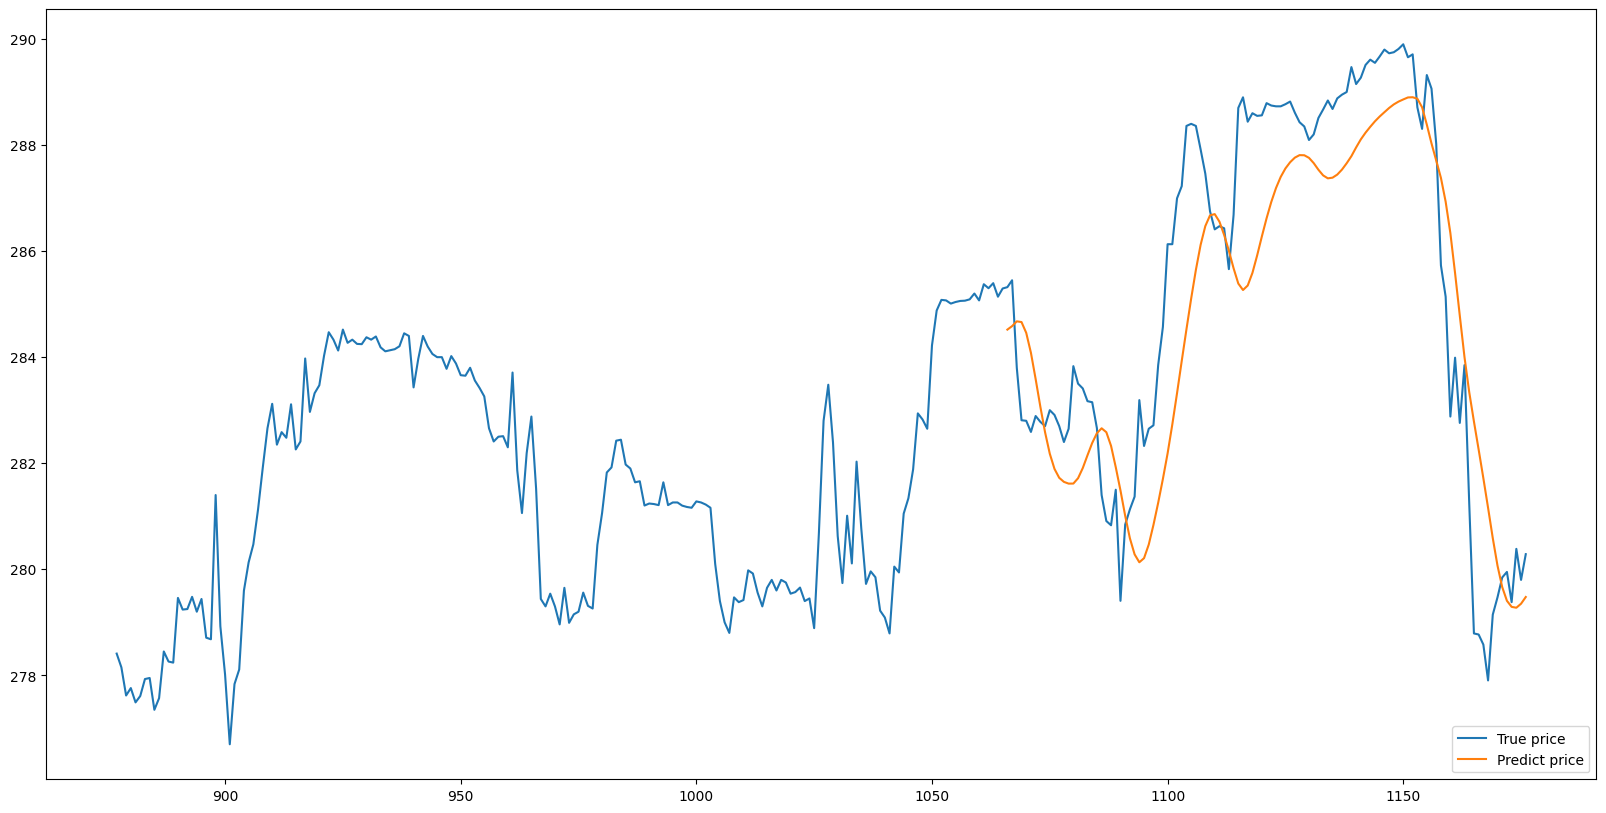

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/25
28/28 [==============================] - 21s 256ms/step - loss: 0.0343 - val_loss: 0.0074
Epoch 2/25
28/28 [==============================] - 4s 139ms/step - loss: 0.0098 - val_loss: 0.0060
Epoch 3/25
28/28 [==============================] - 4s 139ms/step - loss: 0.0084 - val_loss: 0.0052
Epoch 4/25
28/28 [==============================] - 4s 136ms/step - loss: 0.0076 - val_loss: 0.0047
Epoch 5/25
28/28 [==============================] - 4s 134ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 6/25
28/28 [==============================] - 4s 132ms/step - loss: 0.0060 - val_loss: 0.0076
Epoch 7/25
28/28 [==============================] - 4s 146ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 8/25
28/28 [==============================] - 4s 136ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 9/25
28/28 [==============================] - 4s 133ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 10/25
28/28 [==============================] - 4s 146ms/step - loss: 0.0047 - val_loss: 0.003

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3706970121.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


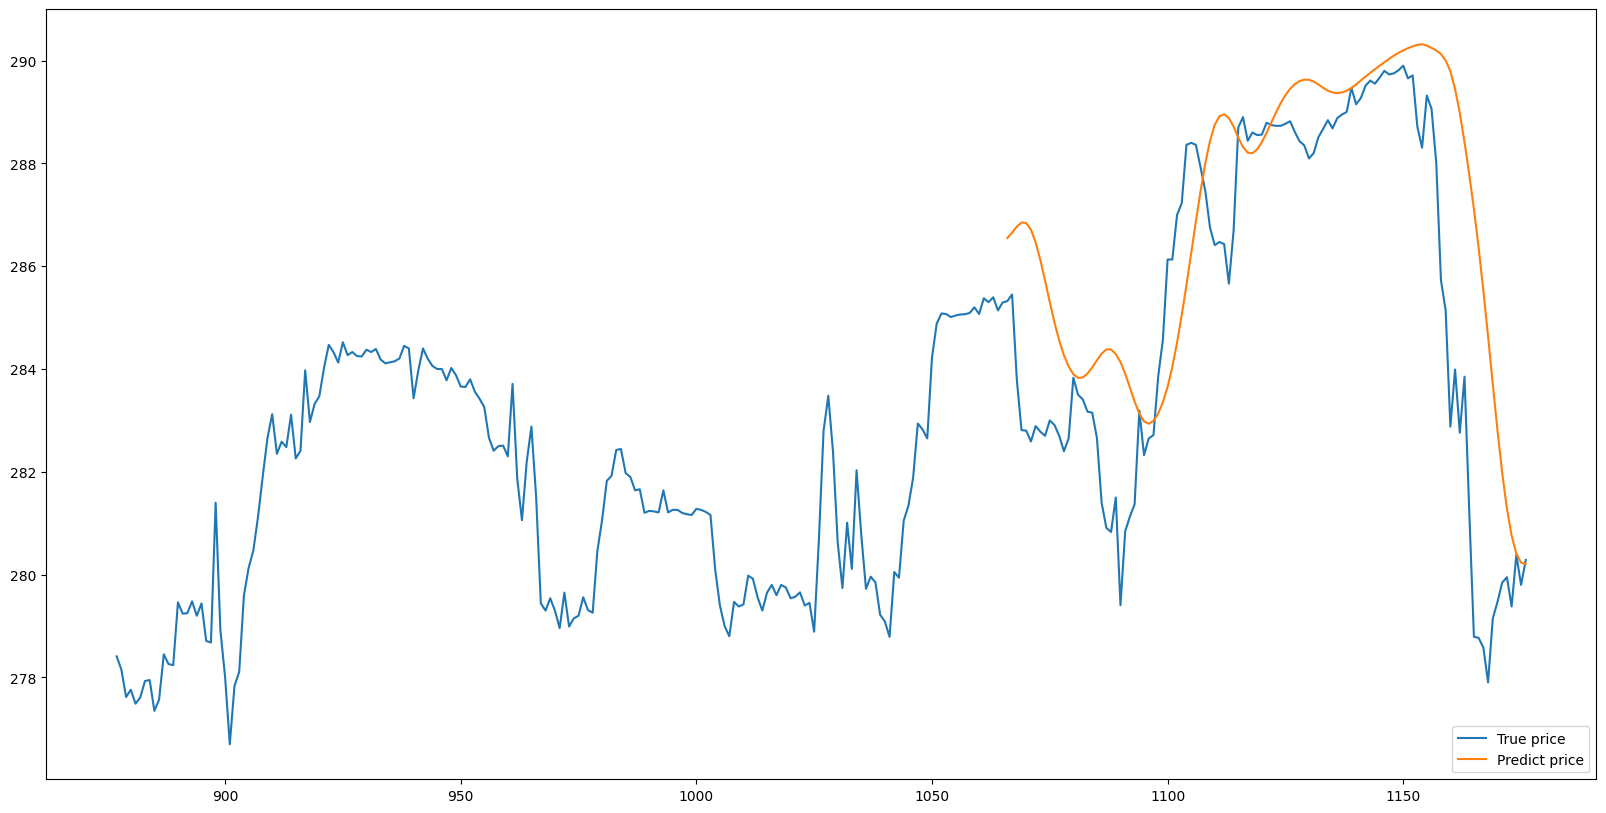

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/25
28/28 [==============================] - 28s 235ms/step - loss: 0.0310 - val_loss: 0.0046
Epoch 2/25
28/28 [==============================] - 4s 138ms/step - loss: 0.0072 - val_loss: 0.0046
Epoch 3/25
28/28 [==============================] - 4s 127ms/step - loss: 0.0068 - val_loss: 0.0099
Epoch 4/25
28/28 [==============================] - 3s 124ms/step - loss: 0.0064 - val_loss: 0.0047
Epoch 5/25
28/28 [==============================] - 4s 142ms/step - loss: 0.0062 - val_loss: 0.0064
Epoch 6/25
28/28 [==============================] - 4s 141ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 7/25
28/28 [==============================] - 4s 125ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 8/25
28/28 [==============================] - 4s 131ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 9/25
28/28 [==============================] - 4s 139ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 10/25
28/28 [==============================] - 5s 168ms/step - loss: 0.0046 - val_loss: 0.003

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1737227570.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


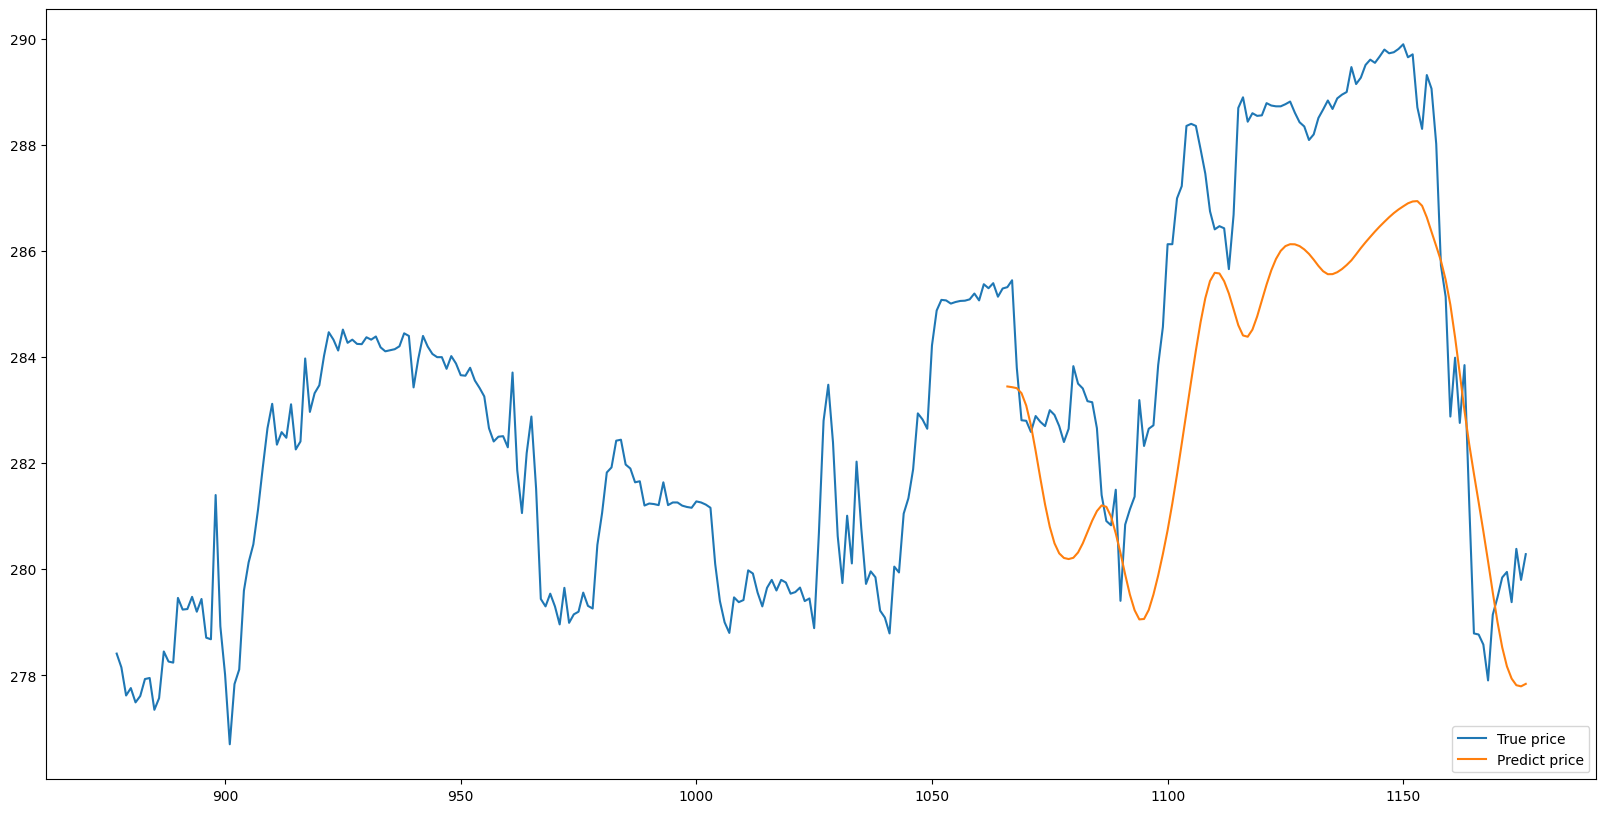

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/25
28/28 [==============================] - 24s 336ms/step - loss: 0.0362 - val_loss: 0.0070
Epoch 2/25
28/28 [==============================] - 5s 188ms/step - loss: 0.0090 - val_loss: 0.0047
Epoch 3/25
28/28 [==============================] - 5s 181ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 4/25
28/28 [==============================] - 4s 136ms/step - loss: 0.0066 - val_loss: 0.0042
Epoch 5/25
28/28 [==============================] - 4s 129ms/step - loss: 0.0055 - val_loss: 0.0045
Epoch 6/25
28/28 [==============================] - 3s 125ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 7/25
28/28 [==============================] - 4s 133ms/step - loss: 0.0059 - val_loss: 0.0093
Epoch 8/25
28/28 [==============================] - 4s 126ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 9/25
28/28 [==============================] - 4s 130ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 10/25
28/28 [==============================] - 4s 134ms/step - loss: 0.0047 - val_loss: 0.004

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3739138904.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


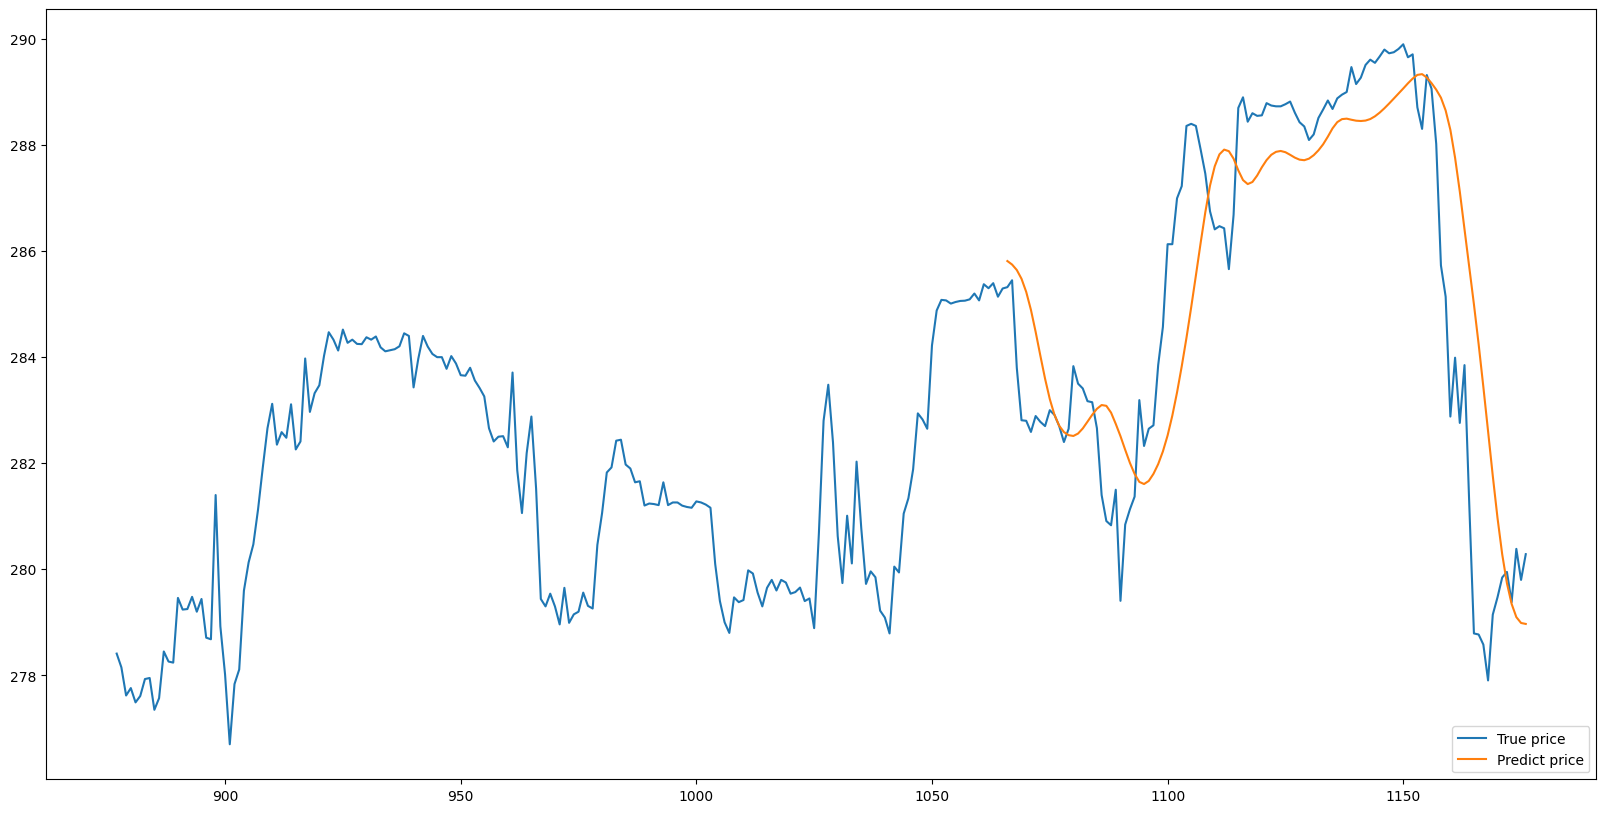

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/25
28/28 [==============================] - 22s 287ms/step - loss: 0.0336 - val_loss: 0.0054
Epoch 2/25
28/28 [==============================] - 4s 141ms/step - loss: 0.0086 - val_loss: 0.0046
Epoch 3/25
28/28 [==============================] - 5s 174ms/step - loss: 0.0062 - val_loss: 0.0044
Epoch 4/25
28/28 [==============================] - 7s 251ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 5/25
28/28 [==============================] - 4s 142ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 6/25
28/28 [==============================] - 4s 148ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 7/25
28/28 [==============================] - 6s 202ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 8/25
28/28 [==============================] - 4s 138ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 9/25
28/28 [==============================] - 4s 128ms/step - loss: 0.0048 - val_loss: 0.0035
Epoch 10/25
28/28 [==============================] - 3s 123ms/step - loss: 0.0049 - val_loss: 0.002

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3709734419.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


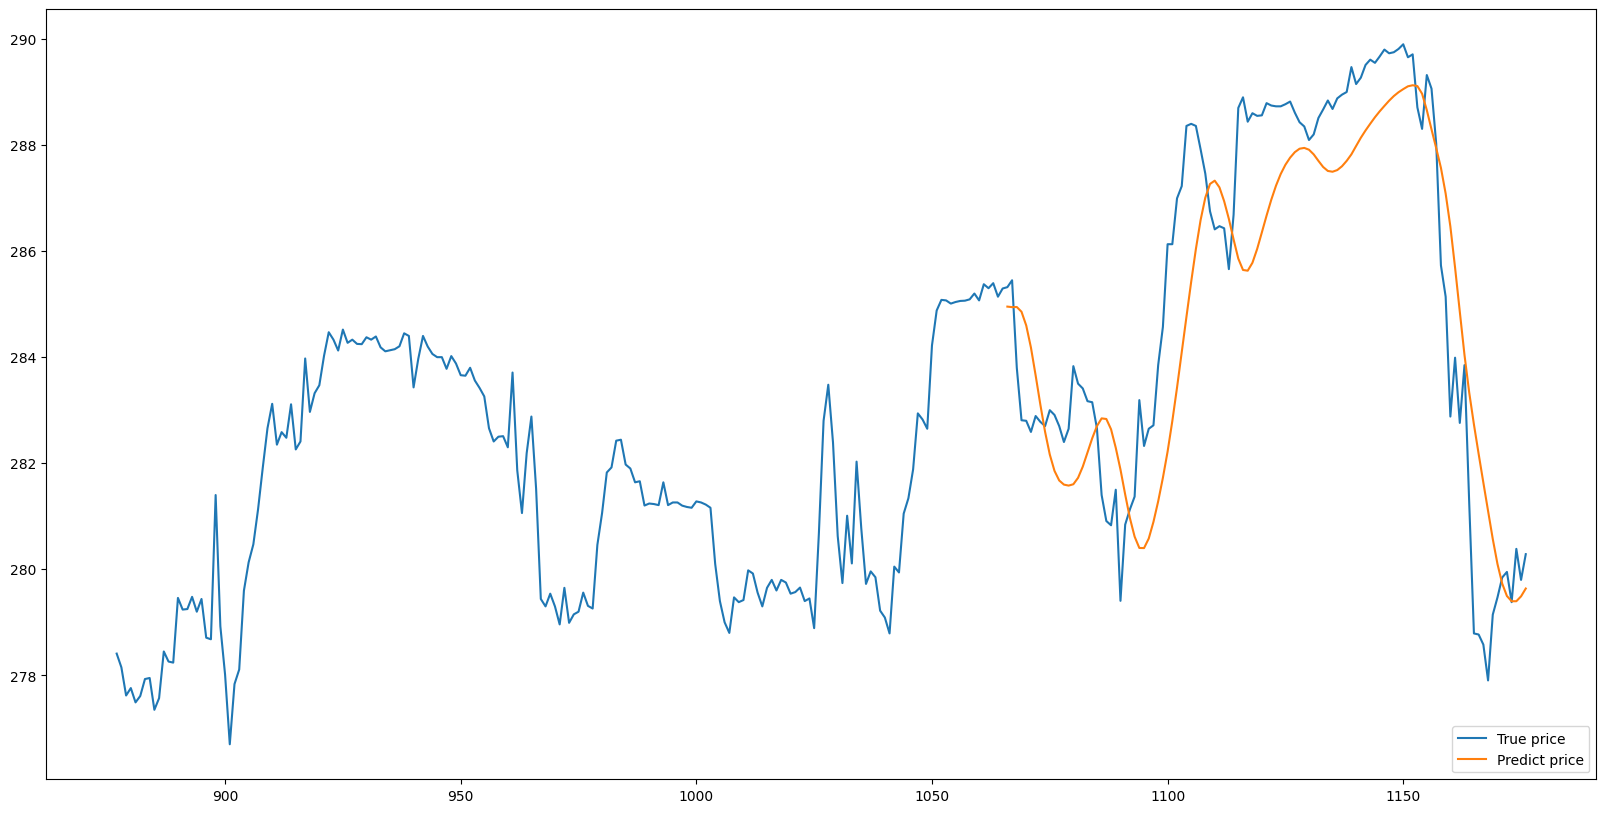

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/25
28/28 [==============================] - 18s 230ms/step - loss: 0.0326 - val_loss: 0.0057
Epoch 2/25
28/28 [==============================] - 4s 142ms/step - loss: 0.0076 - val_loss: 0.0048
Epoch 3/25
28/28 [==============================] - 4s 151ms/step - loss: 0.0071 - val_loss: 0.0040
Epoch 4/25
28/28 [==============================] - 4s 136ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 5/25
28/28 [==============================] - 4s 133ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 6/25
28/28 [==============================] - 4s 129ms/step - loss: 0.0052 - val_loss: 0.0035
Epoch 7/25
28/28 [==============================] - 4s 136ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 8/25
28/28 [==============================] - 4s 141ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 9/25
28/28 [==============================] - 6s 210ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 10/25
28/28 [==============================] - 6s 230ms/step - loss: 0.0049 - val_loss: 0.002

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\841149531.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


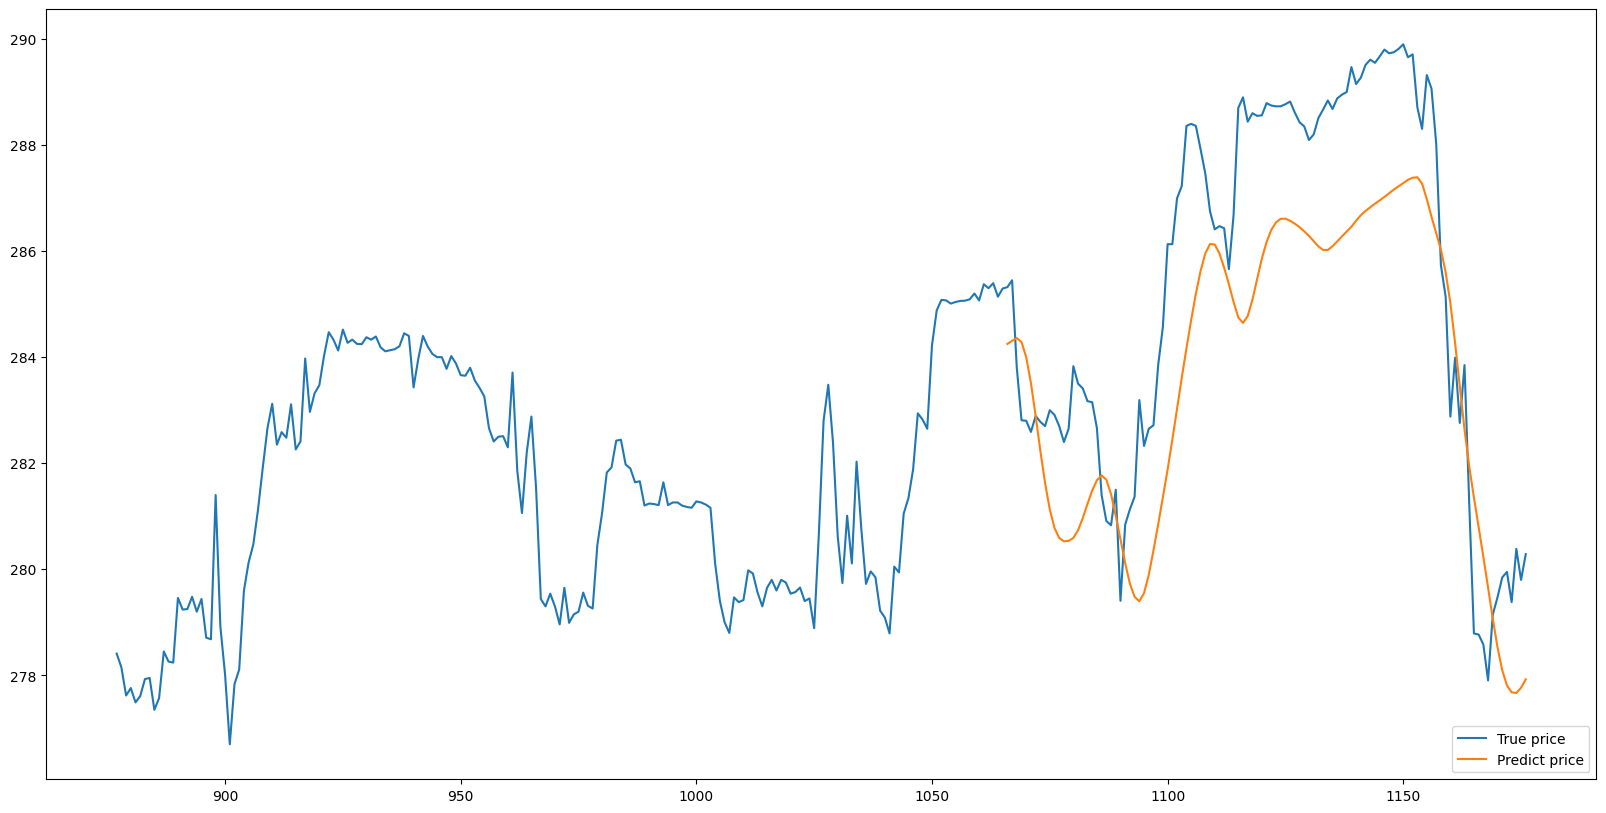

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/25
28/28 [==============================] - 22s 282ms/step - loss: 0.0290 - val_loss: 0.0046
Epoch 2/25
28/28 [==============================] - 4s 131ms/step - loss: 0.0094 - val_loss: 0.0051
Epoch 3/25
28/28 [==============================] - 4s 160ms/step - loss: 0.0070 - val_loss: 0.0056
Epoch 4/25
28/28 [==============================] - 4s 138ms/step - loss: 0.0062 - val_loss: 0.0048
Epoch 5/25
28/28 [==============================] - 4s 148ms/step - loss: 0.0059 - val_loss: 0.0046
Epoch 6/25
28/28 [==============================] - 5s 177ms/step - loss: 0.0057 - val_loss: 0.0059
Epoch 7/25
28/28 [==============================] - 5s 170ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 8/25
28/28 [==============================] - 5s 167ms/step - loss: 0.0047 - val_loss: 0.0053
Epoch 9/25
28/28 [==============================] - 4s 160ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 10/25
28/28 [==============================] - 4s 142ms/step - loss: 0.0051 - val_loss: 0.003

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3091204550.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


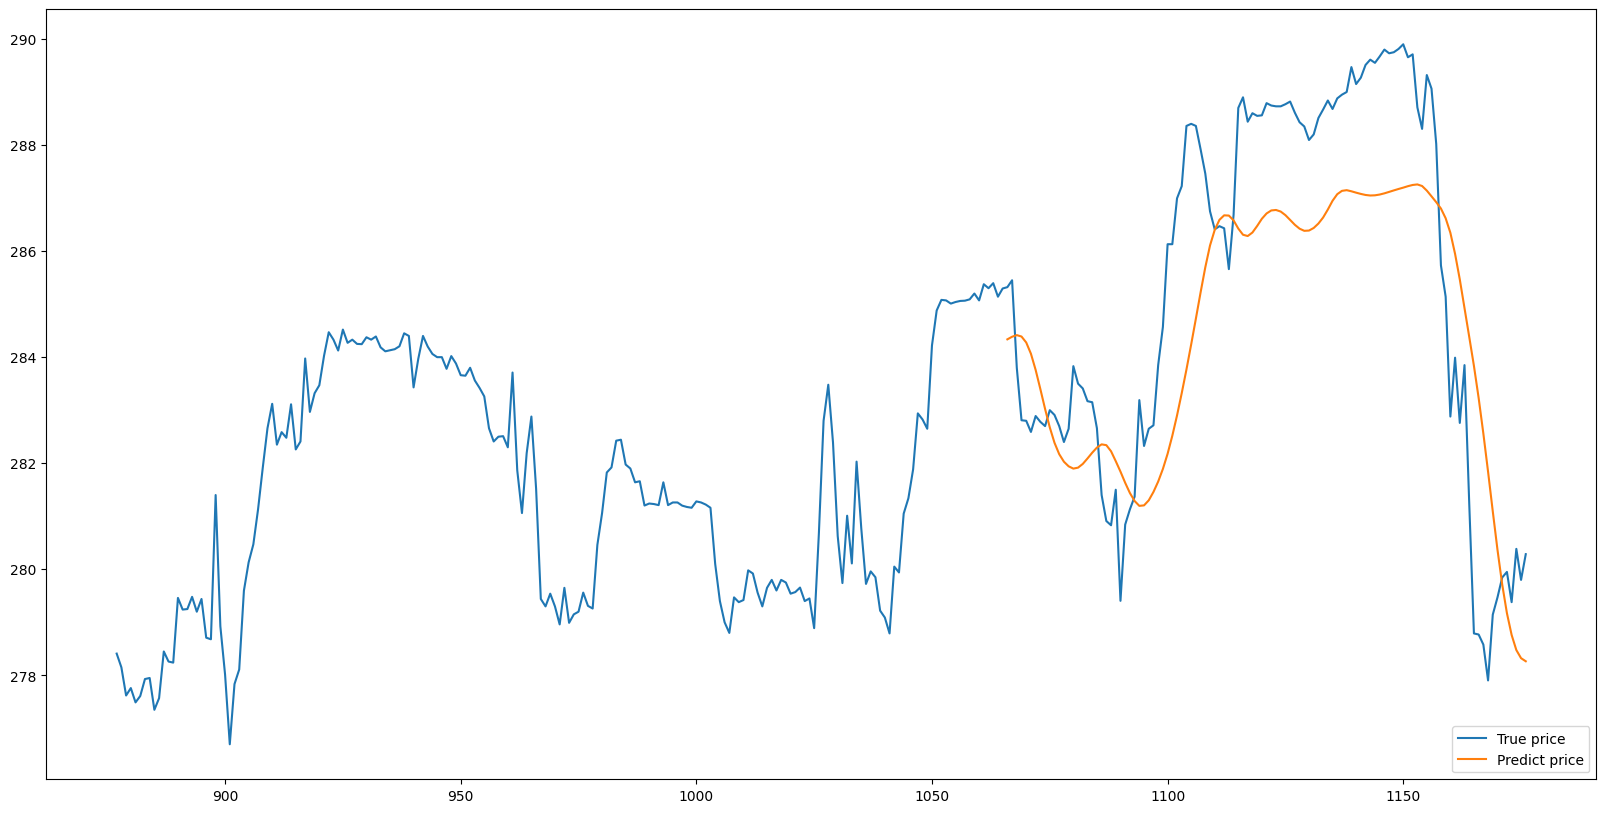

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/25
28/28 [==============================] - 20s 263ms/step - loss: 0.0269 - val_loss: 0.0076
Epoch 2/25
28/28 [==============================] - 4s 139ms/step - loss: 0.0081 - val_loss: 0.0063
Epoch 3/25
28/28 [==============================] - 4s 145ms/step - loss: 0.0067 - val_loss: 0.0054
Epoch 4/25
28/28 [==============================] - 4s 140ms/step - loss: 0.0063 - val_loss: 0.0040
Epoch 5/25
28/28 [==============================] - 4s 147ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 6/25
28/28 [==============================] - 5s 189ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 7/25
28/28 [==============================] - 7s 247ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 8/25
28/28 [==============================] - 6s 200ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 9/25
28/28 [==============================] - 4s 155ms/step - loss: 0.0047 - val_loss: 0.0030
Epoch 10/25
28/28 [==============================] - 4s 136ms/step - loss: 0.0050 - val_loss: 0.008

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1855689813.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


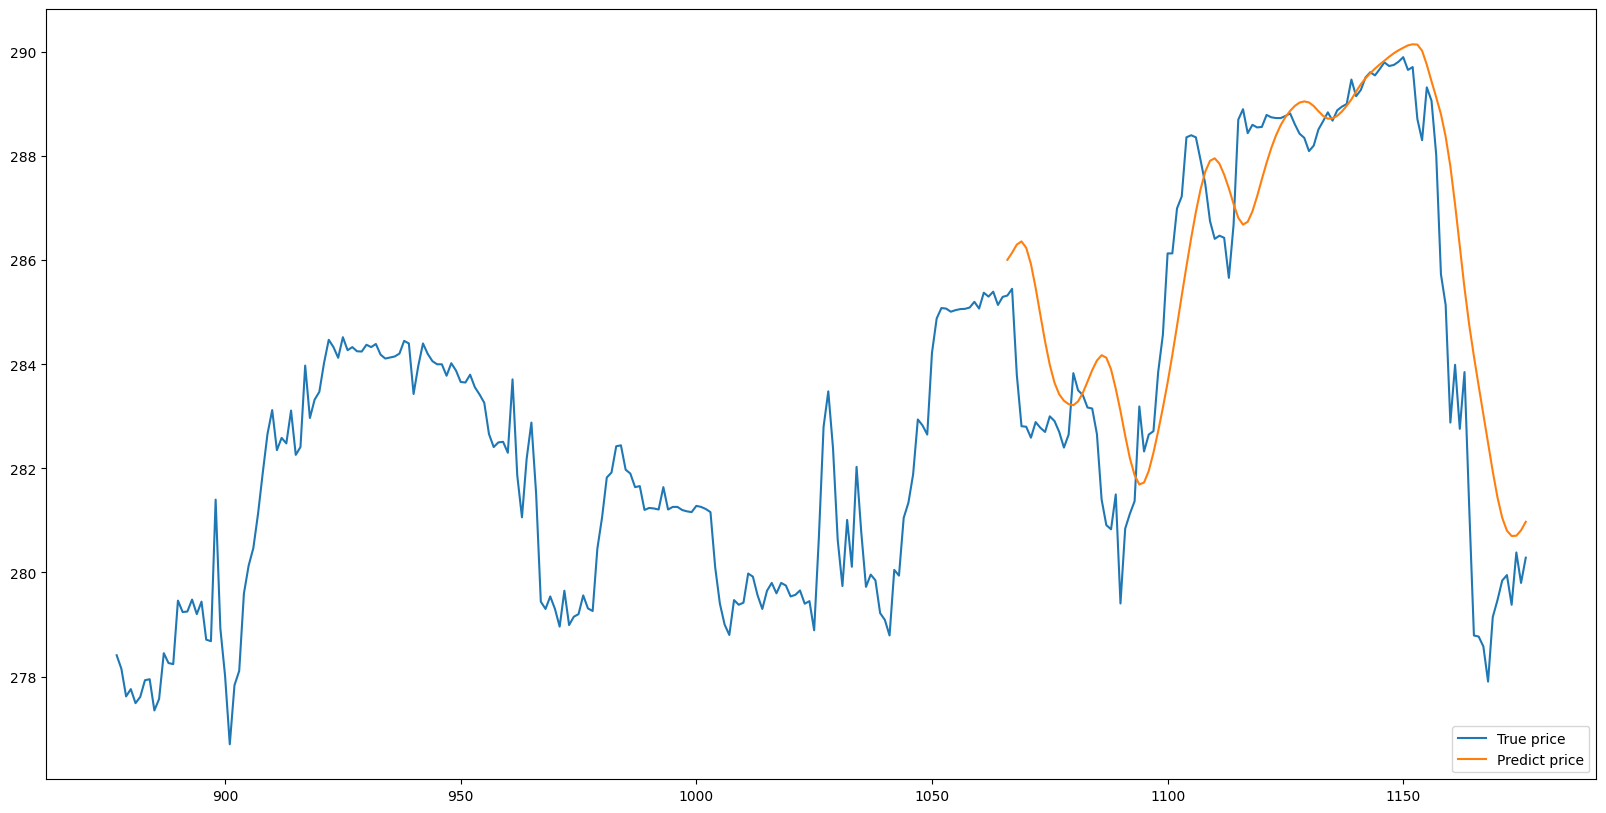

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/25
28/28 [==============================] - 19s 270ms/step - loss: 0.0310 - val_loss: 0.0080
Epoch 2/25
28/28 [==============================] - 3s 119ms/step - loss: 0.0074 - val_loss: 0.0055
Epoch 3/25
28/28 [==============================] - 4s 131ms/step - loss: 0.0068 - val_loss: 0.0085
Epoch 4/25
28/28 [==============================] - 4s 132ms/step - loss: 0.0058 - val_loss: 0.0044
Epoch 5/25
28/28 [==============================] - 4s 142ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 6/25
28/28 [==============================] - 4s 143ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 7/25
28/28 [==============================] - 4s 136ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 8/25
28/28 [==============================] - 4s 135ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 9/25
28/28 [==============================] - 4s 142ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 10/25
28/28 [==============================] - 4s 141ms/step - loss: 0.0045 - val_loss: 0.003

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\95320114.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


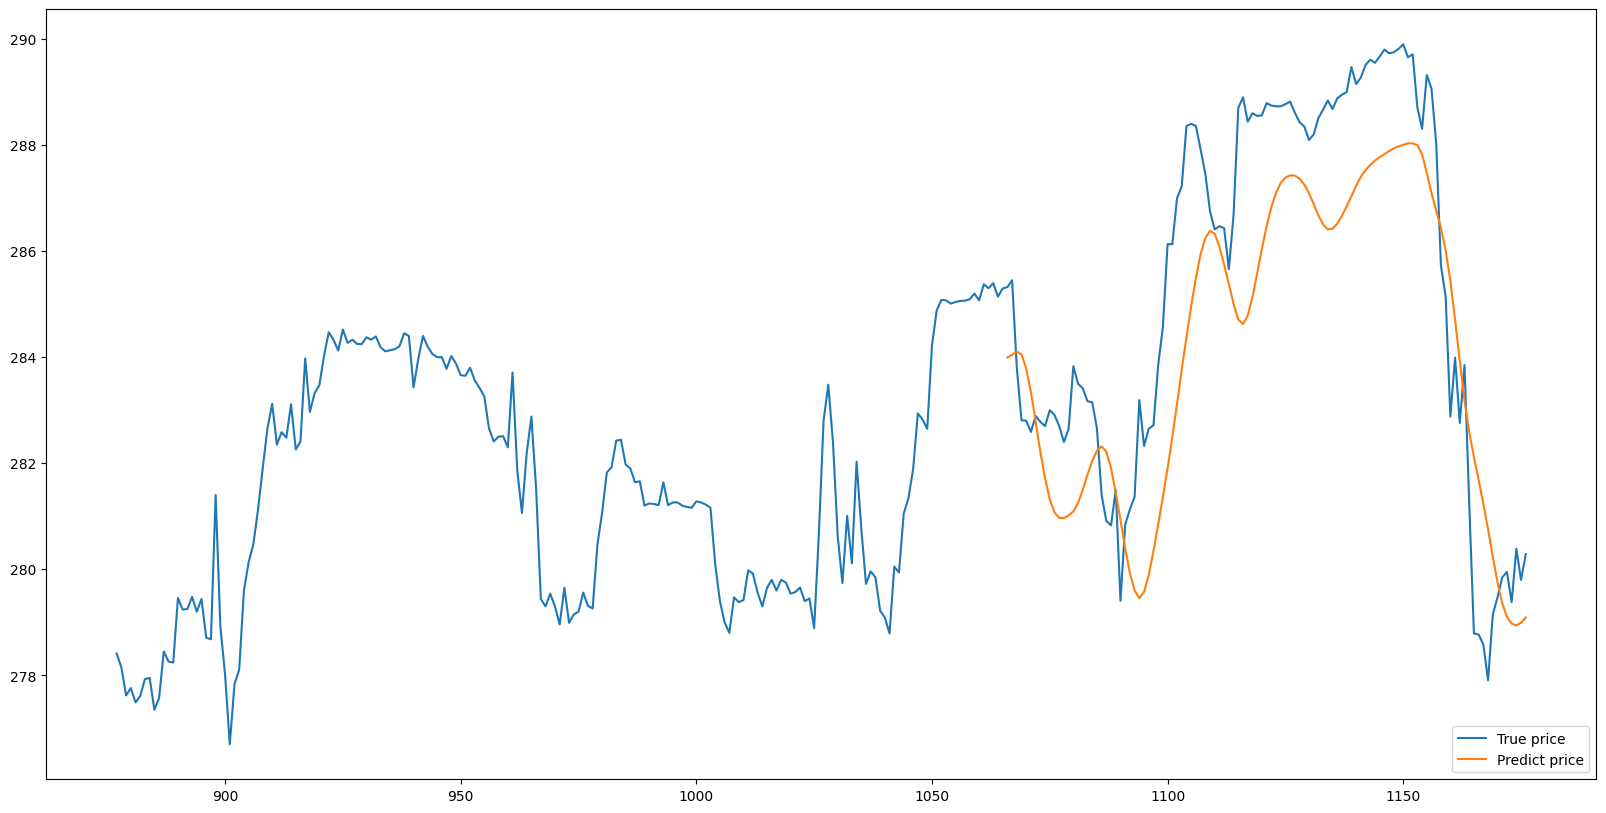

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/25
28/28 [==============================] - 18s 239ms/step - loss: 0.0392 - val_loss: 0.0167
Epoch 2/25
28/28 [==============================] - 4s 135ms/step - loss: 0.0092 - val_loss: 0.0057
Epoch 3/25
28/28 [==============================] - 4s 162ms/step - loss: 0.0069 - val_loss: 0.0047
Epoch 4/25
28/28 [==============================] - 7s 246ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 5/25
28/28 [==============================] - 6s 214ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 6/25
28/28 [==============================] - 6s 197ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 7/25
28/28 [==============================] - 6s 219ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 8/25
28/28 [==============================] - 5s 175ms/step - loss: 0.0052 - val_loss: 0.0121
Epoch 9/25
28/28 [==============================] - 4s 150ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 10/25
28/28 [==============================] - 4s 128ms/step - loss: 0.0047 - val_loss: 0.003

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1118276770.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


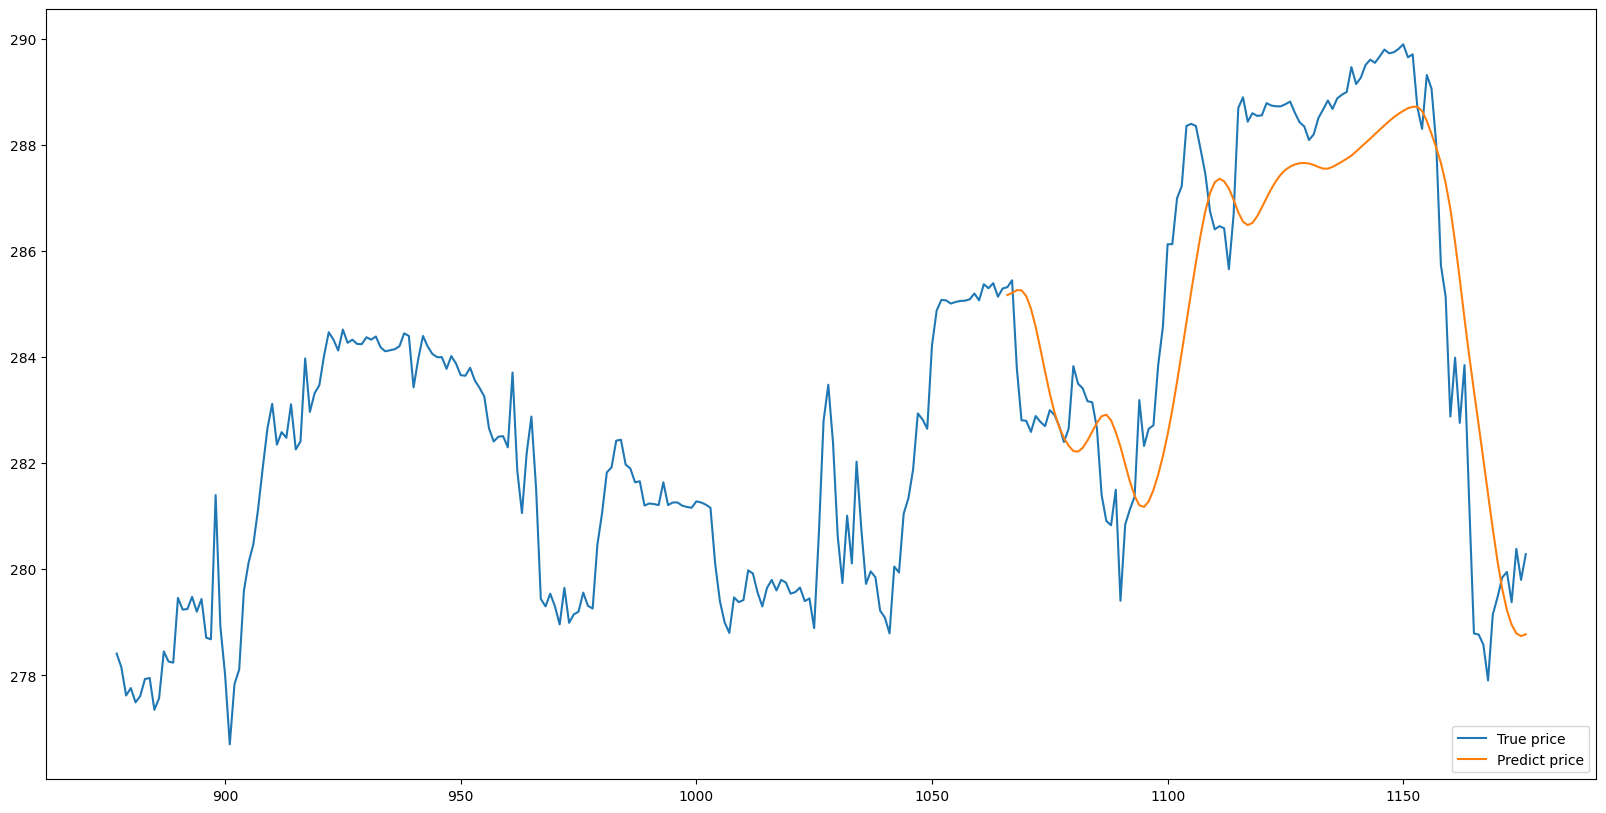

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df[['close', 'volume']]
dataset

close     volume
0     267.295    35192.0
1     265.110   114877.0
2     265.800  3589455.0
3     265.082  1633205.0
4     266.086  1298151.0
...       ...        ...
1172  279.950   404915.0
1173  279.380   505468.0
1174  280.385   533132.0
1175  279.800   375024.0
1176  280.285   370860.0

[1177 rows x 2 columns]

In [ ]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2714080084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2714080084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2714080084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

close     volume  close_date_1  volume_date_1  close_date_2  \
0     267.295    35192.0           NaN            NaN           NaN   
1     265.110   114877.0       267.295        35192.0           NaN   
2     265.800  3589455.0       265.110       114877.0       267.295   
3     265.082  1633205.0       265.800      3589455.0       265.110   
4     266.086  1298151.0       265.082      1633205.0       265.800   
...       ...        ...           ...            ...           ...   
1172  279.950   404915.0       279.845       441109.0       279.470   
1173  279.380   505468.0       279.950       404915.0       279.845   
1174  280.385   533132.0       279.380       505468.0       279.950   
1175  279.800   375024.0       280.385       533132.0       279.380   
1176  280.285   370860.0       279.800       375024.0       280.385   

      volume_date_2  
0               NaN  
1               NaN  
2           35192.0  
3          114877.0  
4         3589455.0  
...             ...  
1172       623370.0  
1173       441109.0  
1174       404915.0  
1175       505468.0  
1176       533132.0  

[1177 rows x 6 columns]

In [ ]:
dataset.dropna(inplace=True)
dataset

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2012072806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


close     volume  close_date_1  volume_date_1  close_date_2  \
2     265.800  3589455.0       265.110       114877.0       267.295   
3     265.082  1633205.0       265.800      3589455.0       265.110   
4     266.086  1298151.0       265.082      1633205.0       265.800   
5     265.008   931613.0       266.086      1298151.0       265.082   
6     264.730   820721.0       265.008       931613.0       266.086   
...       ...        ...           ...            ...           ...   
1172  279.950   404915.0       279.845       441109.0       279.470   
1173  279.380   505468.0       279.950       404915.0       279.845   
1174  280.385   533132.0       279.380       505468.0       279.950   
1175  279.800   375024.0       280.385       533132.0       279.380   
1176  280.285   370860.0       279.800       375024.0       280.385   

      volume_date_2  
2           35192.0  
3          114877.0  
4         3589455.0  
5         1633205.0  
6         1298151.0  
...             ...  
1172       623370.0  
1173       441109.0  
1174       404915.0  
1175       505468.0  
1176       533132.0  

[1175 rows x 6 columns]

In [ ]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1175, 4)
(1175, 1)


close_date_1  volume_date_1  close_date_2  volume_date_2
2          265.110       114877.0       267.295        35192.0
3          265.800      3589455.0       265.110       114877.0
4          265.082      1633205.0       265.800      3589455.0
5          266.086      1298151.0       265.082      1633205.0
6          265.008       931613.0       266.086      1298151.0
...            ...            ...           ...            ...
1172       279.845       441109.0       279.470       623370.0
1173       279.950       404915.0       279.845       441109.0
1174       279.380       505468.0       279.950       404915.0
1175       280.385       533132.0       279.380       505468.0
1176       279.800       375024.0       280.385       533132.0

[1175 rows x 4 columns]

In [ ]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1058, 4)
Size test:  (117, 4)


### b. Train Model

In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [ ]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [ ]:
predictions = model_xgboost.predict(X_test)
predictions

array([284.54617, 284.59726, 284.46695, 284.57773, 284.42014, 284.66873,
       284.42014, 284.5419 , 284.64554, 284.01862, 282.8207 , 282.6786 ,
       282.52386, 282.58765, 282.65787, 282.5399 , 282.54156, 282.6881 ,
       282.65787, 282.58493, 282.39557, 283.28265, 283.68347, 283.623  ,
       283.2558 , 283.13074, 282.8288 , 280.88528, 280.49014, 280.63492,
       281.71103, 279.46906, 280.7133 , 281.7493 , 281.5585 , 282.84253,
       282.855  , 282.60843, 282.80942, 283.39822, 284.64282, 284.96118,
       284.6116 , 284.93073, 284.8973 , 284.90894, 284.6116 , 284.81815,
       284.80865, 284.844  , 284.76227, 284.76862, 284.9584 , 285.06598,
       284.66434, 284.9983 , 284.8604 , 284.96182, 284.98126, 284.86667,
       284.08536, 284.54803, 284.62982, 284.45572, 284.18588, 284.29837,
       284.44696, 284.64554, 284.754  , 284.71594, 284.57773, 284.55933,
       284.84183, 284.754  , 284.66125, 284.61096, 284.5427 , 284.57773,
       284.51016, 284.442  , 284.4842 , 284.60837, 

In [ ]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3408706775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


close    volume  close_date_1  volume_date_1  close_date_2  \
1060  285.070    1575.0       285.200         2223.0       285.090   
1061  285.375    4091.0       285.070         1575.0       285.200   
1062  285.300    1043.0       285.375         4091.0       285.070   
1063  285.395    3075.0       285.300         1043.0       285.375   
1064  285.140    1738.0       285.395         3075.0       285.300   
...       ...       ...           ...            ...           ...   
1172  279.950  404915.0       279.845       441109.0       279.470   
1173  279.380  505468.0       279.950       404915.0       279.845   
1174  280.385  533132.0       279.380       505468.0       279.950   
1175  279.800  375024.0       280.385       533132.0       279.380   
1176  280.285  370860.0       279.800       375024.0       280.385   

      volume_date_2  predictions  
1060          926.0   284.546173  
1061         2223.0   284.597260  
1062         1575.0   284.466949  
1063         4091.0   284.577728  
1064         1043.0   284.420135  
...             ...          ...  
1172       623370.0   280.270935  
1173       441109.0   280.304230  
1174       404915.0   279.581604  
1175       505468.0   280.269165  
1176       533132.0   280.325256  

[117 rows x 7 columns]

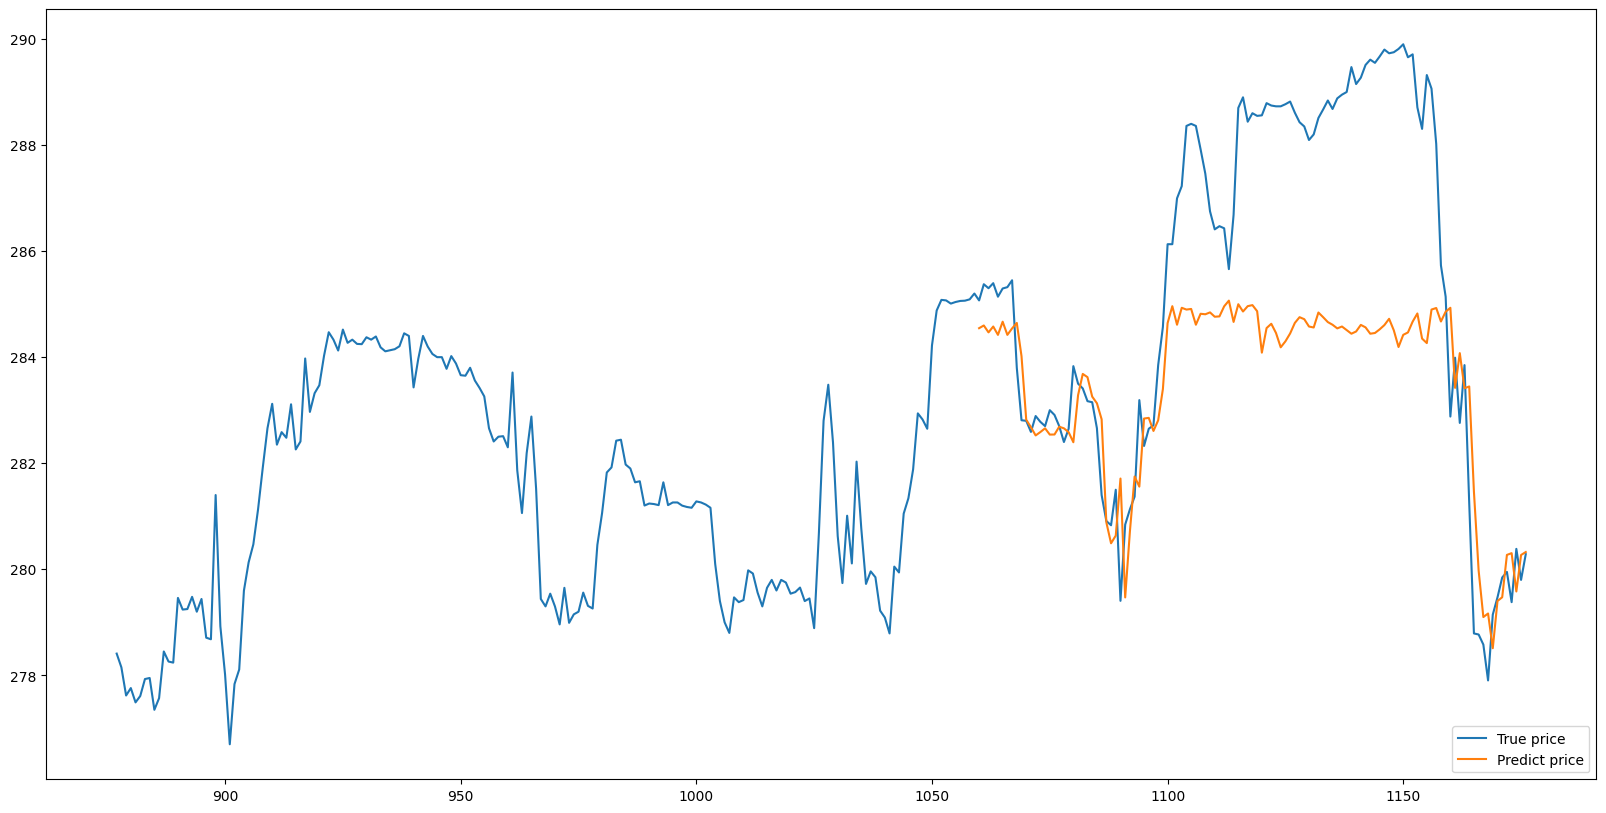

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

close     volume     ROC
0     267.295    35192.0  0.6154
1     265.110   114877.0 -0.2446
2     265.800  3589455.0 -0.2627
3     265.082  1633205.0 -0.6439
4     266.086  1298151.0 -0.4691
...       ...        ...     ...
1172  279.950   404915.0 -3.3689
1173  279.380   505468.0 -3.2316
1174  280.385   533132.0 -2.7471
1175  279.800   375024.0 -3.2905
1176  280.285   370860.0 -3.0367

[1177 rows x 3 columns]

In [ ]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\666477088.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\666477088.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\666477088.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
0     267.295    35192.0  0.6154           NaN            NaN         NaN   
1     265.110   114877.0 -0.2446       267.295        35192.0      0.6154   
2     265.800  3589455.0 -0.2627       265.110       114877.0     -0.2446   
3     265.082  1633205.0 -0.6439       265.800      3589455.0     -0.2627   
4     266.086  1298151.0 -0.4691       265.082      1633205.0     -0.6439   
...       ...        ...     ...           ...            ...         ...   
1172  279.950   404915.0 -3.3689       279.845       441109.0     -3.3868   
1173  279.380   505468.0 -3.2316       279.950       404915.0     -3.3689   
1174  280.385   533132.0 -2.7471       279.380       505468.0     -3.2316   
1175  279.800   375024.0 -3.2905       280.385       533132.0     -2.7471   
1176  280.285   370860.0 -3.0367       279.800       375024.0     -3.2905   

      close_date_2  volume_date_2  ROC_date_2  
0              NaN            NaN         NaN  
1              NaN            NaN         NaN  
2          267.295        35192.0      0.6154  
3          265.110       114877.0     -0.2446  
4          265.800      3589455.0     -0.2627  
...            ...            ...         ...  
1172       279.470       623370.0     -3.5978  
1173       279.845       441109.0     -3.3868  
1174       279.950       404915.0     -3.3689  
1175       279.380       505468.0     -3.2316  
1176       280.385       533132.0     -2.7471  

[1177 rows x 9 columns]

In [ ]:
dataset.dropna(inplace=True)
dataset

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2012072806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset.dropna(inplace=True)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
2     265.800  3589455.0 -0.2627       265.110       114877.0     -0.2446   
3     265.082  1633205.0 -0.6439       265.800      3589455.0     -0.2627   
4     266.086  1298151.0 -0.4691       265.082      1633205.0     -0.6439   
5     265.008   931613.0 -0.8315       266.086      1298151.0     -0.4691   
6     264.730   820721.0 -1.0170       265.008       931613.0     -0.8315   
...       ...        ...     ...           ...            ...         ...   
1172  279.950   404915.0 -3.3689       279.845       441109.0     -3.3868   
1173  279.380   505468.0 -3.2316       279.950       404915.0     -3.3689   
1174  280.385   533132.0 -2.7471       279.380       505468.0     -3.2316   
1175  279.800   375024.0 -3.2905       280.385       533132.0     -2.7471   
1176  280.285   370860.0 -3.0367       279.800       375024.0     -3.2905   

      close_date_2  volume_date_2  ROC_date_2  
2          267.295        35192.0      0.6154  
3          265.110       114877.0     -0.2446  
4          265.800      3589455.0     -0.2627  
5          265.082      1633205.0     -0.6439  
6          266.086      1298151.0     -0.4691  
...            ...            ...         ...  
1172       279.470       623370.0     -3.5978  
1173       279.845       441109.0     -3.3868  
1174       279.950       404915.0     -3.3689  
1175       279.380       505468.0     -3.2316  
1176       280.385       533132.0     -2.7471  

[1175 rows x 9 columns]

In [ ]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1175, 6)
(1175, 1)


close_date_1  volume_date_1  ROC_date_1  close_date_2  volume_date_2  \
2          265.110       114877.0     -0.2446       267.295        35192.0   
3          265.800      3589455.0     -0.2627       265.110       114877.0   
4          265.082      1633205.0     -0.6439       265.800      3589455.0   
5          266.086      1298151.0     -0.4691       265.082      1633205.0   
6          265.008       931613.0     -0.8315       266.086      1298151.0   
...            ...            ...         ...           ...            ...   
1172       279.845       441109.0     -3.3868       279.470       623370.0   
1173       279.950       404915.0     -3.3689       279.845       441109.0   
1174       279.380       505468.0     -3.2316       279.950       404915.0   
1175       280.385       533132.0     -2.7471       279.380       505468.0   
1176       279.800       375024.0     -3.2905       280.385       533132.0   

      ROC_date_2  
2         0.6154  
3        -0.2446  
4        -0.2627  
5        -0.6439  
6        -0.4691  
...          ...  
1172     -3.5978  
1173     -3.3868  
1174     -3.3689  
1175     -3.2316  
1176     -2.7471  

[1175 rows x 6 columns]

In [ ]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1058, 6)
Size test:  (117, 6)


In [ ]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [ ]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [ ]:
predictions = model_xgboost.predict(X_test)
predictions

array([284.6143 , 284.654  , 284.5865 , 284.6794 , 284.5865 , 284.6794 ,
       284.5865 , 284.63184, 284.48444, 283.92114, 283.2191 , 282.59738,
       282.4994 , 282.24475, 282.1005 , 282.16373, 282.25024, 282.34055,
       282.1259 , 281.99744, 281.9465 , 283.3121 , 283.1106 , 282.99915,
       282.7611 , 282.68628, 282.60962, 280.91998, 280.40106, 280.60577,
       281.56595, 279.58298, 280.4155 , 281.67154, 281.52295, 282.6359 ,
       283.058  , 282.25214, 282.88034, 283.84167, 284.47345, 284.7788 ,
       284.81256, 284.88675, 284.84918, 284.7888 , 284.75342, 284.71936,
       284.84744, 284.81146, 284.8587 , 284.63852, 284.71002, 284.8355 ,
       284.80835, 284.7768 , 284.57123, 284.5757 , 284.5922 , 284.76236,
       284.6808 , 284.3565 , 284.38763, 284.49854, 284.4456 , 284.51733,
       284.66635, 284.74985, 284.6726 , 284.72284, 284.75812, 284.40042,
       284.37222, 284.3437 , 284.41315, 284.47818, 284.72964, 284.78214,
       284.68234, 284.71326, 284.64575, 284.80768, 

In [ ]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3408706775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


close    volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
1060  285.070    1575.0  2.1427       285.200         2223.0      2.1417   
1061  285.375    4091.0  2.3620       285.070         1575.0      2.1427   
1062  285.300    1043.0  1.8747       285.375         4091.0      2.3620   
1063  285.395    3075.0  1.9486       285.300         1043.0      1.8747   
1064  285.140    1738.0  1.4553       285.395         3075.0      1.9486   
...       ...       ...     ...           ...            ...         ...   
1172  279.950  404915.0 -3.3689       279.845       441109.0     -3.3868   
1173  279.380  505468.0 -3.2316       279.950       404915.0     -3.3689   
1174  280.385  533132.0 -2.7471       279.380       505468.0     -3.2316   
1175  279.800  375024.0 -3.2905       280.385       533132.0     -2.7471   
1176  280.285  370860.0 -3.0367       279.800       375024.0     -3.2905   

      close_date_2  volume_date_2  ROC_date_2  predictions  
1060       285.090          926.0      1.8724   284.614288  
1061       285.200         2223.0      2.1417   284.653992  
1062       285.070         1575.0      2.1427   284.586487  
1063       285.375         4091.0      2.3620   284.679413  
1064       285.300         1043.0      1.8747   284.586487  
...            ...            ...         ...          ...  
1172       279.470       623370.0     -3.5978   280.214752  
1173       279.845       441109.0     -3.3868   280.366272  
1174       279.950       404915.0     -3.3689   279.613220  
1175       279.380       505468.0     -3.2316   280.120483  
1176       280.385       533132.0     -2.7471   280.000092  

[117 rows x 10 columns]

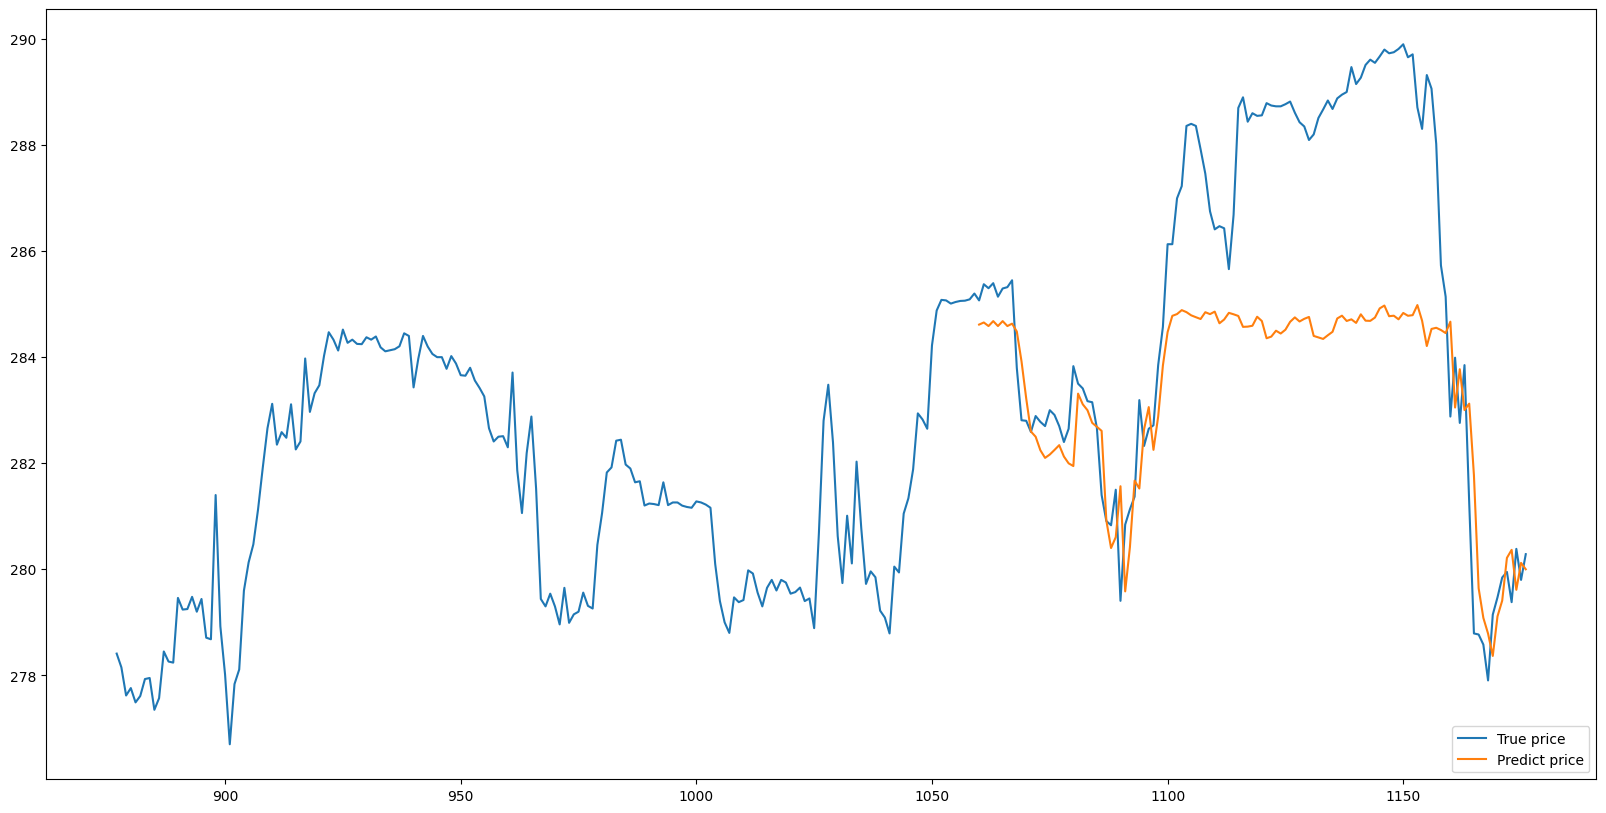

In [ ]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1026725636.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1026725636.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1026725636.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

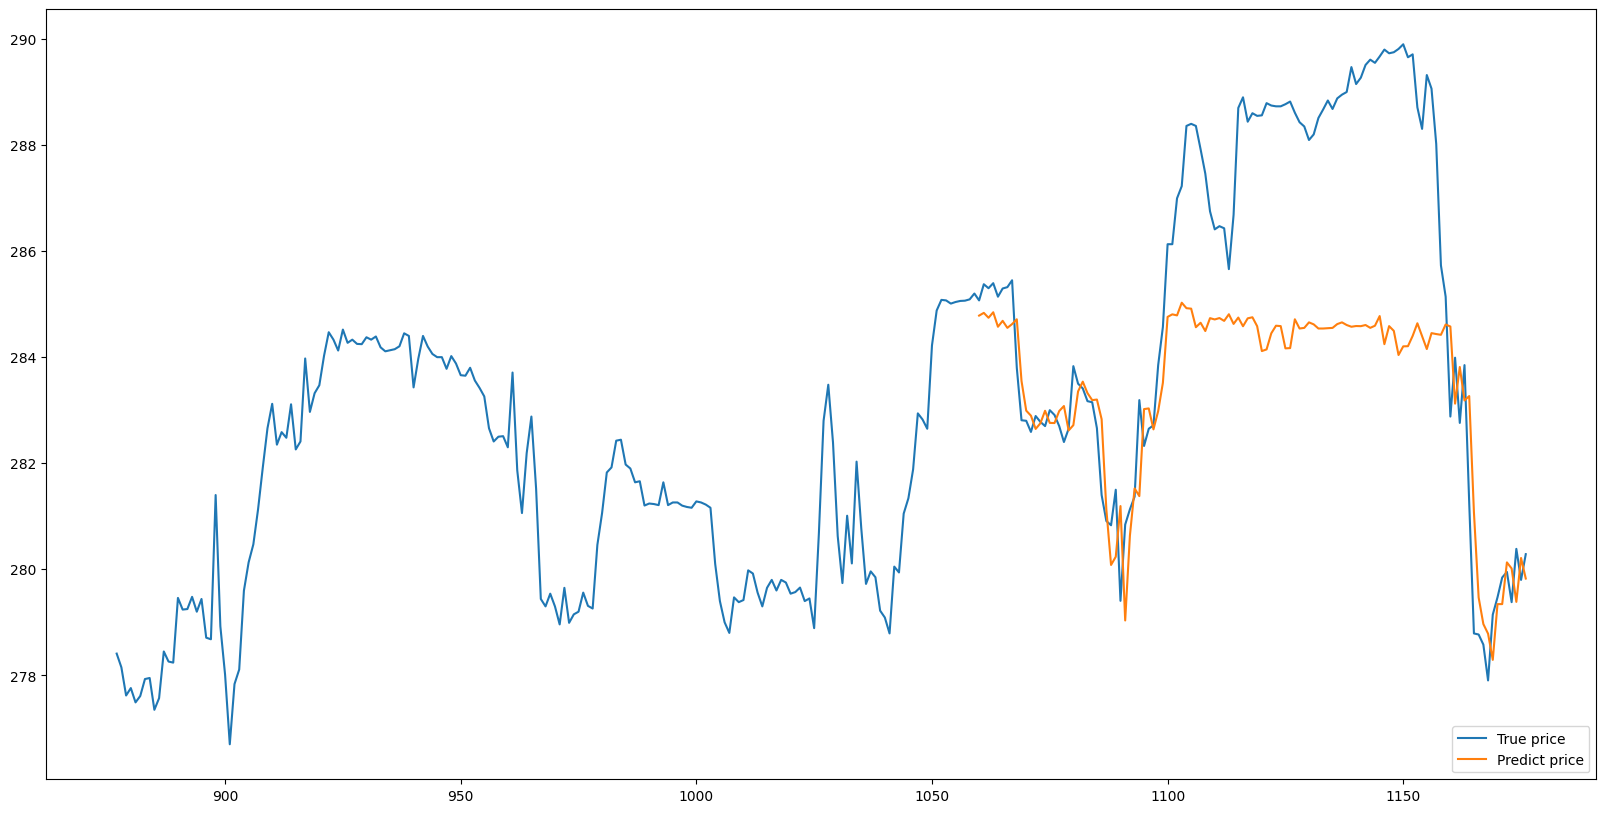

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1500967414.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1500967414.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1500967414.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

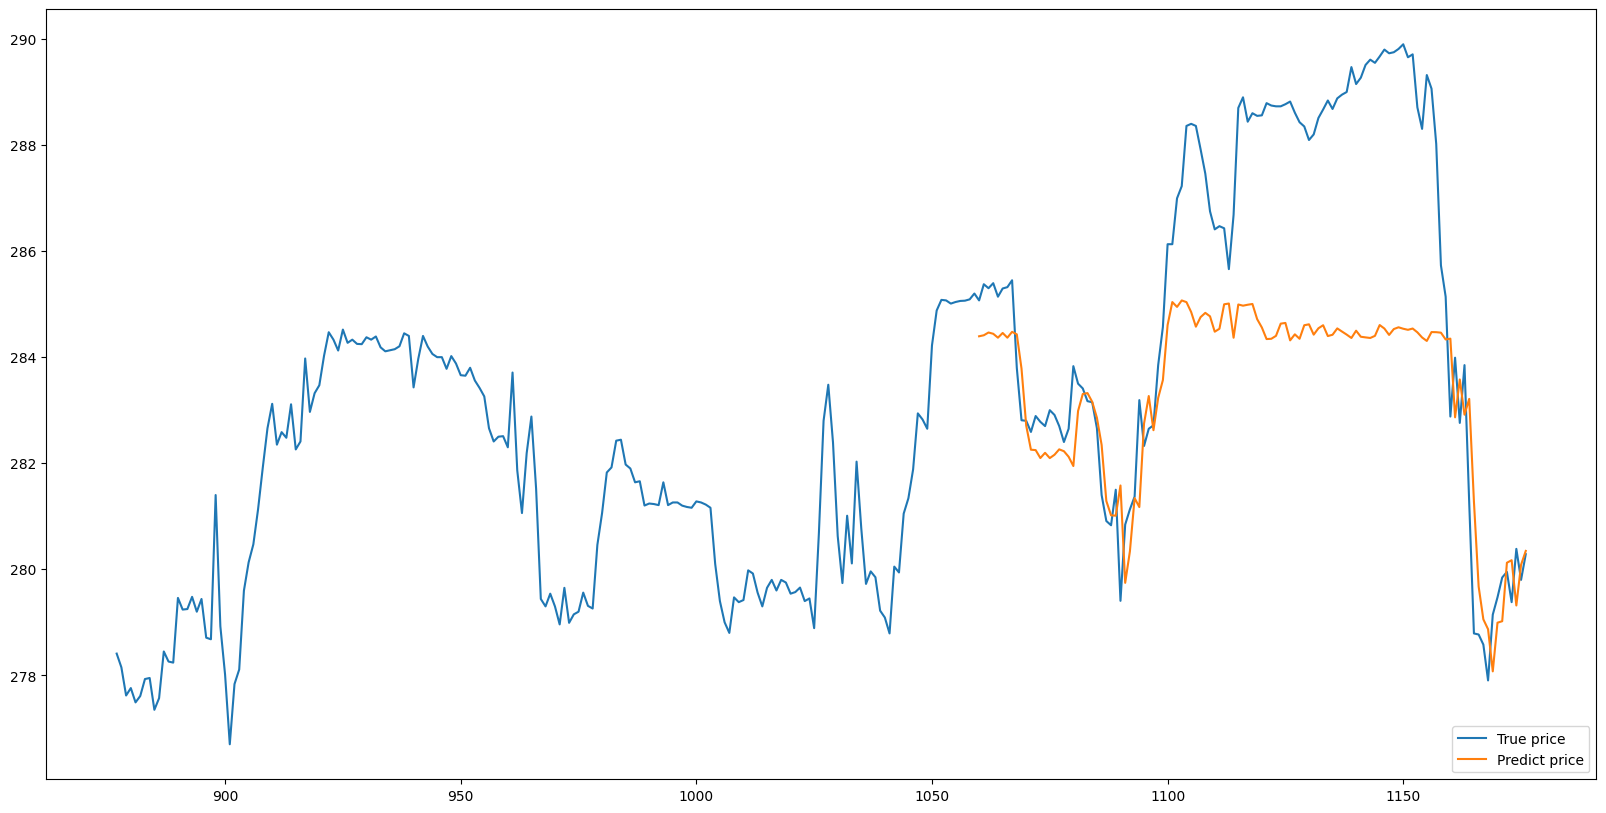

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2668610043.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2668610043.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2668610043.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

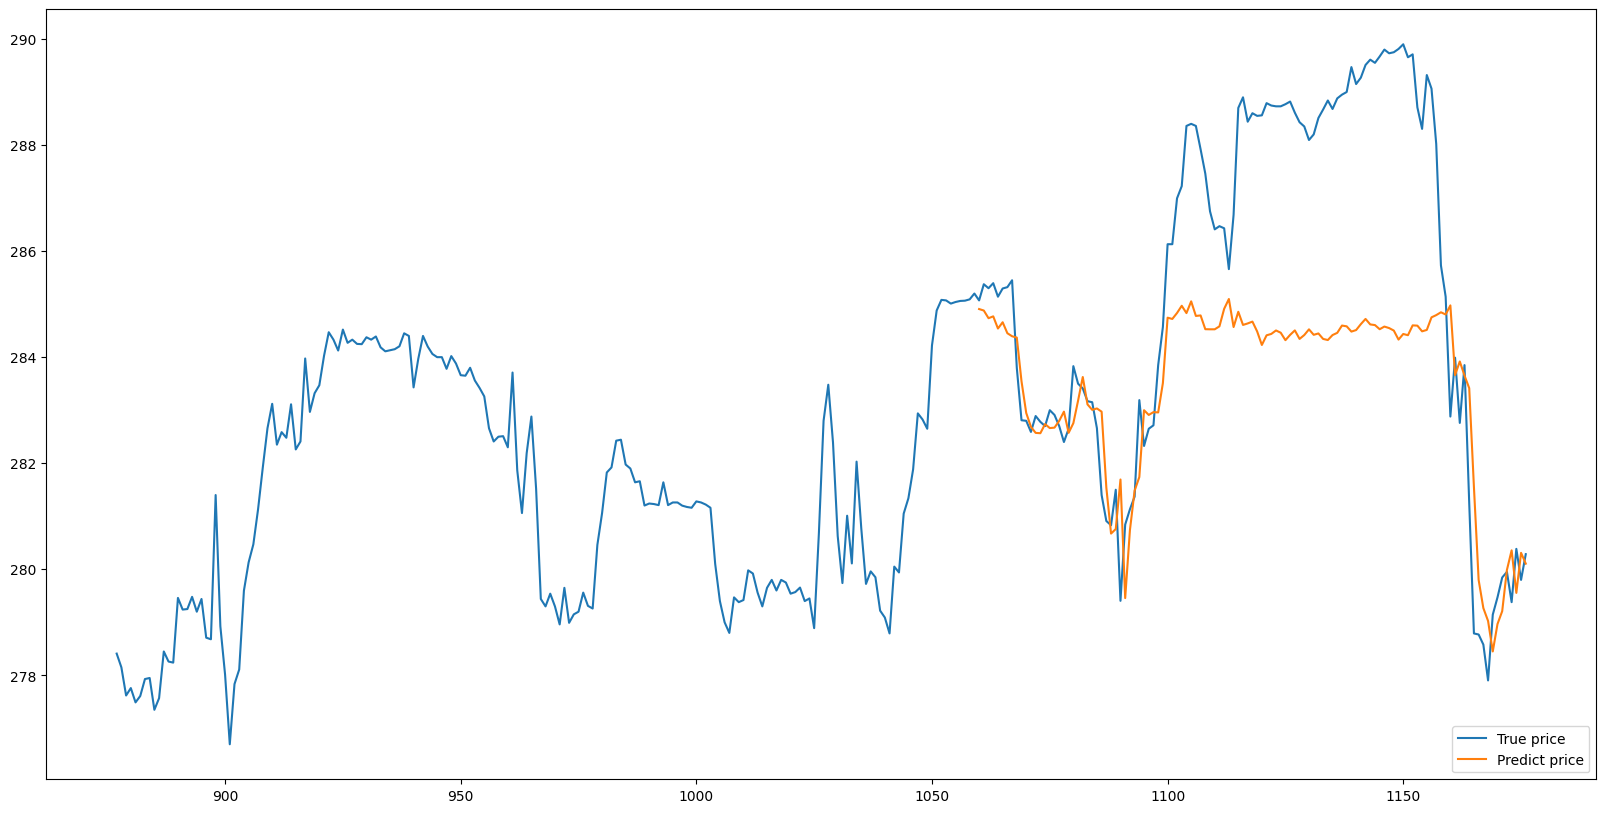

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2913271233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2913271233.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2913271233.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

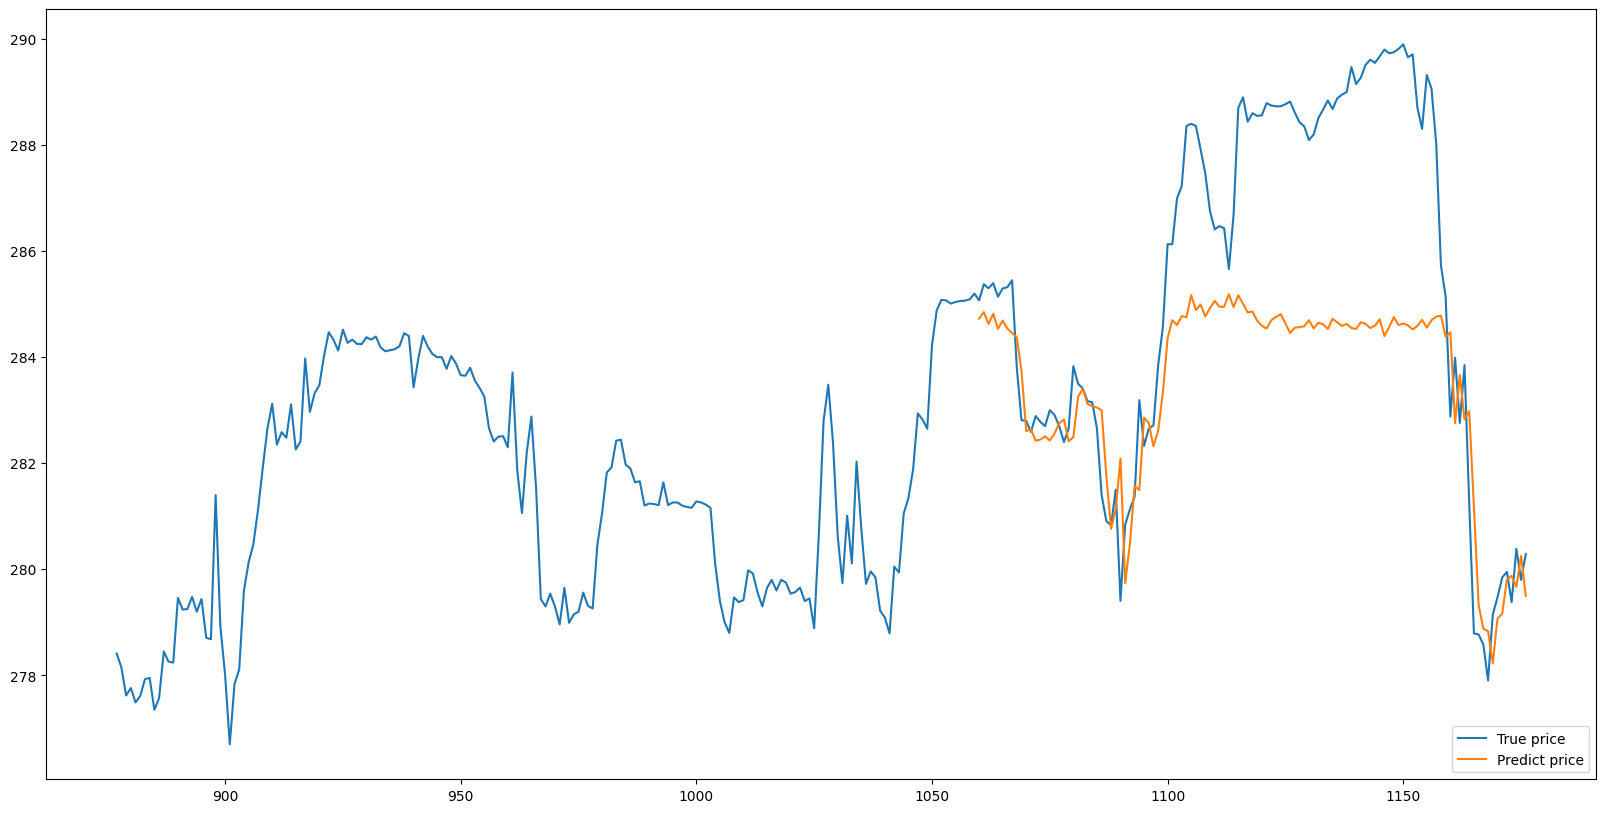

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2015135087.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2015135087.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2015135087.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

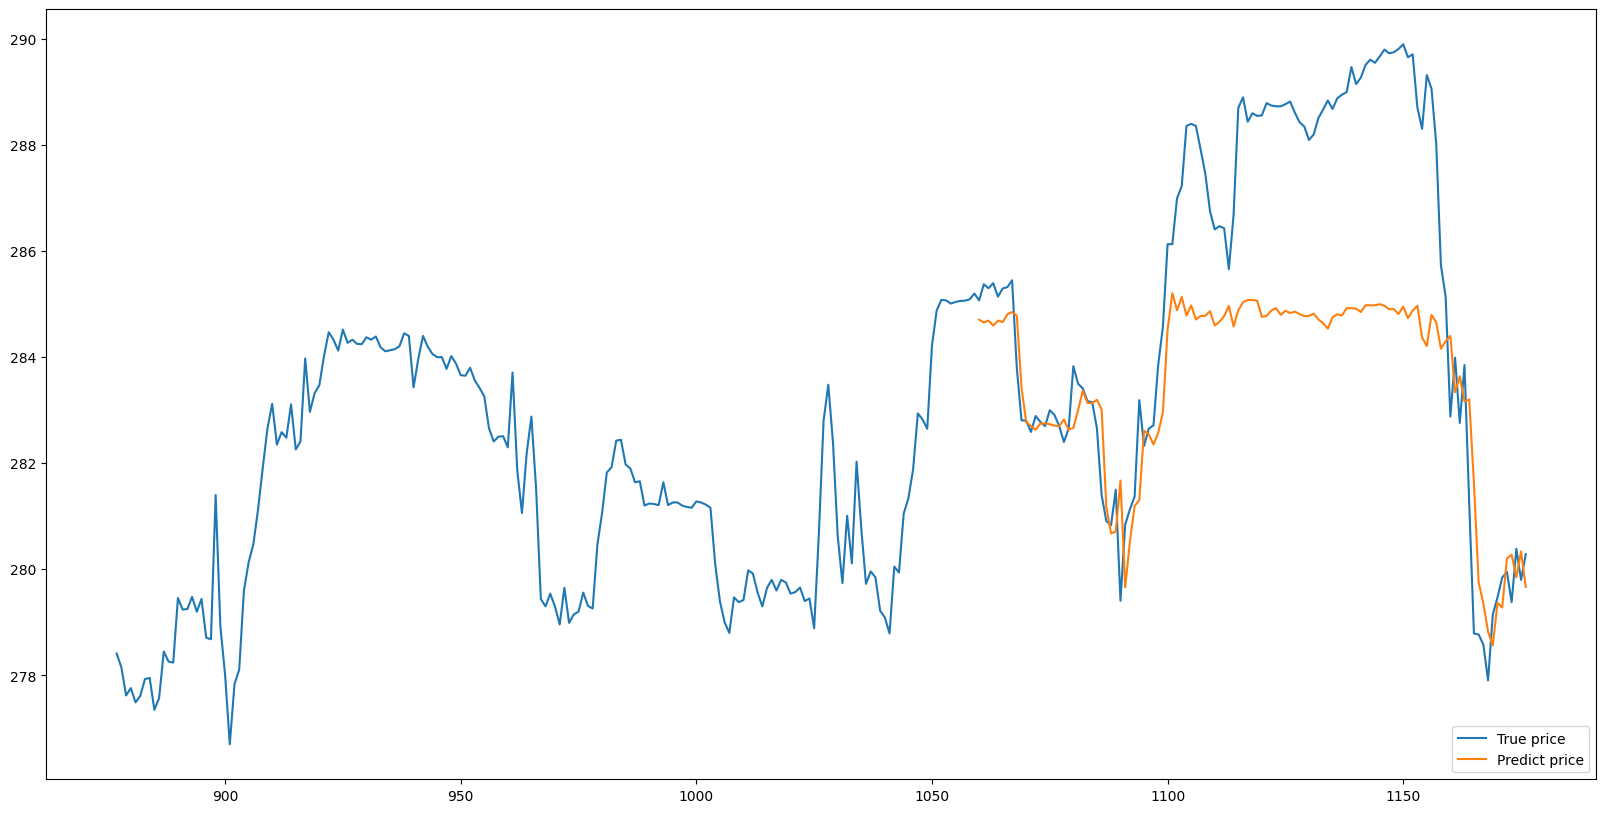

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1057497457.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1057497457.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1057497457.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

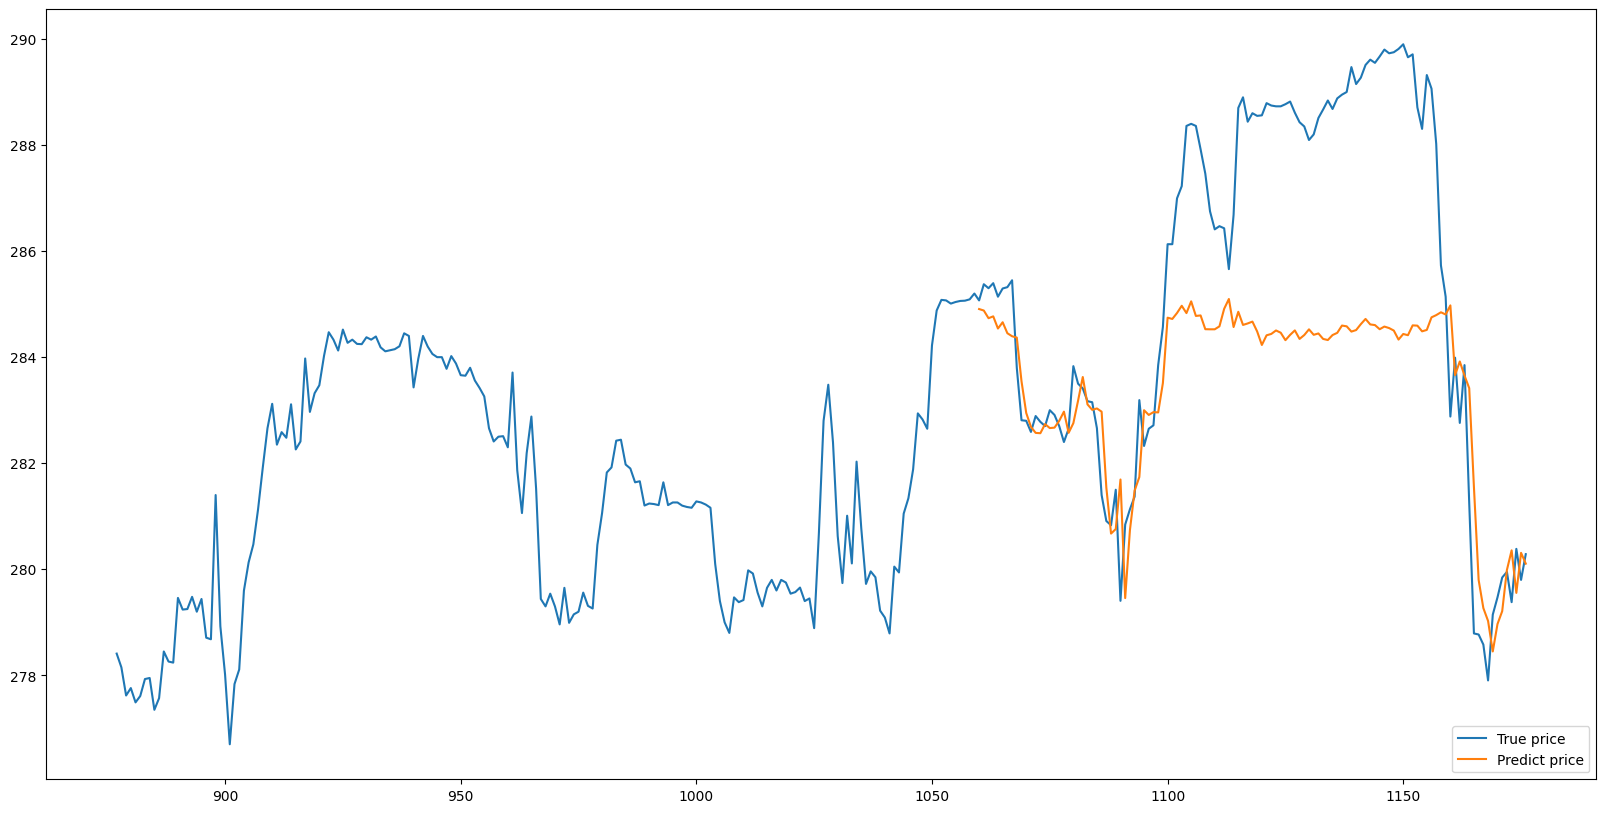

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1712437508.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1712437508.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1712437508.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

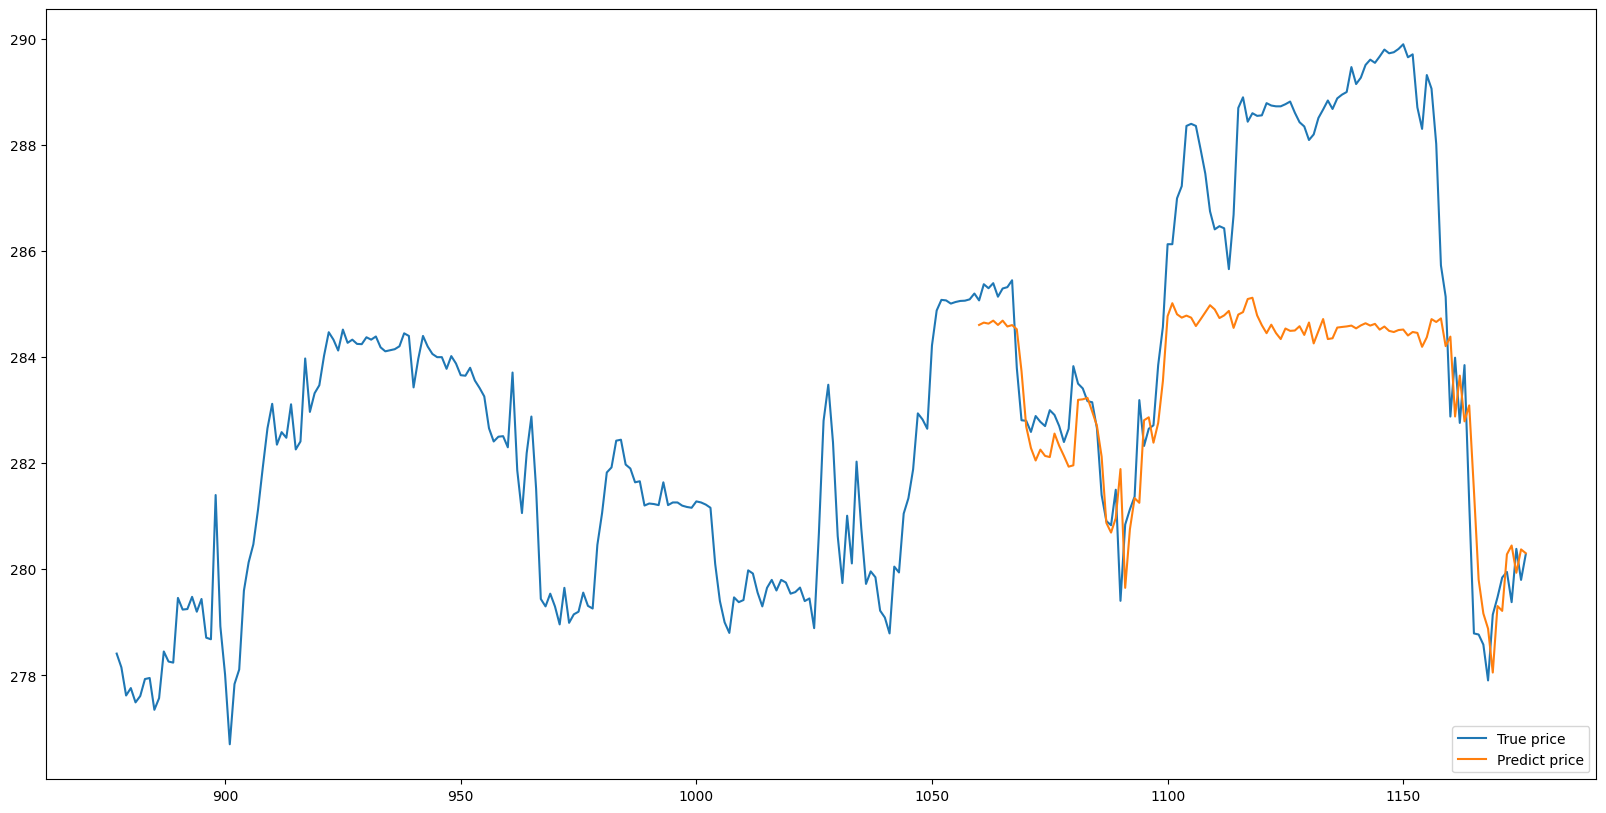

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\4048686227.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\4048686227.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\4048686227.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

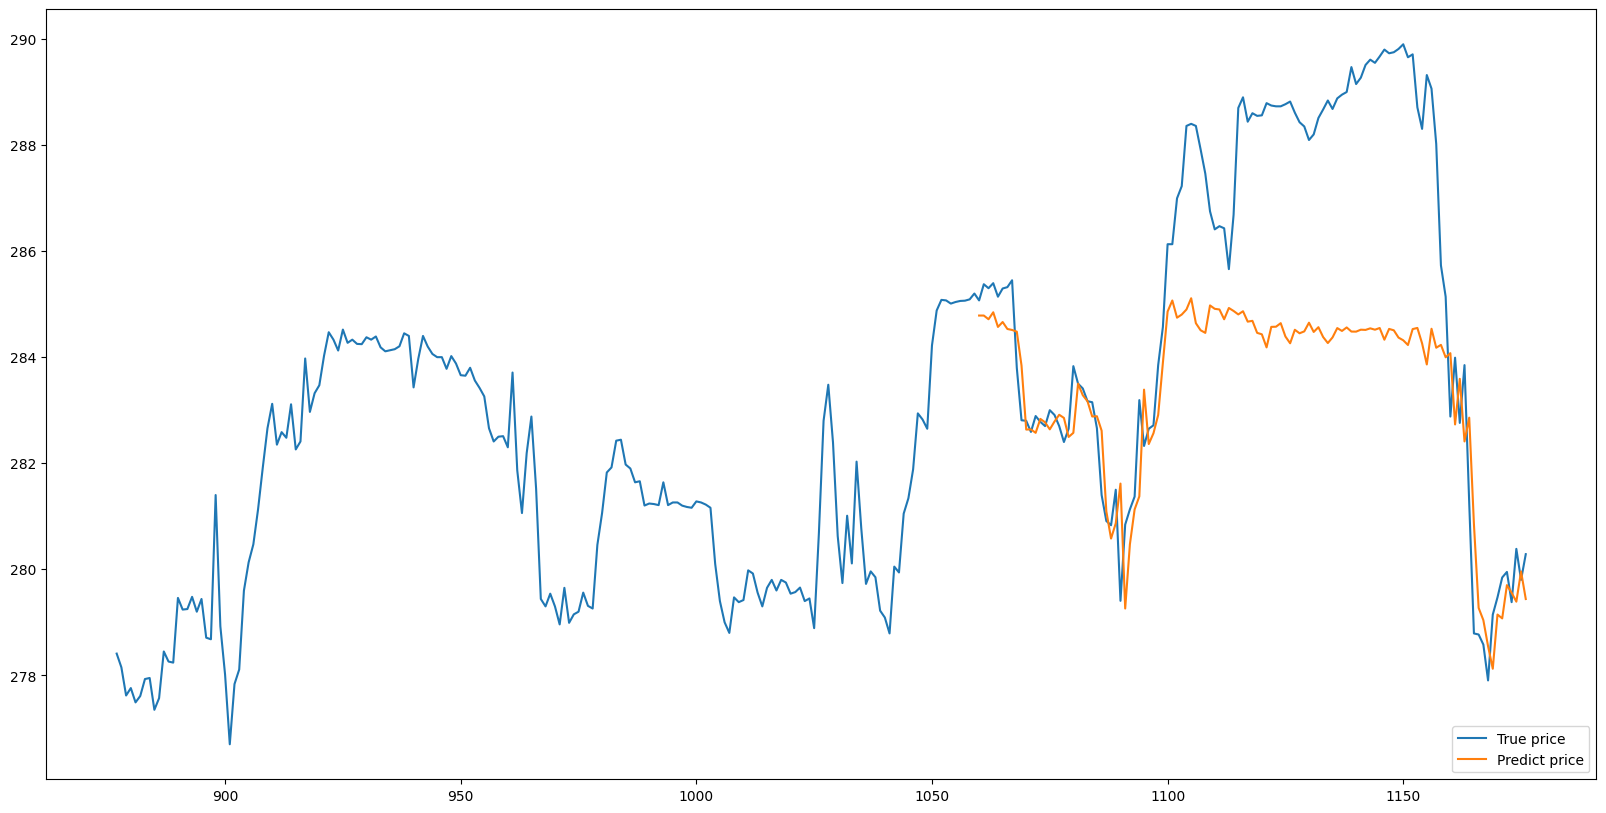

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3392056936.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3392056936.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3392056936.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

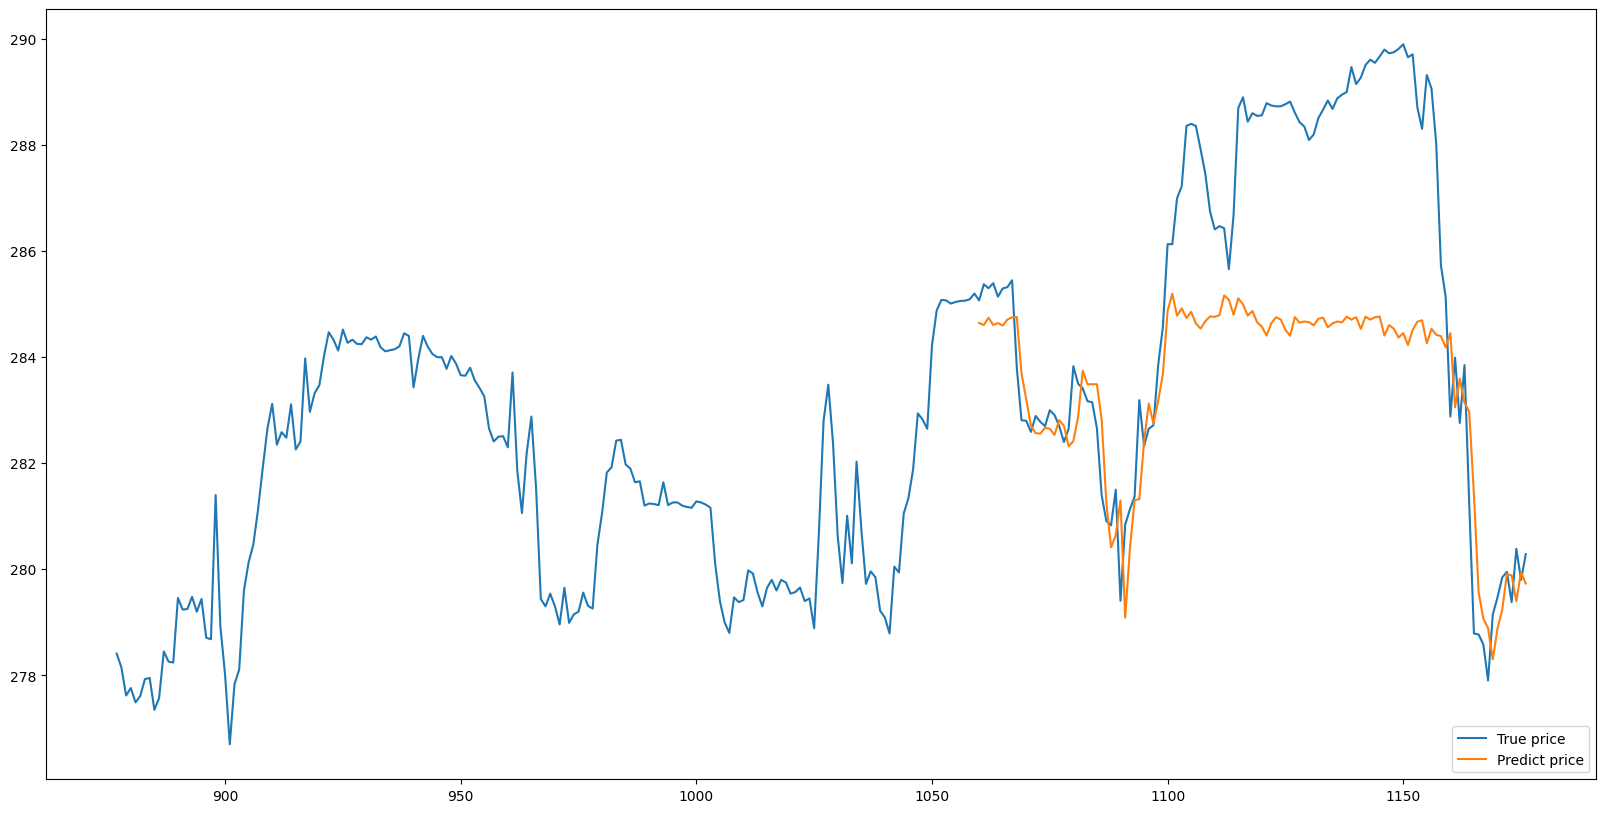

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1439481525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1439481525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1439481525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

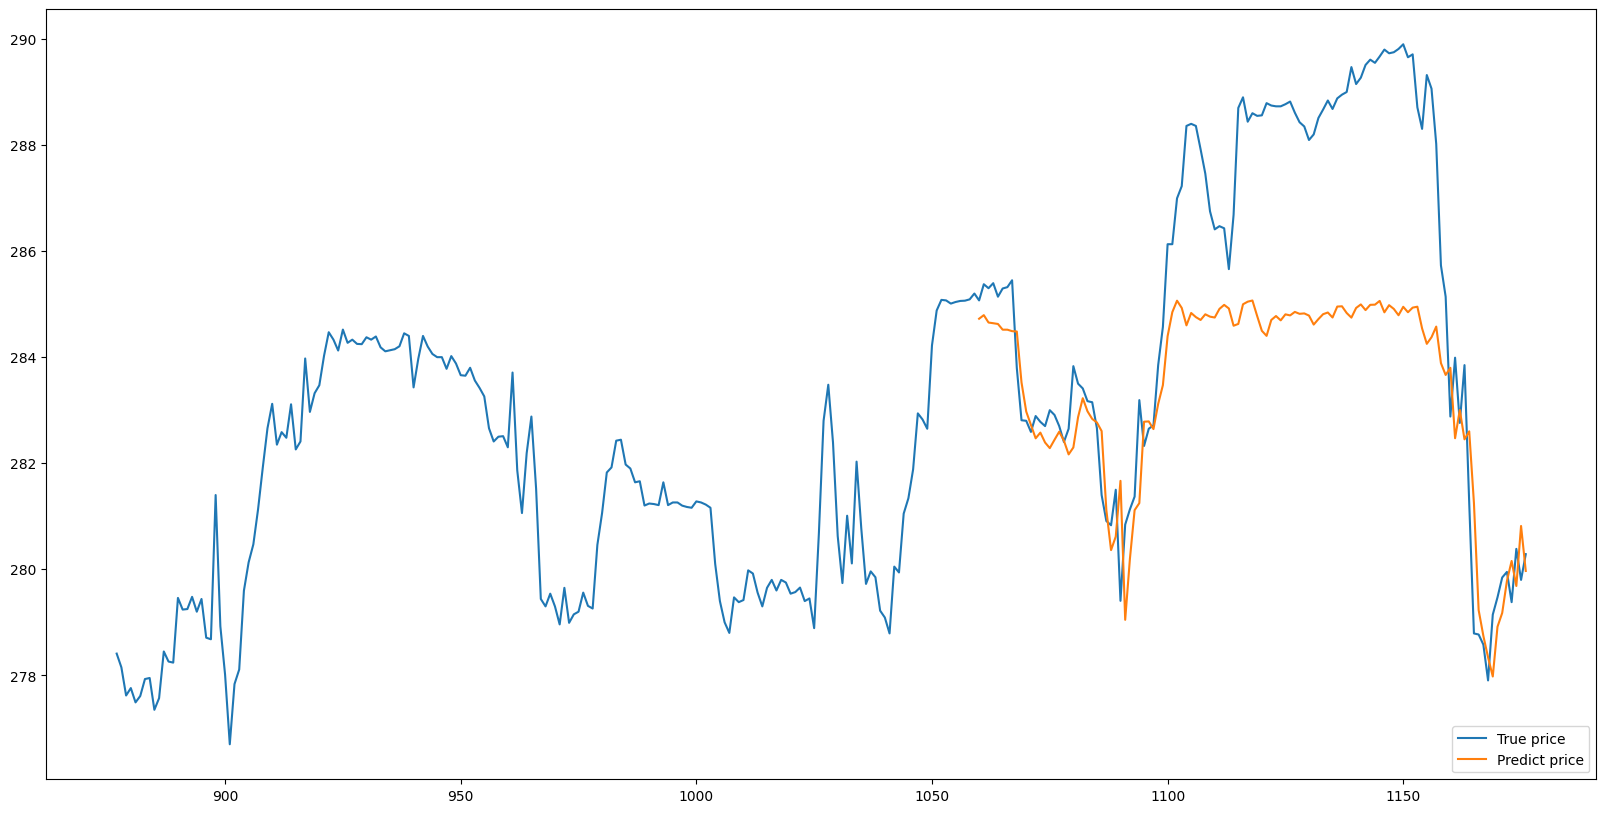

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1439481525.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1439481525.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1439481525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

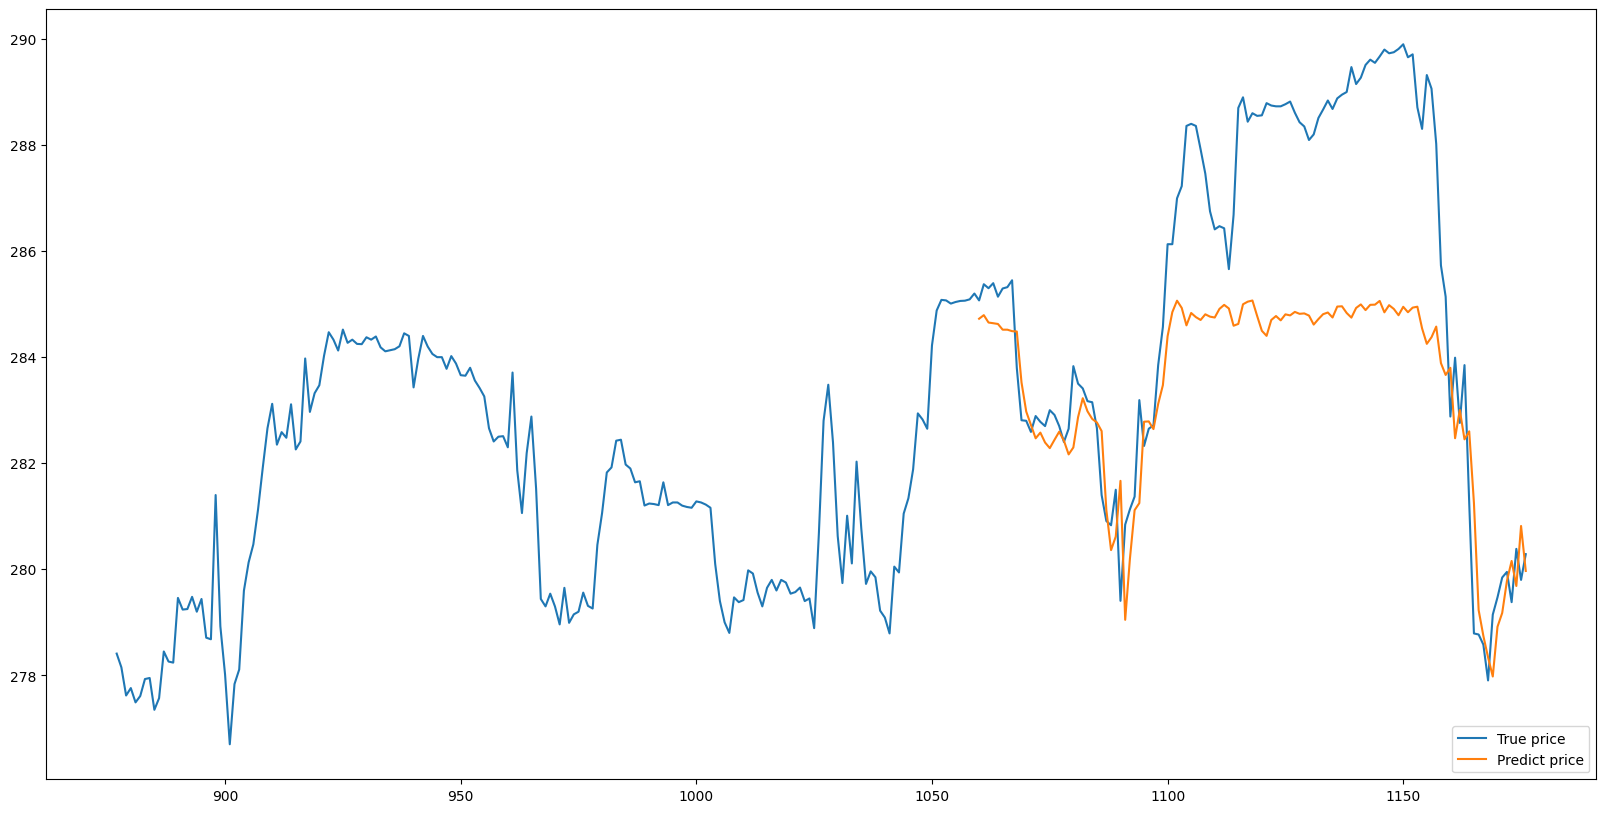

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3001060327.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3001060327.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\3001060327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

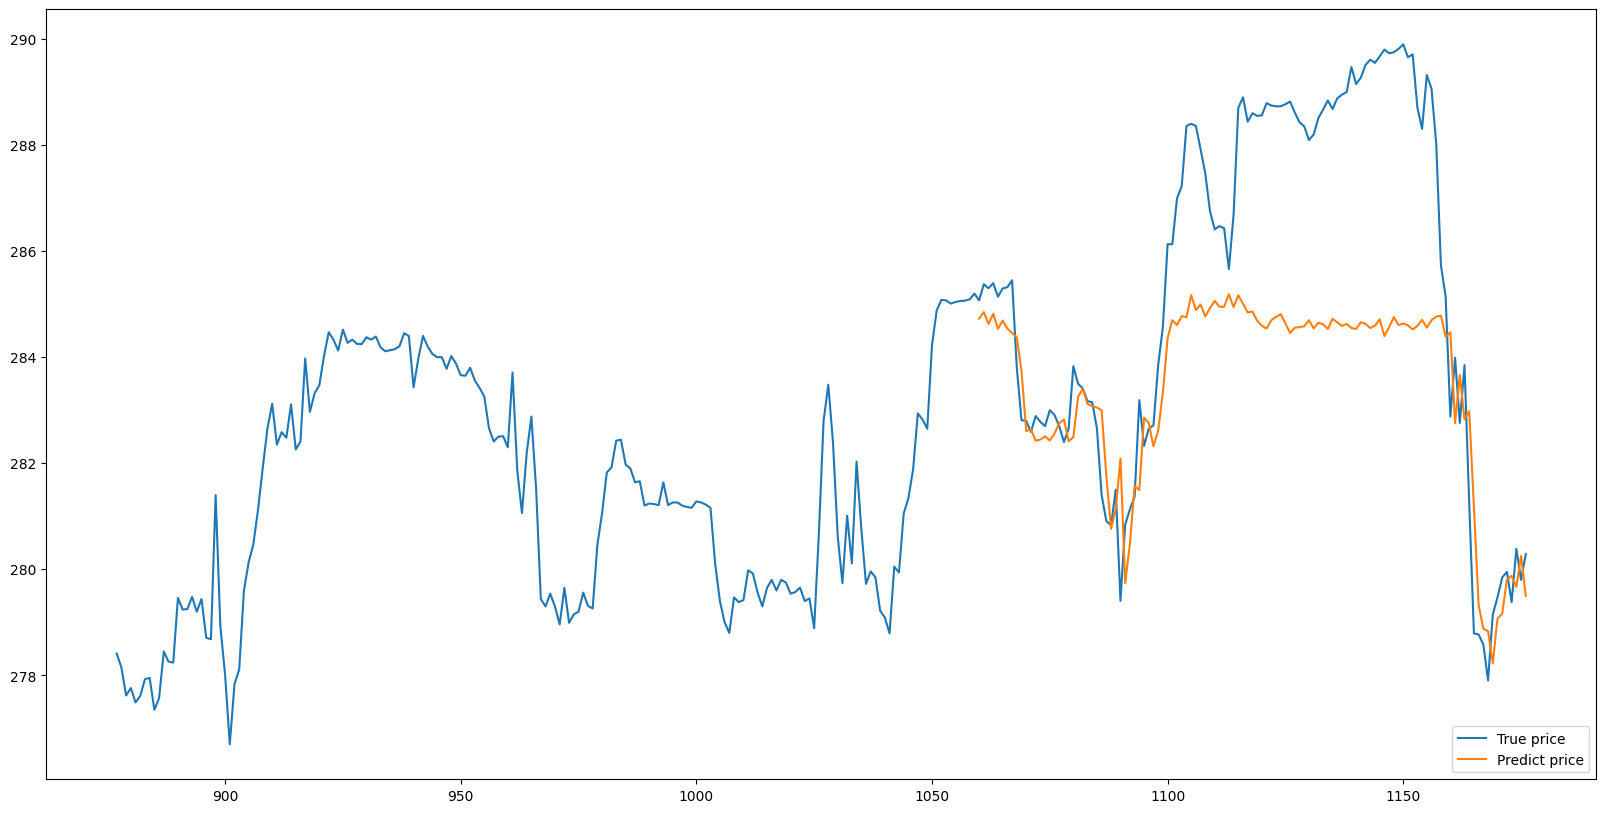

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1833709827.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1833709827.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\1833709827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

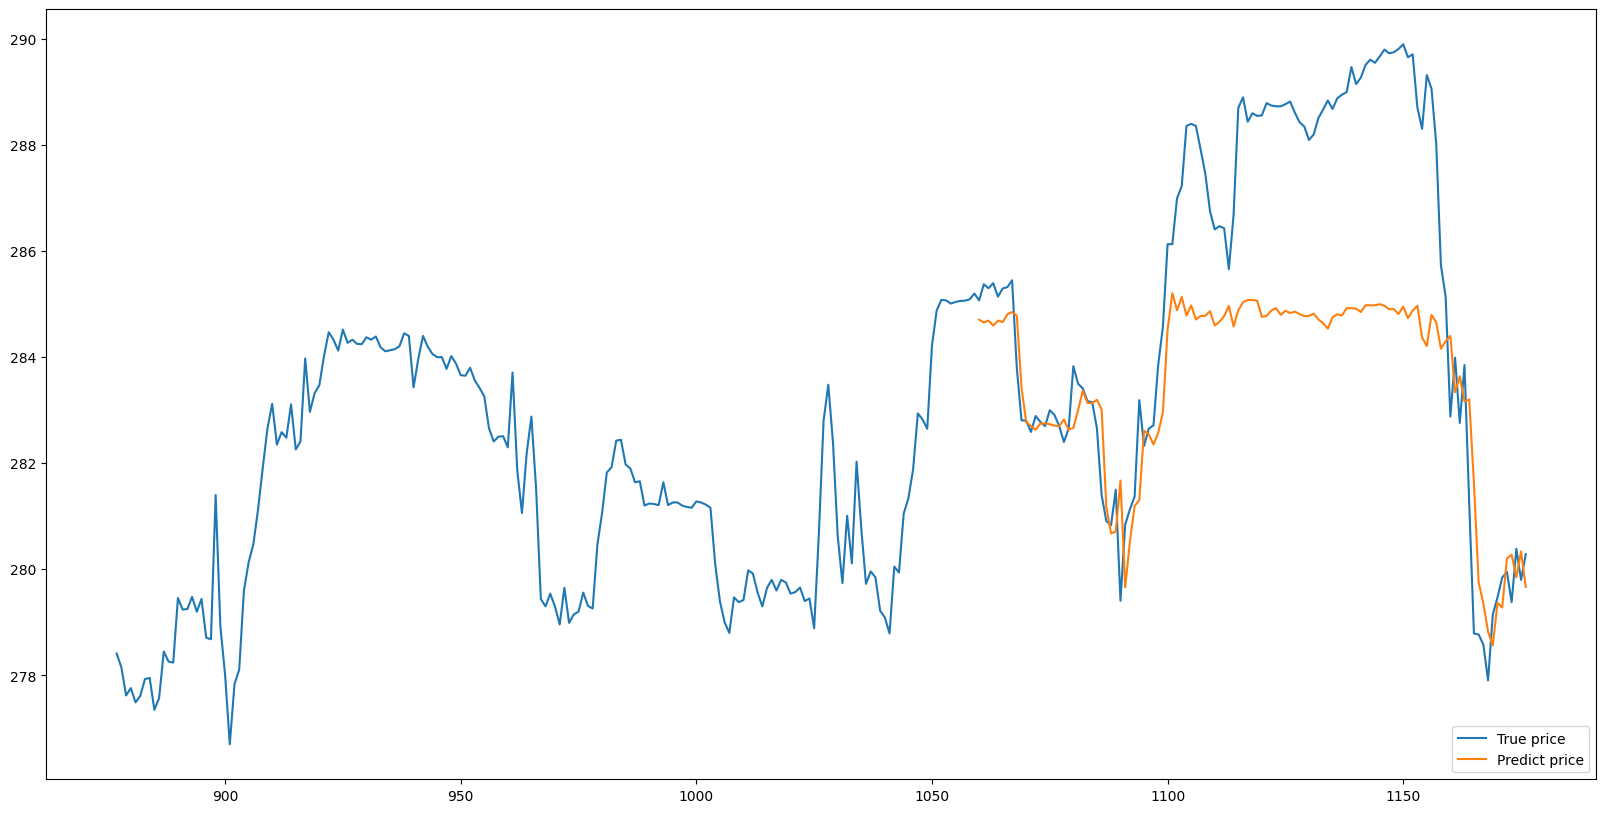

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2828653125.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2828653125.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\2828653125.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

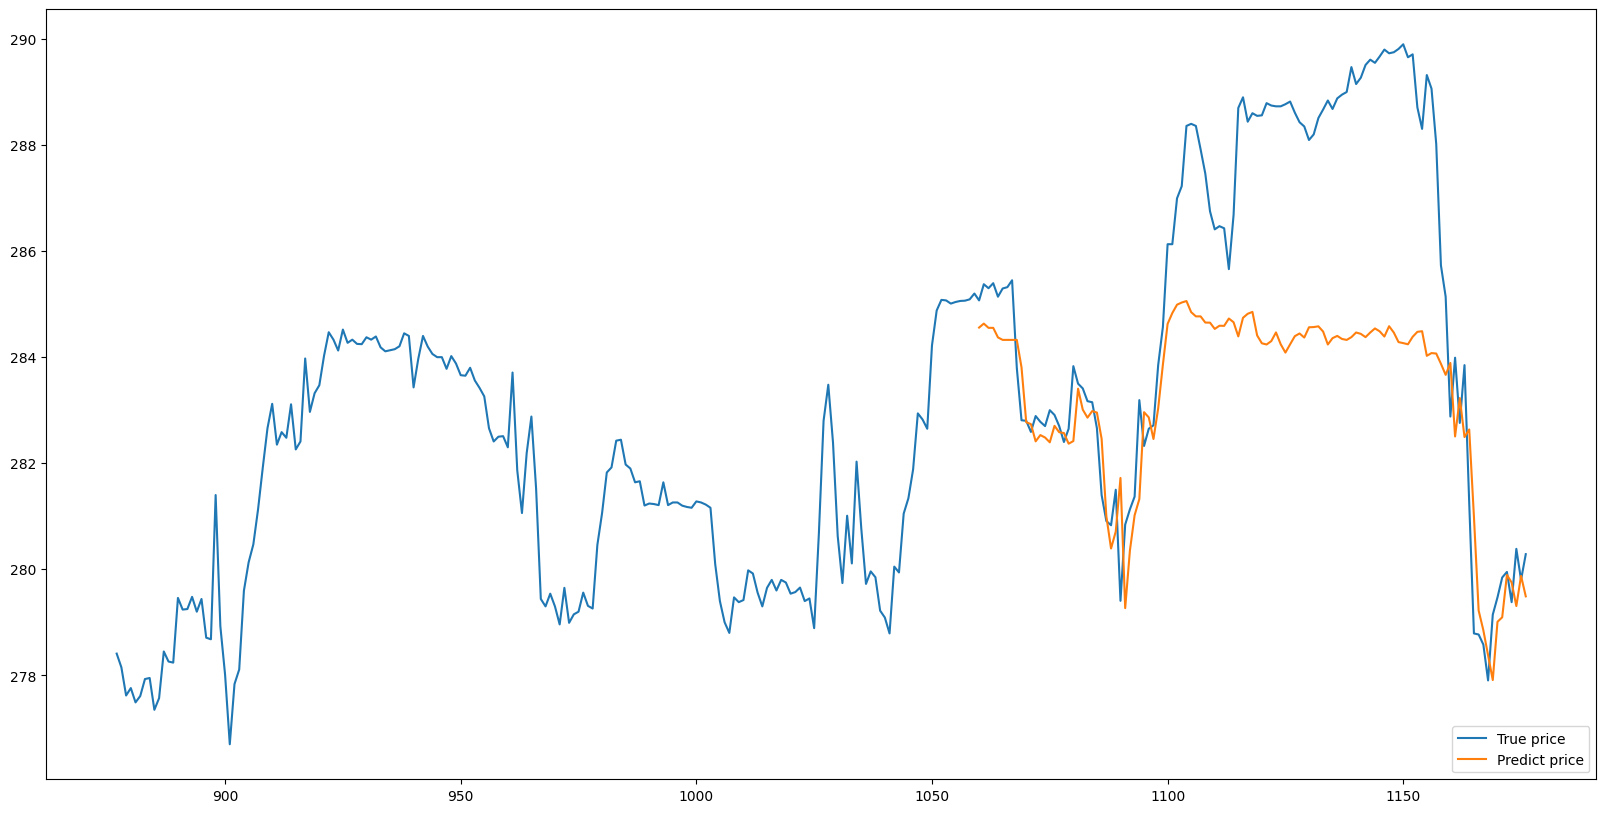

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\4263487865.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\4263487865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
C:\Users\TanTran\AppData\Local\Temp\ipykernel_5720\4263487865.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

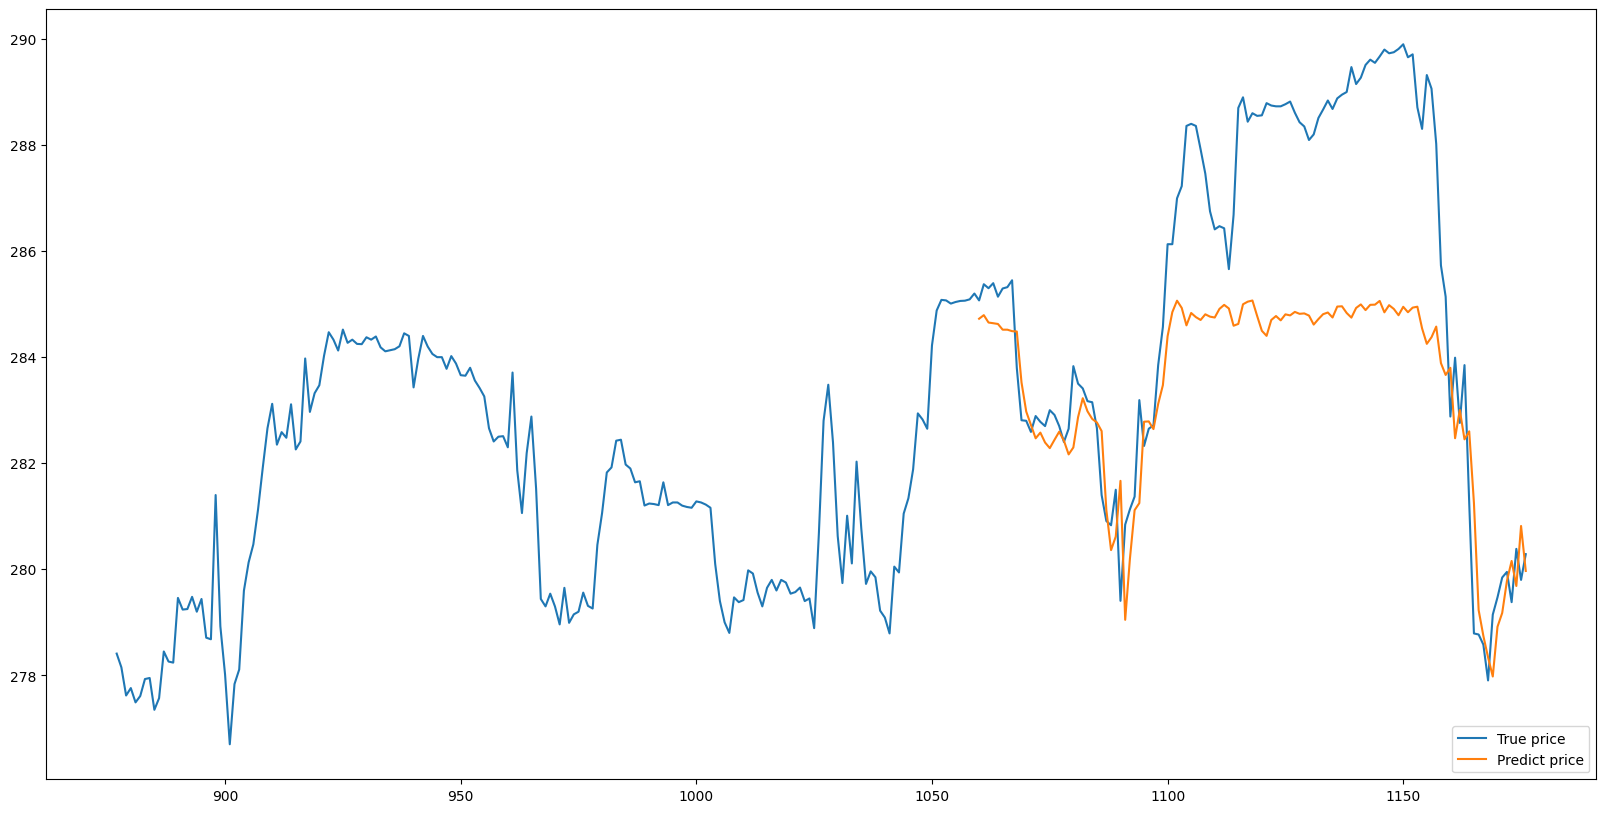

In [ ]:
original_df = pd.read_csv(csvPath)
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [ ]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue